基本框架： Graph Encoder+Decoder [收敛条件可adjustable] + Clustering(k-means, silhuette score 找最优解）

重建项目： Link reconstruction [GAT] + Masked node features reconstruction [DGCN]


In [1]:

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.sparse as sp


from utils import *
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK
import geopandas as gp


from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)
import os

from skimage import io

from PIL import Image
import gc 
import pandas as pd
from datetime import date
import requests
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import random
import math
import metrics

os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device( 'cpu')

### 

### 调取Node features

In [2]:
import os
arr=os.listdir('/home/yongcan/GDOT/clustering_kriging/week_median_data')
namelist=[]
for station in arr:
    station=station[:-4]
    namelist.append(station)


print(len(namelist))

486


In [3]:
stations = pd.read_csv('/home/yongcan/GDOT/clustering_kriging/distancewith0.csv')['Y0']
stations = list(stations)


In [4]:
stationname=[]
crdinstation=[]
for item in namelist:
    if item[0:8]  in stations:
        stationname.append(item)
        crdinstation.append(item[0:8])
    else:
        pass

In [5]:
crdinstation=list(set(crdinstation))
len(crdinstation)

253

In [6]:
X=[]
for station in stationname:
    values=[]
    fileaddress='/home/yongcan/GDOT/clustering_kriging/week_median_data/'+station+'.csv'
    station_df=pd.read_csv(fileaddress)
    for col in station_df.columns[1:8]:
        values += station_df[col].tolist()
    

    X.append(values)
    


X=np.array(X).astype(np.float32)

X.shape
 

(480, 2016)

#####  Proximity features 

In [7]:
def generateDF(path_distance='../Clustering_IGNNK/distancewith0.csv',path_coordinates='../station_coordinates.csv',namelist=crdinstation):
    df = pd.read_csv(path_distance) #Distance Matrix
    names1=list(df['Y0'])
    df=df.drop(columns=['Y0'])
    df.columns=names1
    CO=pd.read_csv(path_coordinates)
    df['stationname']=CO.ID
    df=df.set_index('stationname')
    df=df.loc[namelist]
    df=df[namelist]
    
    return df

In [8]:
Md = generateDF(path_distance='/home/yongcan/GDOT/clustering_kriging/distancewith0.csv',path_coordinates='/home/yongcan/GDOT/IGNNK/station_coordinates.csv',namelist=crdinstation)
matrix=pd.DataFrame(columns=stationname,index=stationname)


for station in stationname:
    for STATION in stationname:
        matrix.loc[station,STATION]=Md.loc[station[0:8],STATION[0:8]]

MAX=matrix.max()
matrix =matrix/MAX
matrix = np.exp(-matrix.astype(float))
#matrix=matrix.apply(pd.Series.nlargest, axis=1, n=493)
#matrix=matrix.fillna(0)
matrix=matrix.values
A=matrix


In [9]:
adj = np.zeros_like(A)
for i in range(len(A)):
    ind=np.argsort(A[i])[::-1][0:12]
    adj[i][ind]=1

print(X.shape)
print(adj.shape)

(480, 2016)
(480, 480)


In [10]:
def get_M(matrix,k):
    
    M = np.zeros_like(matrix)
    M = torch.Tensor(M)
    matrix=torch.Tensor(matrix)
    values, index=torch.topk(matrix,k)
    function = torch.nn.Softmax(dim=1)
    values = function(values)
    for i in range(len(M)):
        ind=index[i]
        M[i][ind]=values[i]

    
    return M

In [11]:
adj

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
M = get_M(A,12)
M

tensor([[0.0880, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0884, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0840,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0869, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0869, 0.0832],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0853]])

#### 划分Dataset 和 设定 hyperparameters 

In [13]:

training_set =X.transpose()
rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.

A_s = adj

In [14]:
training_set.shape

(2016, 480)

#### 搭建GAT模型和DGCN模型

##### GAT model

In [15]:
class GATLayer(nn.Module):
    """
    source:Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    
    adj: proximity
    
    M: edge weights
    
    """

    def __init__(self, in_features, out_features, alpha=0.2):
        super(GATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        self.a_self = nn.Parameter(torch.zeros(size=(out_features, 1)))
        nn.init.xavier_uniform_(self.a_self.data, gain=1.414)

        self.a_neighs = nn.Parameter(torch.zeros(size=(out_features, 1)))
        nn.init.xavier_uniform_(self.a_neighs.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj, M, concat=True):
       
        h = torch.mm(input, self.W)
        

        attn_for_self = torch.mm(h, self.a_self)  # (N,1)
        attn_for_neighs = torch.mm(h, self.a_neighs)  # (N,1)
        attn_dense = attn_for_self + torch.transpose(attn_for_neighs, 0, 1)
        attn_dense = torch.mul(attn_dense, M)
        attn_dense = self.leakyrelu(attn_dense)  # (N,N)

        zero_vec = -9e15 * torch.ones_like(adj)
        adj = torch.where(adj > 0, attn_dense, zero_vec)
        attention = F.softmax(adj, dim=1)
        h_prime = torch.matmul(attention, h)

        return F.elu(h_prime)

In [16]:
class GAT_encod(nn.Module):
    def __init__(self, num_features, hidden_size, embedding_size, alpha):
        super(GAT_encod, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.alpha = alpha
        self.conv1 = GATLayer(num_features, hidden_size, alpha)
        self.conv2 = GATLayer(hidden_size, embedding_size, alpha)

    
    def forward(self, x, adj, M):
        h = self.conv1(x, adj, M)
        h = self.conv2(h, adj, M)
        z = F.normalize(h, p=2, dim=1)
       
        return z

##### DGCN model

In [17]:
class D_GCN(nn.Module):
    """
    Neural network block that applies a diffusion graph convolution to sampled location
    """       
    def __init__(self, in_channels, out_channels, orders, activation = 'relu'): 
        """
        :param in_channels: Number of time step.
        :param out_channels: Desired number of output features at each node in
        each time step.
        :param order: The diffusion steps.
        """
        super(D_GCN, self).__init__()
        self.orders = orders
        self.activation = activation
        self.num_matrices = 2 * self.orders + 1
        self.Theta1 = nn.Parameter(torch.FloatTensor(in_channels * self.num_matrices,
                                             out_channels))
        self.bias = nn.Parameter(torch.FloatTensor(out_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Theta1.shape[1])
        self.Theta1.data.uniform_(-stdv, stdv)
        stdv1 = 1. / math.sqrt(self.bias.shape[0])
        self.bias.data.uniform_(-stdv1, stdv1)
        
    def _concat(self, x, x_):
        x_ = x_.unsqueeze(0)
        return torch.cat([x, x_], dim=0)
        
    def forward(self, X, A_q, A_h):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps)
        :A_q: The forward random walk matrix (num_nodes, num_nodes)
        :A_h: The backward random walk matrix (num_nodes, num_nodes)
        :return: Output data of shape (batch_size, num_nodes, num_features)
        """
        batch_size = X.shape[0] # batch_size
        num_node = X.shape[1]
        input_size = X.size(2)  # time_length
        supports = []
        supports.append(A_q)
        supports.append(A_h)
        
        x0 = X.permute(1, 2, 0) #(num_nodes, num_times, batch_size)
        x0 = torch.reshape(x0, shape=[num_node, input_size * batch_size])
        x = torch.unsqueeze(x0, 0)
        for support in supports:
            x1 = torch.mm(support, x0)
            x = self._concat(x, x1)
            for k in range(2, self.orders + 1):
                x2 = 2 * torch.mm(support, x1) - x0
                x = self._concat(x, x2)
                x1, x0 = x2, x1
                
        x = torch.reshape(x, shape=[self.num_matrices, num_node, input_size, batch_size])
        x = x.permute(3, 1, 2, 0)  # (batch_size, num_nodes, input_size, order)
        x = torch.reshape(x, shape=[batch_size, num_node, input_size * self.num_matrices])         
        x = torch.matmul(x, self.Theta1)  # (batch_size * self._num_nodes, output_size)     
        x += self.bias
        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'selu':
            x = F.selu(x)   
            
        return x

In [18]:
def calculate_random_walk_matrix(adj_mx):
    
    """
    Returns the random walk adjacency matrix. This is for D_GCN
    """
    adj_mx = sp.coo_matrix(adj_mx)
    d = np.array(adj_mx.sum(1))
    d_inv = np.power(d, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat_inv = sp.diags(d_inv)
    random_walk_mx = d_mat_inv.dot(adj_mx).tocoo()
    
    return random_walk_mx.toarray()

In [19]:
class ConvBiLSTM(nn.Module):
    def __init__(self):
        super(ConvBiLSTM, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=288, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.bilstm = nn.LSTM(input_size=64, hidden_size=144, num_layers=2, batch_first=True, bidirectional=True)
        
    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.bilstm(x)
        x = x.permute(0,2,1)
        return x

In [20]:
class DGCN_AE(nn.Module):
    """
    GNN on ST datasets to reconstruct the datasets
   x_s
    |GNN_3
   H_2 + H_1
    |GNN_2
   H_1
    |GNN_1
  x^y_m     
    """
    def __init__(self,h, z, k,num_features, hidden_size, embedding_size, alpha): 
        super(DGCN_AE, self).__init__()
        self.time_dimension = h
        self.hidden_dimnesion = z
        self.order = k
        
        self.GNN1 = D_GCN(self.time_dimension, self.hidden_dimnesion, self.order)
        self.GNN2 = D_GCN(self.hidden_dimnesion, self.hidden_dimnesion, self.order)

        self.cross_attn = nn.MultiheadAttention(embed_dim=z, num_heads=8)
       
        self.decoder= D_GCN(self.hidden_dimnesion, self.time_dimension, self.order, activation = 'linear')

        self.GAT_encod = GAT_encod(num_features, hidden_size, embedding_size, alpha)

        self.ConvBiLSTM = ConvBiLSTM()
    
    def dot_product_decode(self, Z):
        A_pred = torch.sigmoid(torch.matmul(Z, Z.t()))
        return A_pred

    def forward(self, X, A_q, A_h,adj,M):
        """
        :param X: Input data of shape (batch_size, num_timesteps, num_nodes)
        :A_q: The forward random walk matrix (num_nodes, num_nodes)
        :A_h: The backward random walk matrix (num_nodes, num_nodes)
        :return: Reconstructed X of shape (batch_size, num_timesteps, num_nodes)
        """  
        X = self.ConvBiLSTM(X)
        X_s = X.permute(0, 2, 1) # to correct the input dims 
        X_s1 = self.GNN1(X_s, A_q, A_h)
        X_em= self.GNN2(X_s1, A_q, A_h) + X_s1 #num_nodes, rank
        
        Edge_em = []
        A_pred = []
        for i in range(X.shape[0]):
            z_ = self.GAT_encod(torch.transpose(X[i], 0, 1),adj,M)
            A_p= self.dot_product_decode(z_)
            Edge_em.append(z_)
            A_pred.append(A_p)
        
        Edge_em= torch.stack(Edge_em)
        A_pred = A_pred[0]
        
        X_em,_= self.cross_attn(X_em,X_em,Edge_em)

        X_s2 = self.decoder(X_em, A_q, A_h) 

        X_res = X_s2.permute(0, 2, 1)



               
        return  X_res,X_em,Edge_em,A_pred

#### 训练GAE


In [21]:
z = 16 #hidden dimension for graph convolution 32
K = 2 #If using diffusion convolution, the actual diffusion convolution step is K+1 ##try more Convolution 
h = 288#360 minutes
batch_size = 4
learning_rate = 0.00001
Max_episode = 2000
num_features=h
hidden_size=32#64
embedding_size=16#32
alpha=0.2
scaler=0.008

In [22]:
GAE = DGCN_AE(h, z, K,num_features, hidden_size, embedding_size, alpha) 
GAE

DGCN_AE(
  (GNN1): D_GCN()
  (GNN2): D_GCN()
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (decoder): D_GCN()
  (GAT_encod): GAT_encod(
    (conv1): GATLayer(
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
    (conv2): GATLayer(
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (ConvBiLSTM): ConvBiLSTM(
    (conv1d): Conv1d(288, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (bilstm): LSTM(64, 144, num_layers=2, batch_first=True, bidirectional=True)
  )
)

In [23]:
needles = list(range(int(len(training_set)/288)))
needles = [item*288 for item in needles]
needles

[0, 288, 576, 864, 1152, 1440, 1728]

In [24]:
feed_batch=[]
for i in range(len(needles)):
        feed_batch.append(training_set[needles[i]:needles[i]+288,:])
inputs = np.array(feed_batch)

inputs = torch.from_numpy(inputs.astype('float32'))
inputs = torch.nn.functional.normalize(inputs, dim=1)

dataloader = DataLoader(inputs, batch_size=batch_size, shuffle=True)

In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(GAE.parameters(), lr=learning_rate)
losslist=[]
for epoch in range(Max_episode):
    loss_epoch=0
    for data in dataloader:
        
        Mf_inputs = data 
        A_dynamic = A_s #adj

        m = M
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32'))
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32'))

        #label

        node_label = Mf_inputs
        A_label = torch.Tensor(A_dynamic).to(dtype=torch.float)
       
        optimizer.zero_grad()
     

        X_res, embed,Edge_em,A_pred= GAE(Mf_inputs, A_q, A_h,A_label, m)

        loss_link = F.binary_cross_entropy(A_pred.reshape(-1), A_label.reshape(-1))

        loss_node = nn.MSELoss()(X_res.reshape(-1),node_label.reshape(-1))

        loss = loss_link*scaler+loss_node
        
        
        loss.backward()
        optimizer.step()  
        loss_epoch += loss
    
    print('the loss is {} at epoch {}'.format(loss,epoch))
    losslist.append(loss.detach().cpu().numpy())
    

idx = losslist == min(losslist)
print('Best model result:',np.array(losslist)[idx])

the loss is 0.015702014788985252 at epoch 0
the loss is 0.01565668359398842 at epoch 1
the loss is 0.015618259087204933 at epoch 2
the loss is 0.015501539222896099 at epoch 3
the loss is 0.01549309492111206 at epoch 4
the loss is 0.015421722084283829 at epoch 5
the loss is 0.015368472784757614 at epoch 6
the loss is 0.015329561196267605 at epoch 7
the loss is 0.015289844945073128 at epoch 8
the loss is 0.015261825174093246 at epoch 9
the loss is 0.015231135301291943 at epoch 10
the loss is 0.01521335355937481 at epoch 11
the loss is 0.01515851728618145 at epoch 12
the loss is 0.015186836011707783 at epoch 13
the loss is 0.015172643586993217 at epoch 14
the loss is 0.015154208987951279 at epoch 15
the loss is 0.015140218660235405 at epoch 16
the loss is 0.015068622305989265 at epoch 17
the loss is 0.015107863582670689 at epoch 18
the loss is 0.01509682834148407 at epoch 19
the loss is 0.015062801539897919 at epoch 20
the loss is 0.015039429999887943 at epoch 21
the loss is 0.01504155807

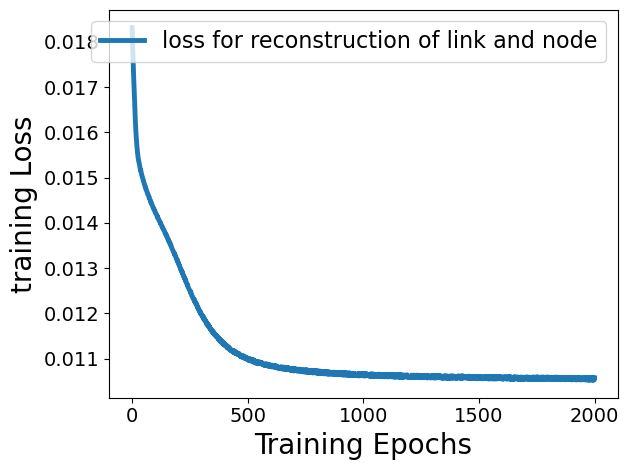

In [ ]:

fig,ax = plt.subplots()
ax.plot(losslist,label='loss for reconstruction of link and node',linewidth=3.5)
ax.set_xlabel('Training Epochs',fontsize=20)
ax.set_ylabel('training Loss',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()

In [26]:
torch.save(GAE.state_dict(), '../dual_GAE_June_9.pth') ## Save the modeltorch.save(GAE.st

#### collect the embeddings for clustering

In [27]:
GAE.load_state_dict(torch.load('../dual_GAE_June_9.pth'))
GAE.eval()

DGCN_AE(
  (GNN1): D_GCN()
  (GNN2): D_GCN()
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (decoder): D_GCN()
  (GAT_encod): GAT_encod(
    (conv1): GATLayer(
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
    (conv2): GATLayer(
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (ConvBiLSTM): ConvBiLSTM(
    (conv1d): Conv1d(288, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (bilstm): LSTM(64, 144, num_layers=2, batch_first=True, bidirectional=True)
  )
)

In [28]:
embeddings=[]
for data in dataloader:
    
    Mf_inputs = data #* missing_index  #normalize the value according to experience
    A_dynamic = A_s
    m = M
    A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32'))
    A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32'))
    node_label = Mf_inputs
    A_label = torch.Tensor(A_dynamic).to(dtype=torch.float)
    
    X_res, embed,Edge_em,A_pred= GAE(Mf_inputs, A_q, A_h,A_label, m)
    Edge_em=torch.transpose(Edge_em, 0, 1)
    Edge_em=torch.flatten(Edge_em, start_dim=1)
    embed=torch.transpose(embed, 0, 1)
    embed=torch.flatten(embed, start_dim=1)
    embedd=torch.cat((embed,Edge_em), 1)
    embedd=embedd.detach().cpu().numpy()
   
    embeddings.append(embedd)
    print(data.shape)

#
embeddings = np.concatenate(embeddings, axis=1)

torch.Size([4, 288, 480])
torch.Size([3, 288, 480])


In [29]:
embeddings.shape

(480, 224)

In [30]:
### kmeans(DTW, eudlidean,shape-based)

In [31]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score,calinski_harabasz_score,davies_bouldin_score

import matplotlib.cm as cm
import numpy as np




range_n_clusters = list(range(60,480))
scoring = pd.DataFrame(columns=['clusters'])
for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters,n_init='auto', random_state=10)
    cluster_labels = clusterer.fit_predict(embeddings)
    inertia_score = clusterer.inertia_
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    calh_score = calinski_harabasz_score(embeddings, cluster_labels)
    davidb_score = davies_bouldin_score(embeddings,cluster_labels)

    scoring = scoring._append({'clusters': n_clusters, 'Inertia_score': inertia_score,
                              'silhouette_scores': silhouette_avg,
                               'calinski_harabasz_score': calh_score,
                               'davies_bouldin_score':davidb_score}, ignore_index=True)
    print(
        "For n_clusters =",
        n_clusters,

        'the inertia score is :',inertia_score,
        "The average silhouette_score is :",
        silhouette_avg,

        'the cal_hara score is :', calh_score,
        'the davidb_score is :', davidb_score
    )


For n_clusters = 60 the inertia score is : 0.0003077383735217154 The average silhouette_score is : 0.62938523 the cal_hara score is : 1595.4911229441525 the davidb_score is : 0.5472770615811868
For n_clusters = 61 the inertia score is : 0.0002968322660308331 The average silhouette_score is : 0.63536227 the cal_hara score is : 1622.9275035117296 the davidb_score is : 0.5155143320145105
For n_clusters = 62 the inertia score is : 0.00028709351317957044 The average silhouette_score is : 0.6398181 the cal_hara score is : 1646.7658266971255 the davidb_score is : 0.49800096176571373
For n_clusters = 63 the inertia score is : 0.00027383214910514653 The average silhouette_score is : 0.64932656 the cal_hara score is : 1694.9314533459399 the davidb_score is : 0.49352493279841064
For n_clusters = 64 the inertia score is : 0.00026740884641185403 The average silhouette_score is : 0.6518997 the cal_hara score is : 1704.1572160532492 the davidb_score is : 0.48472694435610253
For n_clusters = 65 the in

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (189) found smaller than n_clusters (190). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (190) found smaller than n_clusters (191). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 190 the inertia score is : 3.261016803812744e-11 The average silhouette_score is : 0.95732516 the cal_hara score is : 2956436803.1989737 the davidb_score is : 0.01014641763733852
For n_clusters = 191 the inertia score is : 3.220766014999654e-11 The average silhouette_score is : 0.942312 the cal_hara score is : 2995496137.5998373 the davidb_score is : 0.021235782406131252


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (191) found smaller than n_clusters (192). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (191) found smaller than n_clusters (193). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 192 the inertia score is : 3.241721127644759e-11 The average silhouette_score is : 0.9289068 the cal_hara score is : 2989348103.688739 the davidb_score is : 0.04547996731380175
For n_clusters = 193 the inertia score is : 3.34250647993084e-11 The average silhouette_score is : 0.9289068 the cal_hara score is : 2989348103.688739 the davidb_score is : 0.04547996731380175


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (191) found smaller than n_clusters (194). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (192) found smaller than n_clusters (195). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 194 the inertia score is : 3.344406696026425e-11 The average silhouette_score is : 0.9289068 the cal_hara score is : 2989348103.688739 the davidb_score is : 0.04547996731380175
For n_clusters = 195 the inertia score is : 3.462083744687483e-11 The average silhouette_score is : 0.91044456 the cal_hara score is : 2999598047.571922 the davidb_score is : 0.06318212367749317


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (192) found smaller than n_clusters (196). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (193) found smaller than n_clusters (197). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 196 the inertia score is : 3.8658770629140804e-11 The average silhouette_score is : 0.91044456 the cal_hara score is : 2999598047.571922 the davidb_score is : 0.06318212367749317
For n_clusters = 197 the inertia score is : 3.868771622506095e-11 The average silhouette_score is : 0.88384247 the cal_hara score is : 2979141865.034967 the davidb_score is : 0.07304189214135386


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (193) found smaller than n_clusters (198). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 198 the inertia score is : 3.8784045419681945e-11 The average silhouette_score is : 0.88384247 the cal_hara score is : 2979141865.034967 the davidb_score is : 0.07304189214135387
For n_clusters = 199 the inertia score is : 4.0011698815289876e-11 The average silhouette_score is : 0.8746441 the cal_hara score is : 2995490056.687217 the davidb_score is : 0.08186186323514925


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (194) found smaller than n_clusters (199). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (194) found smaller than n_clusters (200). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 200 the inertia score is : 4.053286525862454e-11 The average silhouette_score is : 0.8746441 the cal_hara score is : 2995490056.687217 the davidb_score is : 0.08186186323514925
For n_clusters = 201 the inertia score is : 4.193369262939228e-11 The average silhouette_score is : 0.8746441 the cal_hara score is : 2995490056.687217 the davidb_score is : 0.08186186323514925


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (194) found smaller than n_clusters (201). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (195) found smaller than n_clusters (202). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 202 the inertia score is : 3.978996646059052e-11 The average silhouette_score is : 0.9287519 the cal_hara score is : 3063762990.281379 the davidb_score is : 0.03788033018429379


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (195) found smaller than n_clusters (203). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 203 the inertia score is : 4.1703591968644815e-11 The average silhouette_score is : 0.9092038 the cal_hara score is : 3008776983.1707196 the davidb_score is : 0.08927170042041632


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (196) found smaller than n_clusters (204). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 204 the inertia score is : 4.249002538703195e-11 The average silhouette_score is : 0.92229664 the cal_hara score is : 3064838482.47248 the davidb_score is : 0.04854187896102698


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (196) found smaller than n_clusters (205). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 205 the inertia score is : 4.368311962155147e-11 The average silhouette_score is : 0.9086678 the cal_hara score is : 2996087477.5986466 the davidb_score is : 0.07676978188604942


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (196) found smaller than n_clusters (206). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 206 the inertia score is : 4.248777718540708e-11 The average silhouette_score is : 0.9245005 the cal_hara score is : 3119003019.1968875 the davidb_score is : 0.034875904434570025


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (199) found smaller than n_clusters (207). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 207 the inertia score is : 4.383752041925426e-11 The average silhouette_score is : 0.8637256 the cal_hara score is : 3030348644.4191613 the davidb_score is : 0.08847828478551682


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (197) found smaller than n_clusters (208). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 208 the inertia score is : 4.7220460180907864e-11 The average silhouette_score is : 0.8934613 the cal_hara score is : 3207768458.7404146 the davidb_score is : 0.06061190809000572


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (197) found smaller than n_clusters (209). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 209 the inertia score is : 4.5453450031596176e-11 The average silhouette_score is : 0.8815901 the cal_hara score is : 3005087625.702797 the davidb_score is : 0.14598272320261774


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (199) found smaller than n_clusters (210). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 210 the inertia score is : 4.5580813429202394e-11 The average silhouette_score is : 0.8829159 the cal_hara score is : 3073951606.8805375 the davidb_score is : 0.07421533268085388


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (201) found smaller than n_clusters (211). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 211 the inertia score is : 4.804394729274186e-11 The average silhouette_score is : 0.8741299 the cal_hara score is : 3326605393.0435348 the davidb_score is : 0.08465076970220602


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (199) found smaller than n_clusters (212). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 212 the inertia score is : 4.693529939703289e-11 The average silhouette_score is : 0.87804 the cal_hara score is : 3092569463.537795 the davidb_score is : 0.07095277048373269


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (202) found smaller than n_clusters (213). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 213 the inertia score is : 4.7717059470375744e-11 The average silhouette_score is : 0.8536177 the cal_hara score is : 3157489481.8367715 the davidb_score is : 0.08800759387644816


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (199) found smaller than n_clusters (214). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 214 the inertia score is : 4.8167397154186276e-11 The average silhouette_score is : 0.8967077 the cal_hara score is : 3166851445.674909 the davidb_score is : 0.04581808048393315


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (199) found smaller than n_clusters (215). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 215 the inertia score is : 4.69701257055366e-11 The average silhouette_score is : 0.8678486 the cal_hara score is : 3006376050.1867485 the davidb_score is : 0.08832891483741016


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (203) found smaller than n_clusters (216). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 216 the inertia score is : 4.777439555070373e-11 The average silhouette_score is : 0.84604466 the cal_hara score is : 3237298994.860898 the davidb_score is : 0.09557119984862213


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (203) found smaller than n_clusters (217). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 217 the inertia score is : 4.805688832987265e-11 The average silhouette_score is : 0.83539325 the cal_hara score is : 3074269470.396421 the davidb_score is : 0.11707434416531586


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (199) found smaller than n_clusters (218). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 218 the inertia score is : 4.6302135736642214e-11 The average silhouette_score is : 0.8679479 the cal_hara score is : 3072295297.8801355 the davidb_score is : 0.09309832536680743


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (206) found smaller than n_clusters (219). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 219 the inertia score is : 4.602618633442468e-11 The average silhouette_score is : 0.85597724 the cal_hara score is : 3390825849.2490797 the davidb_score is : 0.10317357864150843


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (203) found smaller than n_clusters (220). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 220 the inertia score is : 4.68505095829741e-11 The average silhouette_score is : 0.84450954 the cal_hara score is : 3184197660.909459 the davidb_score is : 0.1265081173295522


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (203) found smaller than n_clusters (221). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 221 the inertia score is : 4.8347863906839095e-11 The average silhouette_score is : 0.8458843 the cal_hara score is : 3230404718.027563 the davidb_score is : 0.10341624943504793


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (205) found smaller than n_clusters (222). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 222 the inertia score is : 4.667431025007218e-11 The average silhouette_score is : 0.8428432 the cal_hara score is : 3228049855.8320956 the davidb_score is : 0.09972873918806273


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (205) found smaller than n_clusters (223). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 223 the inertia score is : 4.71030506266068e-11 The average silhouette_score is : 0.8418669 the cal_hara score is : 3031437062.9338503 the davidb_score is : 0.15613581602954937


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (202) found smaller than n_clusters (224). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 224 the inertia score is : 4.776789380711577e-11 The average silhouette_score is : 0.85483867 the cal_hara score is : 3181168497.3719583 the davidb_score is : 0.09609744883010146


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (205) found smaller than n_clusters (225). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 225 the inertia score is : 4.627419628033813e-11 The average silhouette_score is : 0.8324607 the cal_hara score is : 3138594412.0827055 the davidb_score is : 0.122336565317988


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (205) found smaller than n_clusters (226). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 226 the inertia score is : 4.8157627191569574e-11 The average silhouette_score is : 0.86761093 the cal_hara score is : 3211040763.9687014 the davidb_score is : 0.10286438117580007


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (204) found smaller than n_clusters (227). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 227 the inertia score is : 5.263771016283947e-11 The average silhouette_score is : 0.83171827 the cal_hara score is : 3289343820.4651594 the davidb_score is : 0.11929268226479808


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (208) found smaller than n_clusters (228). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 228 the inertia score is : 4.7972348315994395e-11 The average silhouette_score is : 0.8299042 the cal_hara score is : 3136553969.5598264 the davidb_score is : 0.14871351147679904


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (206) found smaller than n_clusters (229). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 229 the inertia score is : 4.4568529422583936e-11 The average silhouette_score is : 0.8225892 the cal_hara score is : 3149983337.0713625 the davidb_score is : 0.12262035285503343


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (207) found smaller than n_clusters (230). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 230 the inertia score is : 5.1115372351473454e-11 The average silhouette_score is : 0.8221686 the cal_hara score is : 3160940469.980992 the davidb_score is : 0.13253278859750026


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (204) found smaller than n_clusters (231). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 231 the inertia score is : 4.662846844749602e-11 The average silhouette_score is : 0.84355825 the cal_hara score is : 3097284134.9831553 the davidb_score is : 0.11122794773526902


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (210) found smaller than n_clusters (232). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 232 the inertia score is : 4.984093346371843e-11 The average silhouette_score is : 0.805633 the cal_hara score is : 3230504389.9751477 the davidb_score is : 0.11763306254978653


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (208) found smaller than n_clusters (233). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 233 the inertia score is : 4.6050191437885246e-11 The average silhouette_score is : 0.8382272 the cal_hara score is : 3275137325.4118853 the davidb_score is : 0.11145015329326399


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (208) found smaller than n_clusters (234). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 234 the inertia score is : 5.0265212131472836e-11 The average silhouette_score is : 0.82130355 the cal_hara score is : 3097464391.046245 the davidb_score is : 0.13031904492469615


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (205) found smaller than n_clusters (235). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 235 the inertia score is : 4.806868098006234e-11 The average silhouette_score is : 0.8347921 the cal_hara score is : 3115458382.380329 the davidb_score is : 0.11249245041051555


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (209) found smaller than n_clusters (236). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 236 the inertia score is : 5.268017619353138e-11 The average silhouette_score is : 0.8441037 the cal_hara score is : 3177922419.5707746 the davidb_score is : 0.12868007807386578


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (210) found smaller than n_clusters (237). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 237 the inertia score is : 5.192166141476662e-11 The average silhouette_score is : 0.83299774 the cal_hara score is : 3148292851.1182985 the davidb_score is : 0.11800637656399486


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (210) found smaller than n_clusters (238). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 238 the inertia score is : 5.014404863556976e-11 The average silhouette_score is : 0.8204335 the cal_hara score is : 3172181479.76562 the davidb_score is : 0.13095336157756782


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (208) found smaller than n_clusters (239). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 239 the inertia score is : 4.727875729804154e-11 The average silhouette_score is : 0.81852216 the cal_hara score is : 2987084949.2088165 the davidb_score is : 0.12861367580099706


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (213) found smaller than n_clusters (240). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 240 the inertia score is : 5.1989905436311545e-11 The average silhouette_score is : 0.8276175 the cal_hara score is : 3154526987.3407626 the davidb_score is : 0.14424158499139603


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (212) found smaller than n_clusters (241). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 241 the inertia score is : 4.855441049222975e-11 The average silhouette_score is : 0.8209945 the cal_hara score is : 3121264686.479795 the davidb_score is : 0.15341370800936494


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (214) found smaller than n_clusters (242). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 242 the inertia score is : 5.0184564837074674e-11 The average silhouette_score is : 0.79519075 the cal_hara score is : 3208025831.781294 the davidb_score is : 0.15337158418459712


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (214) found smaller than n_clusters (243). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 243 the inertia score is : 5.032581643082956e-11 The average silhouette_score is : 0.8148216 the cal_hara score is : 3265745357.6479373 the davidb_score is : 0.13300560497741615


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (212) found smaller than n_clusters (244). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 244 the inertia score is : 4.968234851299158e-11 The average silhouette_score is : 0.815447 the cal_hara score is : 3121412489.793421 the davidb_score is : 0.14002733488676106


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (212) found smaller than n_clusters (245). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 245 the inertia score is : 4.76740973087697e-11 The average silhouette_score is : 0.8159242 the cal_hara score is : 3041292332.503619 the davidb_score is : 0.1600980064351456


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (215) found smaller than n_clusters (246). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 246 the inertia score is : 4.995420743725276e-11 The average silhouette_score is : 0.79942214 the cal_hara score is : 3243695394.005146 the davidb_score is : 0.15503608447753844


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (247). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 247 the inertia score is : 5.1396928379965345e-11 The average silhouette_score is : 0.7832085 the cal_hara score is : 3184801314.915134 the davidb_score is : 0.21593872296840477


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (215) found smaller than n_clusters (248). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 248 the inertia score is : 5.1218380231476957e-11 The average silhouette_score is : 0.800144 the cal_hara score is : 3209647214.5260077 the davidb_score is : 0.15500452273400492


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (249). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 249 the inertia score is : 5.093305291414829e-11 The average silhouette_score is : 0.782328 the cal_hara score is : 3081782517.9527054 the davidb_score is : 0.2166727129908367


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (219) found smaller than n_clusters (250). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 250 the inertia score is : 5.078714532258388e-11 The average silhouette_score is : 0.7697236 the cal_hara score is : 3268550608.0920935 the davidb_score is : 0.19624700379911186


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (219) found smaller than n_clusters (251). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 251 the inertia score is : 5.228821889358137e-11 The average silhouette_score is : 0.7799016 the cal_hara score is : 3302706624.5861535 the davidb_score is : 0.182019702850588


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (218) found smaller than n_clusters (252). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 252 the inertia score is : 5.226024474280777e-11 The average silhouette_score is : 0.78165764 the cal_hara score is : 3153782316.526286 the davidb_score is : 0.20842177504659617


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (221) found smaller than n_clusters (253). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 253 the inertia score is : 5.4219080614092974e-11 The average silhouette_score is : 0.77990013 the cal_hara score is : 3251079022.2680387 the davidb_score is : 0.1540900205050646


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (222) found smaller than n_clusters (254). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 254 the inertia score is : 5.1142597101705434e-11 The average silhouette_score is : 0.7693011 the cal_hara score is : 3087855633.9399195 the davidb_score is : 0.1896303421800406


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (222) found smaller than n_clusters (255). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 255 the inertia score is : 4.873882547551389e-11 The average silhouette_score is : 0.75808895 the cal_hara score is : 3078622293.6065383 the davidb_score is : 0.23949757968410307


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (221) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 256 the inertia score is : 5.252697235502701e-11 The average silhouette_score is : 0.7748958 the cal_hara score is : 3100829311.845686 the davidb_score is : 0.23013544145677028


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (226) found smaller than n_clusters (257). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 257 the inertia score is : 5.1934831435396234e-11 The average silhouette_score is : 0.7541807 the cal_hara score is : 3253698658.791601 the davidb_score is : 0.18712766395898908


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (223) found smaller than n_clusters (258). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 258 the inertia score is : 4.9840978566528804e-11 The average silhouette_score is : 0.75535953 the cal_hara score is : 3184816564.446335 the davidb_score is : 0.20591201955319885


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (223) found smaller than n_clusters (259). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 259 the inertia score is : 5.4832499651880084e-11 The average silhouette_score is : 0.75785065 the cal_hara score is : 3147753998.8578434 the davidb_score is : 0.19671213176850763


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (224) found smaller than n_clusters (260). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 260 the inertia score is : 5.1881093171557424e-11 The average silhouette_score is : 0.7667329 the cal_hara score is : 3222563977.1618505 the davidb_score is : 0.20676137128858213


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (224) found smaller than n_clusters (261). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 261 the inertia score is : 5.318254864272731e-11 The average silhouette_score is : 0.7633597 the cal_hara score is : 3153451332.097985 the davidb_score is : 0.16972774176306477


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (223) found smaller than n_clusters (262). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 262 the inertia score is : 5.3933892074642387e-11 The average silhouette_score is : 0.75957906 the cal_hara score is : 3167773255.1008167 the davidb_score is : 0.1968554423232708


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (226) found smaller than n_clusters (263). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 263 the inertia score is : 5.2627919383541055e-11 The average silhouette_score is : 0.7315695 the cal_hara score is : 3171354434.3303514 the davidb_score is : 0.24447143748411707


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (226) found smaller than n_clusters (264). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 264 the inertia score is : 5.1921765498175176e-11 The average silhouette_score is : 0.7364119 the cal_hara score is : 3049265465.9959774 the davidb_score is : 0.23356055608852205


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (225) found smaller than n_clusters (265). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 265 the inertia score is : 5.619839663073556e-11 The average silhouette_score is : 0.7325363 the cal_hara score is : 3224267143.000367 the davidb_score is : 0.20832580359876318


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (222) found smaller than n_clusters (266). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 266 the inertia score is : 5.092104515824758e-11 The average silhouette_score is : 0.7433216 the cal_hara score is : 3018289047.3599553 the davidb_score is : 0.19243719065714177


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (225) found smaller than n_clusters (267). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 267 the inertia score is : 5.4002757127191714e-11 The average silhouette_score is : 0.7243005 the cal_hara score is : 3045713685.623208 the davidb_score is : 0.26804156611079777


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (228) found smaller than n_clusters (268). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 268 the inertia score is : 5.3831362978318253e-11 The average silhouette_score is : 0.73226094 the cal_hara score is : 3000958055.0424724 the davidb_score is : 0.22289306668824696


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (229) found smaller than n_clusters (269). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 269 the inertia score is : 5.3603940730617694e-11 The average silhouette_score is : 0.72664857 the cal_hara score is : 3127287782.543691 the davidb_score is : 0.2082552088329035


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (228) found smaller than n_clusters (270). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 270 the inertia score is : 5.588975116044281e-11 The average silhouette_score is : 0.7423321 the cal_hara score is : 3156492707.1249175 the davidb_score is : 0.1925474945476538


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (227) found smaller than n_clusters (271). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 271 the inertia score is : 5.42826165961241e-11 The average silhouette_score is : 0.7361978 the cal_hara score is : 3135045259.8423586 the davidb_score is : 0.2167250987876315


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (225) found smaller than n_clusters (272). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 272 the inertia score is : 5.191163471307547e-11 The average silhouette_score is : 0.7498296 the cal_hara score is : 3146010603.8358216 the davidb_score is : 0.19540120956331855


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (227) found smaller than n_clusters (273). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 273 the inertia score is : 4.906971357021561e-11 The average silhouette_score is : 0.722679 the cal_hara score is : 3114523646.0485573 the davidb_score is : 0.2563455677192004


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (225) found smaller than n_clusters (274). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 274 the inertia score is : 5.357143548212484e-11 The average silhouette_score is : 0.75376815 the cal_hara score is : 3017546796.4595094 the davidb_score is : 0.2099596703978015


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (225) found smaller than n_clusters (275). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 275 the inertia score is : 5.195279623171345e-11 The average silhouette_score is : 0.7510455 the cal_hara score is : 2974664910.6518345 the davidb_score is : 0.20324558310920493


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (230) found smaller than n_clusters (276). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 276 the inertia score is : 5.6203364878770756e-11 The average silhouette_score is : 0.7219522 the cal_hara score is : 3078202784.069176 the davidb_score is : 0.2695231699753522


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (230) found smaller than n_clusters (277). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 277 the inertia score is : 5.254590165759687e-11 The average silhouette_score is : 0.70041186 the cal_hara score is : 3118939491.593633 the davidb_score is : 0.24696701851011474


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (278). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 278 the inertia score is : 5.332395636159504e-11 The average silhouette_score is : 0.72122216 the cal_hara score is : 3137389609.0052433 the davidb_score is : 0.22317513495253088


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (228) found smaller than n_clusters (279). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 279 the inertia score is : 5.299777977585407e-11 The average silhouette_score is : 0.7401616 the cal_hara score is : 3090186906.0968113 the davidb_score is : 0.2110826706078731


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (229) found smaller than n_clusters (280). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 280 the inertia score is : 5.318570583945359e-11 The average silhouette_score is : 0.7353583 the cal_hara score is : 3169767053.436023 the davidb_score is : 0.20399715045241312


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (234) found smaller than n_clusters (281). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 281 the inertia score is : 5.514998874245336e-11 The average silhouette_score is : 0.6989895 the cal_hara score is : 3052245307.293408 the davidb_score is : 0.24233970057772208


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (282). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 282 the inertia score is : 5.226997307206105e-11 The average silhouette_score is : 0.69128865 the cal_hara score is : 2920204645.6404924 the davidb_score is : 0.24004925853559372


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (227) found smaller than n_clusters (283). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 283 the inertia score is : 5.49775329428126e-11 The average silhouette_score is : 0.6974075 the cal_hara score is : 2774323040.509554 the davidb_score is : 0.24103845671891974


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (284). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 284 the inertia score is : 5.5765315976064045e-11 The average silhouette_score is : 0.707853 the cal_hara score is : 3117749672.790039 the davidb_score is : 0.22773761328052272


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (230) found smaller than n_clusters (285). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 285 the inertia score is : 5.206675368629732e-11 The average silhouette_score is : 0.7262828 the cal_hara score is : 2979558636.9768653 the davidb_score is : 0.21035789707155797


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (231) found smaller than n_clusters (286). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 286 the inertia score is : 5.4960612450027924e-11 The average silhouette_score is : 0.74269587 the cal_hara score is : 3071305106.051725 the davidb_score is : 0.2110555232847629


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (231) found smaller than n_clusters (287). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 287 the inertia score is : 5.503048711164027e-11 The average silhouette_score is : 0.7018378 the cal_hara score is : 2900656311.3873925 the davidb_score is : 0.22006602757703803


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (230) found smaller than n_clusters (288). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 288 the inertia score is : 5.475297992774131e-11 The average silhouette_score is : 0.7317117 the cal_hara score is : 3098206707.2307324 the davidb_score is : 0.18778795215741922


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (233) found smaller than n_clusters (289). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 289 the inertia score is : 5.408804654161159e-11 The average silhouette_score is : 0.7187478 the cal_hara score is : 3020596426.1891556 the davidb_score is : 0.21302368896748197


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (235) found smaller than n_clusters (290). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 290 the inertia score is : 5.442610945260995e-11 The average silhouette_score is : 0.70890427 the cal_hara score is : 3288573684.686011 the davidb_score is : 0.2293821129482891


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (235) found smaller than n_clusters (291). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 291 the inertia score is : 5.432005539818263e-11 The average silhouette_score is : 0.69708073 the cal_hara score is : 3042942537.18592 the davidb_score is : 0.2318780284315151


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (236) found smaller than n_clusters (292). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 292 the inertia score is : 5.3809345867961156e-11 The average silhouette_score is : 0.6977828 the cal_hara score is : 3069970044.553188 the davidb_score is : 0.21873046999754153


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (233) found smaller than n_clusters (293). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 293 the inertia score is : 5.6312902257937836e-11 The average silhouette_score is : 0.6802034 the cal_hara score is : 2855085152.077097 the davidb_score is : 0.25511014567756085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (234) found smaller than n_clusters (294). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 294 the inertia score is : 5.4726861931087e-11 The average silhouette_score is : 0.6977025 the cal_hara score is : 3116763628.5240846 the davidb_score is : 0.2409402742439114


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (235) found smaller than n_clusters (295). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 295 the inertia score is : 5.661064672590754e-11 The average silhouette_score is : 0.7173234 the cal_hara score is : 3096911459.6102786 the davidb_score is : 0.22322065977243968


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (296). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 296 the inertia score is : 5.7942477205141785e-11 The average silhouette_score is : 0.7078199 the cal_hara score is : 2921677394.53532 the davidb_score is : 0.24396686037826373


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (234) found smaller than n_clusters (297). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 297 the inertia score is : 5.588860624294867e-11 The average silhouette_score is : 0.6834601 the cal_hara score is : 2850991209.4053226 the davidb_score is : 0.2484195679541572


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (238) found smaller than n_clusters (298). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 298 the inertia score is : 5.826658600049939e-11 The average silhouette_score is : 0.68850315 the cal_hara score is : 3066285043.5474076 the davidb_score is : 0.23234481111824612


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (235) found smaller than n_clusters (299). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 299 the inertia score is : 5.579732509364277e-11 The average silhouette_score is : 0.69017535 the cal_hara score is : 2911559024.864955 the davidb_score is : 0.24762717848921267


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (238) found smaller than n_clusters (300). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 300 the inertia score is : 5.598889060709489e-11 The average silhouette_score is : 0.66697854 the cal_hara score is : 2927522807.534239 the davidb_score is : 0.2496729829036037


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (236) found smaller than n_clusters (301). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 301 the inertia score is : 5.3840761710111096e-11 The average silhouette_score is : 0.69028014 the cal_hara score is : 2931130392.022595 the davidb_score is : 0.23192486165363593


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (235) found smaller than n_clusters (302). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 302 the inertia score is : 5.3648106790316064e-11 The average silhouette_score is : 0.6808455 the cal_hara score is : 2977420281.9175296 the davidb_score is : 0.2536267084813146


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (238) found smaller than n_clusters (303). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 303 the inertia score is : 5.6002914111674684e-11 The average silhouette_score is : 0.6612498 the cal_hara score is : 2939879102.6043525 the davidb_score is : 0.2736057519459905


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (236) found smaller than n_clusters (304). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 304 the inertia score is : 5.656534268760893e-11 The average silhouette_score is : 0.6941087 the cal_hara score is : 2910447481.885335 the davidb_score is : 0.2606175984614251


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (238) found smaller than n_clusters (305). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 305 the inertia score is : 5.98667157514221e-11 The average silhouette_score is : 0.7076019 the cal_hara score is : 3045589991.6839314 the davidb_score is : 0.22644830203264932


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (237) found smaller than n_clusters (306). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 306 the inertia score is : 5.7143369897039165e-11 The average silhouette_score is : 0.69289887 the cal_hara score is : 2955859178.6027994 the davidb_score is : 0.23640159448000972


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (240) found smaller than n_clusters (307). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 307 the inertia score is : 5.844506822949569e-11 The average silhouette_score is : 0.6767789 the cal_hara score is : 2929796489.8296084 the davidb_score is : 0.2568319335392631


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (237) found smaller than n_clusters (308). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 308 the inertia score is : 5.358610777328465e-11 The average silhouette_score is : 0.6782149 the cal_hara score is : 2754068957.5012283 the davidb_score is : 0.2372499282821205


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (241) found smaller than n_clusters (309). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 309 the inertia score is : 5.78299075293387e-11 The average silhouette_score is : 0.6792707 the cal_hara score is : 3054971922.6234293 the davidb_score is : 0.2413726182471938


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (238) found smaller than n_clusters (310). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 310 the inertia score is : 5.4328517379298447e-11 The average silhouette_score is : 0.6642522 the cal_hara score is : 2990388138.4043117 the davidb_score is : 0.2353143428411804


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (244) found smaller than n_clusters (311). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 311 the inertia score is : 6.04870389886436e-11 The average silhouette_score is : 0.6625823 the cal_hara score is : 3116889543.024096 the davidb_score is : 0.22574787553545766


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (312). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 312 the inertia score is : 6.170596672516737e-11 The average silhouette_score is : 0.63844216 the cal_hara score is : 3185270682.7022853 the davidb_score is : 0.24211283356634228


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (242) found smaller than n_clusters (313). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 313 the inertia score is : 5.96685201248448e-11 The average silhouette_score is : 0.64632416 the cal_hara score is : 2932399734.583873 the davidb_score is : 0.23302452775750246


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (240) found smaller than n_clusters (314). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 314 the inertia score is : 5.855197576787319e-11 The average silhouette_score is : 0.63927853 the cal_hara score is : 2892857539.8773108 the davidb_score is : 0.2940731369368906


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (242) found smaller than n_clusters (315). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 315 the inertia score is : 5.826471249914533e-11 The average silhouette_score is : 0.67442286 the cal_hara score is : 3297424457.7273674 the davidb_score is : 0.22403120807433233


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (245) found smaller than n_clusters (316). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 316 the inertia score is : 5.781786854841542e-11 The average silhouette_score is : 0.653579 the cal_hara score is : 3098674086.312436 the davidb_score is : 0.243875811158998


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (240) found smaller than n_clusters (317). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 317 the inertia score is : 5.753564638610875e-11 The average silhouette_score is : 0.6807969 the cal_hara score is : 2879459988.2680845 the davidb_score is : 0.24834916401974358


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (242) found smaller than n_clusters (318). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 318 the inertia score is : 6.002060654042296e-11 The average silhouette_score is : 0.6316433 the cal_hara score is : 2966207758.840675 the davidb_score is : 0.25321444450967195


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (241) found smaller than n_clusters (319). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 319 the inertia score is : 5.517654388942361e-11 The average silhouette_score is : 0.65208584 the cal_hara score is : 2858904575.5151777 the davidb_score is : 0.2296040317688999


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (247) found smaller than n_clusters (320). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 320 the inertia score is : 5.5826798045499615e-11 The average silhouette_score is : 0.64335454 the cal_hara score is : 2962778508.638266 the davidb_score is : 0.25925679688725445


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (241) found smaller than n_clusters (321). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 321 the inertia score is : 5.786043866251589e-11 The average silhouette_score is : 0.65096843 the cal_hara score is : 2852020645.5793257 the davidb_score is : 0.23783326725938198


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (241) found smaller than n_clusters (322). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 322 the inertia score is : 5.6116947894091496e-11 The average silhouette_score is : 0.6579756 the cal_hara score is : 2895190436.8405685 the davidb_score is : 0.21597980748043802


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (245) found smaller than n_clusters (323). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 323 the inertia score is : 6.057509355228419e-11 The average silhouette_score is : 0.6481405 the cal_hara score is : 2986038721.873803 the davidb_score is : 0.21692364326016408


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (247) found smaller than n_clusters (324). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 324 the inertia score is : 5.705227956731562e-11 The average silhouette_score is : 0.62255347 the cal_hara score is : 3072707305.192547 the davidb_score is : 0.2691057512142234


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (240) found smaller than n_clusters (325). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 325 the inertia score is : 5.6114637242421495e-11 The average silhouette_score is : 0.64876425 the cal_hara score is : 2856245150.4170074 the davidb_score is : 0.22857658945994083


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (326). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 326 the inertia score is : 6.000334951128394e-11 The average silhouette_score is : 0.63808405 the cal_hara score is : 3115547538.091776 the davidb_score is : 0.2584562057773537


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (327). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 327 the inertia score is : 5.977194433848254e-11 The average silhouette_score is : 0.6184097 the cal_hara score is : 2903048870.6623635 the davidb_score is : 0.27726649980471785


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (328). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 328 the inertia score is : 5.959892301898861e-11 The average silhouette_score is : 0.6207072 the cal_hara score is : 2910981790.471644 the davidb_score is : 0.23967607591809403


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (245) found smaller than n_clusters (329). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 329 the inertia score is : 6.021178000636951e-11 The average silhouette_score is : 0.6175171 the cal_hara score is : 2885963505.398966 the davidb_score is : 0.23839532766647178


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (248) found smaller than n_clusters (330). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 330 the inertia score is : 6.032155330792932e-11 The average silhouette_score is : 0.59859204 the cal_hara score is : 2837853874.1769757 the davidb_score is : 0.2970066364435234


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (331). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 331 the inertia score is : 6.030470567353063e-11 The average silhouette_score is : 0.5944269 the cal_hara score is : 2816395293.3936553 the davidb_score is : 0.2958152909004168


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (248) found smaller than n_clusters (332). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 332 the inertia score is : 5.928352253548042e-11 The average silhouette_score is : 0.609894 the cal_hara score is : 2993191483.8493323 the davidb_score is : 0.2677028860899825


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (333). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 333 the inertia score is : 5.915433420877747e-11 The average silhouette_score is : 0.6124002 the cal_hara score is : 2838390154.1619325 the davidb_score is : 0.24740341244638003


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (250) found smaller than n_clusters (334). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 334 the inertia score is : 5.783671111481148e-11 The average silhouette_score is : 0.6189748 the cal_hara score is : 2941712564.216212 the davidb_score is : 0.2504135983432689


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (251) found smaller than n_clusters (335). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 335 the inertia score is : 6.267528163128588e-11 The average silhouette_score is : 0.6283206 the cal_hara score is : 2865386101.6777043 the davidb_score is : 0.2520015800841822


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (336). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 336 the inertia score is : 5.795809318587253e-11 The average silhouette_score is : 0.6203649 the cal_hara score is : 2696373812.179752 the davidb_score is : 0.2641192508807131


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (246) found smaller than n_clusters (337). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 337 the inertia score is : 6.074162006708406e-11 The average silhouette_score is : 0.62289965 the cal_hara score is : 2921025538.2647686 the davidb_score is : 0.2357428231652922


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (338). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 338 the inertia score is : 6.05649905227601e-11 The average silhouette_score is : 0.61897534 the cal_hara score is : 2783171286.489256 the davidb_score is : 0.2689929244553495


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (339). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 339 the inertia score is : 5.96562590993166e-11 The average silhouette_score is : 0.59813994 the cal_hara score is : 2885921585.0848455 the davidb_score is : 0.28998594939420613


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (340). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 340 the inertia score is : 6.018019416131892e-11 The average silhouette_score is : 0.61111075 the cal_hara score is : 2775487251.366544 the davidb_score is : 0.26963757512348735


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (251) found smaller than n_clusters (341). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 341 the inertia score is : 6.324968326865132e-11 The average silhouette_score is : 0.6031188 the cal_hara score is : 2957462023.6934896 the davidb_score is : 0.2530713377960244


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (250) found smaller than n_clusters (342). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 342 the inertia score is : 6.185030959615645e-11 The average silhouette_score is : 0.6089591 the cal_hara score is : 2818814788.627295 the davidb_score is : 0.2708086317643991


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (249) found smaller than n_clusters (343). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 343 the inertia score is : 5.774780653666767e-11 The average silhouette_score is : 0.60314846 the cal_hara score is : 2842040366.839903 the davidb_score is : 0.258703919999625


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (252) found smaller than n_clusters (344). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 344 the inertia score is : 6.219976617094503e-11 The average silhouette_score is : 0.5931568 the cal_hara score is : 2866158381.90657 the davidb_score is : 0.3016885947692813


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (251) found smaller than n_clusters (345). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 345 the inertia score is : 6.346397019019179e-11 The average silhouette_score is : 0.62252694 the cal_hara score is : 3009885237.2148743 the davidb_score is : 0.24469390386513562


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (252) found smaller than n_clusters (346). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 346 the inertia score is : 6.34400101895416e-11 The average silhouette_score is : 0.6183622 the cal_hara score is : 2988275853.7846746 the davidb_score is : 0.2437253612535487


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (257) found smaller than n_clusters (347). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 347 the inertia score is : 6.374966526889736e-11 The average silhouette_score is : 0.5822624 the cal_hara score is : 2981792692.4255676 the davidb_score is : 0.27745523588481463


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (253) found smaller than n_clusters (348). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 348 the inertia score is : 6.21368581588122e-11 The average silhouette_score is : 0.6018527 the cal_hara score is : 2817119163.8374643 the davidb_score is : 0.25960430310181176


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (251) found smaller than n_clusters (349). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 349 the inertia score is : 6.08599698415091e-11 The average silhouette_score is : 0.60985947 the cal_hara score is : 2765476679.944024 the davidb_score is : 0.27252971297751305


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (252) found smaller than n_clusters (350). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 350 the inertia score is : 6.083729353623113e-11 The average silhouette_score is : 0.6056942 the cal_hara score is : 2745253550.334393 the davidb_score is : 0.27144810406639763


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (351). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 351 the inertia score is : 6.064182489495806e-11 The average silhouette_score is : 0.58636403 the cal_hara score is : 2940801677.3724475 the davidb_score is : 0.26315695897801705


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (266) found smaller than n_clusters (352). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 352 the inertia score is : 6.385348499948762e-11 The average silhouette_score is : 0.5767559 the cal_hara score is : 3032197692.114728 the davidb_score is : 0.2634827819472193


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (258) found smaller than n_clusters (353). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 353 the inertia score is : 6.327866008959404e-11 The average silhouette_score is : 0.5902122 the cal_hara score is : 3011998130.376972 the davidb_score is : 0.24302370426025152


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (257) found smaller than n_clusters (354). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 354 the inertia score is : 5.994647139795362e-11 The average silhouette_score is : 0.59348375 the cal_hara score is : 2961496554.3221216 the davidb_score is : 0.25769291760743185


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (255) found smaller than n_clusters (355). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 355 the inertia score is : 6.152636039535864e-11 The average silhouette_score is : 0.58611655 the cal_hara score is : 2705959362.244784 the davidb_score is : 0.2652995749698034


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (256) found smaller than n_clusters (356). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 356 the inertia score is : 6.28390603440998e-11 The average silhouette_score is : 0.5942749 the cal_hara score is : 2891535935.3443313 the davidb_score is : 0.27994535201916654


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (254) found smaller than n_clusters (357). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 357 the inertia score is : 6.28328292173741e-11 The average silhouette_score is : 0.5757961 the cal_hara score is : 2727151955.848419 the davidb_score is : 0.2680594279673229


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (358). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 358 the inertia score is : 6.361597360005078e-11 The average silhouette_score is : 0.55628526 the cal_hara score is : 2896406137.9639416 the davidb_score is : 0.2646502185676352


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (258) found smaller than n_clusters (359). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 359 the inertia score is : 6.142385211571622e-11 The average silhouette_score is : 0.5857019 the cal_hara score is : 2681196571.3327527 the davidb_score is : 0.2758276898399044


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (259) found smaller than n_clusters (360). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 360 the inertia score is : 6.153211967729888e-11 The average silhouette_score is : 0.58424455 the cal_hara score is : 2559414534.635955 the davidb_score is : 0.3007129845372222


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (259) found smaller than n_clusters (361). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 361 the inertia score is : 6.155485149372808e-11 The average silhouette_score is : 0.57842857 the cal_hara score is : 2834669997.8530006 the davidb_score is : 0.2699905572573086


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (260) found smaller than n_clusters (362). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 362 the inertia score is : 6.216039488693426e-11 The average silhouette_score is : 0.59601796 the cal_hara score is : 2800018128.372432 the davidb_score is : 0.24109199927480154


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (363). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 363 the inertia score is : 6.239100208693671e-11 The average silhouette_score is : 0.55796784 the cal_hara score is : 2650486981.950609 the davidb_score is : 0.334708408433017


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (267) found smaller than n_clusters (364). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 364 the inertia score is : 6.691466131192314e-11 The average silhouette_score is : 0.54918545 the cal_hara score is : 2686191788.426048 the davidb_score is : 0.30568811668084417


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (267) found smaller than n_clusters (365). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 365 the inertia score is : 6.117013839901375e-11 The average silhouette_score is : 0.54287773 the cal_hara score is : 2551774335.8890467 the davidb_score is : 0.3214025828403073


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (366). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 366 the inertia score is : 6.055633772206193e-11 The average silhouette_score is : 0.5693862 the cal_hara score is : 2608312945.170583 the davidb_score is : 0.2961559158202896


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (263) found smaller than n_clusters (367). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 367 the inertia score is : 5.908780409402681e-11 The average silhouette_score is : 0.5689422 the cal_hara score is : 2890491666.1861305 the davidb_score is : 0.29127568568633394


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (264) found smaller than n_clusters (368). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 368 the inertia score is : 6.169097871433493e-11 The average silhouette_score is : 0.5495106 the cal_hara score is : 2826292739.3892756 the davidb_score is : 0.2530583265064889


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (267) found smaller than n_clusters (369). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 369 the inertia score is : 6.565685495285578e-11 The average silhouette_score is : 0.5501195 the cal_hara score is : 2963789648.618903 the davidb_score is : 0.26431390794935533


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (266) found smaller than n_clusters (370). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 370 the inertia score is : 6.123768159227438e-11 The average silhouette_score is : 0.5468568 the cal_hara score is : 2859082677.8699865 the davidb_score is : 0.24430997651884068


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (264) found smaller than n_clusters (371). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 371 the inertia score is : 6.270645808159614e-11 The average silhouette_score is : 0.55150884 the cal_hara score is : 2797893537.121755 the davidb_score is : 0.2760134518953455


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (264) found smaller than n_clusters (372). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 372 the inertia score is : 5.985648088291384e-11 The average silhouette_score is : 0.57162607 the cal_hara score is : 2513765678.3869147 the davidb_score is : 0.2644974735365605


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (267) found smaller than n_clusters (373). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 373 the inertia score is : 5.966350330455228e-11 The average silhouette_score is : 0.5395849 the cal_hara score is : 2655005745.3104124 the davidb_score is : 0.28826526026953414


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (274) found smaller than n_clusters (374). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 374 the inertia score is : 6.322806861414065e-11 The average silhouette_score is : 0.53254336 the cal_hara score is : 2826157551.3517995 the davidb_score is : 0.27440123292118507


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (267) found smaller than n_clusters (375). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 375 the inertia score is : 6.081403436386523e-11 The average silhouette_score is : 0.5288999 the cal_hara score is : 2547332882.82407 the davidb_score is : 0.2850005382593236


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (269) found smaller than n_clusters (376). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 376 the inertia score is : 6.015429127037564e-11 The average silhouette_score is : 0.5374949 the cal_hara score is : 2808615714.302871 the davidb_score is : 0.26371025170763257


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (269) found smaller than n_clusters (377). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 377 the inertia score is : 6.131934543462947e-11 The average silhouette_score is : 0.5276109 the cal_hara score is : 2461401007.08441 the davidb_score is : 0.25187602771547324


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (378). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 378 the inertia score is : 6.135497665482603e-11 The average silhouette_score is : 0.51610637 the cal_hara score is : 2580261154.9093404 the davidb_score is : 0.29862657350313204


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (270) found smaller than n_clusters (379). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 379 the inertia score is : 6.427669507758083e-11 The average silhouette_score is : 0.5463979 the cal_hara score is : 2780774127.207295 the davidb_score is : 0.24235762303647385


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (267) found smaller than n_clusters (380). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 380 the inertia score is : 5.868286412358259e-11 The average silhouette_score is : 0.54326093 the cal_hara score is : 2509312866.393532 the davidb_score is : 0.25538348019074647


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (381). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 381 the inertia score is : 6.073715141940994e-11 The average silhouette_score is : 0.5355164 the cal_hara score is : 2715749436.2002234 the davidb_score is : 0.2580656371799219


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (274) found smaller than n_clusters (382). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 382 the inertia score is : 6.172010125204963e-11 The average silhouette_score is : 0.51261497 the cal_hara score is : 2499020995.455545 the davidb_score is : 0.2950625632158827


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (277) found smaller than n_clusters (383). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 383 the inertia score is : 6.133871882640918e-11 The average silhouette_score is : 0.5227864 the cal_hara score is : 2450426526.928163 the davidb_score is : 0.2745905450140753


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (271) found smaller than n_clusters (384). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 384 the inertia score is : 6.03794098053001e-11 The average silhouette_score is : 0.5333354 the cal_hara score is : 2561260692.889859 the davidb_score is : 0.26376880335809477


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (270) found smaller than n_clusters (385). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 385 the inertia score is : 5.917172307690066e-11 The average silhouette_score is : 0.5168813 the cal_hara score is : 2382940468.288783 the davidb_score is : 0.29142452531511953


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (386). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 386 the inertia score is : 6.001564523128167e-11 The average silhouette_score is : 0.53725237 the cal_hara score is : 2568466039.228987 the davidb_score is : 0.2587512561488903


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (271) found smaller than n_clusters (387). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 387 the inertia score is : 6.052789519594981e-11 The average silhouette_score is : 0.54432636 the cal_hara score is : 2592772551.689852 the davidb_score is : 0.26023301052024356


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (388). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 388 the inertia score is : 6.461541718350006e-11 The average silhouette_score is : 0.51677096 the cal_hara score is : 2588250289.7032275 the davidb_score is : 0.2875475484089723


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (273) found smaller than n_clusters (389). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 389 the inertia score is : 5.799723895583142e-11 The average silhouette_score is : 0.5313581 the cal_hara score is : 2404111941.1212926 the davidb_score is : 0.26546765780050696


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (276) found smaller than n_clusters (390). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 390 the inertia score is : 6.155922993578145e-11 The average silhouette_score is : 0.5089085 the cal_hara score is : 2575413089.6017666 the davidb_score is : 0.2733193346199377


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (278) found smaller than n_clusters (391). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 391 the inertia score is : 6.254984030729105e-11 The average silhouette_score is : 0.5032674 the cal_hara score is : 2620272206.3483796 the davidb_score is : 0.29028142279726177


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (392). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 392 the inertia score is : 5.980545225714451e-11 The average silhouette_score is : 0.54116595 the cal_hara score is : 2612699469.932226 the davidb_score is : 0.23536928068553425


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (272) found smaller than n_clusters (393). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 393 the inertia score is : 6.068891222898998e-11 The average silhouette_score is : 0.52892965 the cal_hara score is : 2530106887.510191 the davidb_score is : 0.23781253253405077


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (274) found smaller than n_clusters (394). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 394 the inertia score is : 6.356062898227322e-11 The average silhouette_score is : 0.5234281 the cal_hara score is : 2597683709.0614877 the davidb_score is : 0.28615758530640595


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (273) found smaller than n_clusters (395). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 395 the inertia score is : 5.864640023611756e-11 The average silhouette_score is : 0.53292716 the cal_hara score is : 2361729381.7871842 the davidb_score is : 0.26519521036918936


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (276) found smaller than n_clusters (396). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 396 the inertia score is : 6.044783423808653e-11 The average silhouette_score is : 0.53292644 the cal_hara score is : 2492798450.6520305 the davidb_score is : 0.2546838401058726


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (277) found smaller than n_clusters (397). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 397 the inertia score is : 6.013731873588668e-11 The average silhouette_score is : 0.5252838 the cal_hara score is : 2410686800.3535643 the davidb_score is : 0.27150687606376583


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (276) found smaller than n_clusters (398). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 398 the inertia score is : 6.024947207805553e-11 The average silhouette_score is : 0.51902425 the cal_hara score is : 2484123908.8955064 the davidb_score is : 0.278803118823054


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (273) found smaller than n_clusters (399). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 399 the inertia score is : 6.558160958736181e-11 The average silhouette_score is : 0.55031955 the cal_hara score is : 2546392585.054002 the davidb_score is : 0.249919851804002


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (276) found smaller than n_clusters (400). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 400 the inertia score is : 6.263441154619187e-11 The average silhouette_score is : 0.51979613 the cal_hara score is : 2399061330.1052136 the davidb_score is : 0.2641045350806607


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (278) found smaller than n_clusters (401). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 401 the inertia score is : 5.993698592998697e-11 The average silhouette_score is : 0.499967 the cal_hara score is : 2512864114.9598184 the davidb_score is : 0.29584647234215555


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (274) found smaller than n_clusters (402). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 402 the inertia score is : 5.976943245888933e-11 The average silhouette_score is : 0.51451737 the cal_hara score is : 2403370052.3754697 the davidb_score is : 0.253391685765915


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (278) found smaller than n_clusters (403). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 403 the inertia score is : 6.245784445191305e-11 The average silhouette_score is : 0.51809937 the cal_hara score is : 2549732064.74377 the davidb_score is : 0.278460469146972


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (276) found smaller than n_clusters (404). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 404 the inertia score is : 6.091239318495312e-11 The average silhouette_score is : 0.5192602 the cal_hara score is : 2446966936.193371 the davidb_score is : 0.26459584802978797


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (405). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 405 the inertia score is : 6.185285617021918e-11 The average silhouette_score is : 0.50400126 the cal_hara score is : 2383063812.864325 the davidb_score is : 0.2914347903351439


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (406). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 406 the inertia score is : 6.212329956012397e-11 The average silhouette_score is : 0.524441 the cal_hara score is : 2511124866.949378 the davidb_score is : 0.2413299526674878


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (407). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 407 the inertia score is : 6.185284923132528e-11 The average silhouette_score is : 0.50400126 the cal_hara score is : 2383063812.864325 the davidb_score is : 0.2914347903351439


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (408). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 408 the inertia score is : 6.484340842050074e-11 The average silhouette_score is : 0.5259322 the cal_hara score is : 2572235286.2331843 the davidb_score is : 0.24549387212783208


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (278) found smaller than n_clusters (409). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 409 the inertia score is : 6.382175343766505e-11 The average silhouette_score is : 0.5302294 the cal_hara score is : 2641363371.1179466 the davidb_score is : 0.2665609059496543


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (274) found smaller than n_clusters (410). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 410 the inertia score is : 6.446689709838083e-11 The average silhouette_score is : 0.51954854 the cal_hara score is : 2609691832.420527 the davidb_score is : 0.26415060644025806


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (277) found smaller than n_clusters (411). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 411 the inertia score is : 6.070560026882887e-11 The average silhouette_score is : 0.52550036 the cal_hara score is : 2525025085.4369526 the davidb_score is : 0.257832959817327


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (276) found smaller than n_clusters (412). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 412 the inertia score is : 6.151352344163641e-11 The average silhouette_score is : 0.5109308 the cal_hara score is : 2459335662.504382 the davidb_score is : 0.3025602516446726


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (413). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 413 the inertia score is : 6.135802976814375e-11 The average silhouette_score is : 0.5243831 the cal_hara score is : 2477438589.72767 the davidb_score is : 0.26736098922076545


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (276) found smaller than n_clusters (414). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 414 the inertia score is : 6.514304373705926e-11 The average silhouette_score is : 0.51408374 the cal_hara score is : 2580249239.3341875 the davidb_score is : 0.2558340545586315


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (275) found smaller than n_clusters (415). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 415 the inertia score is : 6.373139516124837e-11 The average silhouette_score is : 0.5283349 the cal_hara score is : 2508831079.55116 the davidb_score is : 0.2542399125905419


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (280) found smaller than n_clusters (416). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 416 the inertia score is : 6.46488904076925e-11 The average silhouette_score is : 0.51766986 the cal_hara score is : 2585089537.7891703 the davidb_score is : 0.2605765440471549


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (280) found smaller than n_clusters (417). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 417 the inertia score is : 6.237501487538211e-11 The average silhouette_score is : 0.50217927 the cal_hara score is : 2386310014.01807 the davidb_score is : 0.26873131436139186


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (277) found smaller than n_clusters (418). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 418 the inertia score is : 6.19651135957966e-11 The average silhouette_score is : 0.51148164 the cal_hara score is : 2443513009.99667 the davidb_score is : 0.26484716104714046


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (278) found smaller than n_clusters (419). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 419 the inertia score is : 6.233749627604368e-11 The average silhouette_score is : 0.50014347 the cal_hara score is : 2365862282.8671937 the davidb_score is : 0.25262060625675753


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (283) found smaller than n_clusters (420). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 420 the inertia score is : 6.381463413251964e-11 The average silhouette_score is : 0.48225588 the cal_hara score is : 2419223232.2086024 the davidb_score is : 0.28640422891545164


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (280) found smaller than n_clusters (421). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 421 the inertia score is : 6.335221236497546e-11 The average silhouette_score is : 0.49469343 the cal_hara score is : 2545538094.7008467 the davidb_score is : 0.254653005886433


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (422). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 422 the inertia score is : 6.46430270423437e-11 The average silhouette_score is : 0.4859858 the cal_hara score is : 2470518176.9742036 the davidb_score is : 0.2622655900469426


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (280) found smaller than n_clusters (423). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 423 the inertia score is : 6.395803331393779e-11 The average silhouette_score is : 0.50572234 the cal_hara score is : 2323251547.741819 the davidb_score is : 0.25387039763186375


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (282) found smaller than n_clusters (424). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 424 the inertia score is : 6.259624762972038e-11 The average silhouette_score is : 0.50112015 the cal_hara score is : 2343999230.4963126 the davidb_score is : 0.24552432819740877


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (284) found smaller than n_clusters (425). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 425 the inertia score is : 6.397572749339275e-11 The average silhouette_score is : 0.49311483 the cal_hara score is : 2456104836.3057075 the davidb_score is : 0.2680011134446628


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (426). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 426 the inertia score is : 6.212332037680568e-11 The average silhouette_score is : 0.482683 the cal_hara score is : 2283192021.542608 the davidb_score is : 0.26470094098091185


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (287) found smaller than n_clusters (427). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 427 the inertia score is : 6.429883014913429e-11 The average silhouette_score is : 0.4915262 the cal_hara score is : 2228760235.7001815 the davidb_score is : 0.26518579845277856


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (281) found smaller than n_clusters (428). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 428 the inertia score is : 6.545634173571457e-11 The average silhouette_score is : 0.51339686 the cal_hara score is : 2586897649.7787895 the davidb_score is : 0.23792391977961758


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (278) found smaller than n_clusters (429). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 429 the inertia score is : 6.157314935695268e-11 The average silhouette_score is : 0.5060109 the cal_hara score is : 2368235235.4486403 the davidb_score is : 0.2474474051989561


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (286) found smaller than n_clusters (430). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 430 the inertia score is : 6.391269458116966e-11 The average silhouette_score is : 0.4931201 the cal_hara score is : 2332420064.721359 the davidb_score is : 0.2742257944082354


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (283) found smaller than n_clusters (431). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 431 the inertia score is : 6.39553826564665e-11 The average silhouette_score is : 0.49533945 the cal_hara score is : 2530340238.275526 the davidb_score is : 0.24531623916944212


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (283) found smaller than n_clusters (432). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 432 the inertia score is : 6.367047167277207e-11 The average silhouette_score is : 0.49654788 the cal_hara score is : 2339034235.9023294 the davidb_score is : 0.27030786492782294


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (288) found smaller than n_clusters (433). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 433 the inertia score is : 6.482640813043616e-11 The average silhouette_score is : 0.47133753 the cal_hara score is : 2334614360.5305533 the davidb_score is : 0.2549211205886072


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (434). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 434 the inertia score is : 6.432426119529211e-11 The average silhouette_score is : 0.49759313 the cal_hara score is : 2405560964.326786 the davidb_score is : 0.241890868646357


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (435). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 435 the inertia score is : 6.434755506212753e-11 The average silhouette_score is : 0.4940061 the cal_hara score is : 2383184643.8787055 the davidb_score is : 0.24135244902566097


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (281) found smaller than n_clusters (436). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 436 the inertia score is : 6.735563495841035e-11 The average silhouette_score is : 0.5066609 the cal_hara score is : 2426585507.4840107 the davidb_score is : 0.2352422553416834


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (288) found smaller than n_clusters (437). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 437 the inertia score is : 6.397646995504047e-11 The average silhouette_score is : 0.4622924 the cal_hara score is : 2378960106.6550856 the davidb_score is : 0.25750480109153434


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (438). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 438 the inertia score is : 6.438632960126256e-11 The average silhouette_score is : 0.48115024 the cal_hara score is : 2362504502.0288224 the davidb_score is : 0.2466601541808372


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (289) found smaller than n_clusters (439). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 439 the inertia score is : 6.168971583564442e-11 The average silhouette_score is : 0.49136555 the cal_hara score is : 2509850409.477595 the davidb_score is : 0.2401954396839145


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (284) found smaller than n_clusters (440). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 440 the inertia score is : 6.591974188729921e-11 The average silhouette_score is : 0.51060677 the cal_hara score is : 2404455245.127558 the davidb_score is : 0.23151599102552722


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (441). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 441 the inertia score is : 6.474580593884838e-11 The average silhouette_score is : 0.48467356 the cal_hara score is : 2306019586.2519813 the davidb_score is : 0.2724980676619752


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (442). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 442 the inertia score is : 6.474581981663619e-11 The average silhouette_score is : 0.48467356 the cal_hara score is : 2306019586.2519813 the davidb_score is : 0.27249806766197515


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (291) found smaller than n_clusters (443). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 443 the inertia score is : 6.764125370928298e-11 The average silhouette_score is : 0.4689027 the cal_hara score is : 2318260258.4244533 the davidb_score is : 0.27328368935761566


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (294) found smaller than n_clusters (444). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 444 the inertia score is : 6.657017992406367e-11 The average silhouette_score is : 0.47087562 the cal_hara score is : 2386265380.2126265 the davidb_score is : 0.26461586365259393


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (287) found smaller than n_clusters (445). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 445 the inertia score is : 6.564489229976544e-11 The average silhouette_score is : 0.48115763 the cal_hara score is : 2335442493.6245723 the davidb_score is : 0.23607612872830164


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (290) found smaller than n_clusters (446). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 446 the inertia score is : 6.237478589188328e-11 The average silhouette_score is : 0.46369112 the cal_hara score is : 2166099600.903508 the davidb_score is : 0.26558235139320335


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (285) found smaller than n_clusters (447). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 447 the inertia score is : 6.312253497675613e-11 The average silhouette_score is : 0.48127213 the cal_hara score is : 2200538021.4940214 the davidb_score is : 0.23059748351068593


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (287) found smaller than n_clusters (448). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 448 the inertia score is : 6.441138594714957e-11 The average silhouette_score is : 0.4858571 the cal_hara score is : 2266446484.24745 the davidb_score is : 0.22936273065706


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (290) found smaller than n_clusters (449). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 449 the inertia score is : 6.630229004711552e-11 The average silhouette_score is : 0.47282848 the cal_hara score is : 2389139462.941546 the davidb_score is : 0.2466588453764938


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (286) found smaller than n_clusters (450). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 450 the inertia score is : 6.559048443266491e-11 The average silhouette_score is : 0.4918277 the cal_hara score is : 2311860565.5504656 the davidb_score is : 0.25907129469272316


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (287) found smaller than n_clusters (451). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 451 the inertia score is : 6.493984516797724e-11 The average silhouette_score is : 0.4853367 the cal_hara score is : 2275511672.5171285 the davidb_score is : 0.2620641717152625


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (289) found smaller than n_clusters (452). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 452 the inertia score is : 6.54020518298104e-11 The average silhouette_score is : 0.45826066 the cal_hara score is : 2272973899.011511 the davidb_score is : 0.26875291443453725


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (288) found smaller than n_clusters (453). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 453 the inertia score is : 6.379108352660978e-11 The average silhouette_score is : 0.48916262 the cal_hara score is : 2385484748.2529054 the davidb_score is : 0.25214177247261543


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (287) found smaller than n_clusters (454). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 454 the inertia score is : 6.543643404910426e-11 The average silhouette_score is : 0.48741996 the cal_hara score is : 2286893303.828921 the davidb_score is : 0.2606294890326136


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (290) found smaller than n_clusters (455). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 455 the inertia score is : 6.583700945528292e-11 The average silhouette_score is : 0.46405298 the cal_hara score is : 2259832930.244636 the davidb_score is : 0.26759956769046767


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (295) found smaller than n_clusters (456). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 456 the inertia score is : 6.33103708347349e-11 The average silhouette_score is : 0.46224862 the cal_hara score is : 2305987875.7190084 the davidb_score is : 0.229425147336954


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (457). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 457 the inertia score is : 6.761414345080041e-11 The average silhouette_score is : 0.45356557 the cal_hara score is : 2287797514.4528236 the davidb_score is : 0.23350432747950708


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (288) found smaller than n_clusters (458). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 458 the inertia score is : 6.448663131264354e-11 The average silhouette_score is : 0.4880963 the cal_hara score is : 2370064948.0831733 the davidb_score is : 0.256699947803608


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (289) found smaller than n_clusters (459). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 459 the inertia score is : 6.406588454188622e-11 The average silhouette_score is : 0.46940988 the cal_hara score is : 2365555400.5225215 the davidb_score is : 0.2598572244330871


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (292) found smaller than n_clusters (460). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 460 the inertia score is : 6.415527137315635e-11 The average silhouette_score is : 0.45189008 the cal_hara score is : 2216158183.029084 the davidb_score is : 0.25593538036854685


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (291) found smaller than n_clusters (461). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 461 the inertia score is : 6.38793878904309e-11 The average silhouette_score is : 0.45903283 the cal_hara score is : 2358379263.8312387 the davidb_score is : 0.26566962444900016


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (293) found smaller than n_clusters (462). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 462 the inertia score is : 6.455047607545339e-11 The average silhouette_score is : 0.44659597 the cal_hara score is : 2214236735.289467 the davidb_score is : 0.26766704029756105


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (294) found smaller than n_clusters (463). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 463 the inertia score is : 6.638113669854562e-11 The average silhouette_score is : 0.4541064 the cal_hara score is : 2283875897.5341344 the davidb_score is : 0.27337192545976385


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (293) found smaller than n_clusters (464). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 464 the inertia score is : 6.595012036481052e-11 The average silhouette_score is : 0.45825878 the cal_hara score is : 2294779222.949551 the davidb_score is : 0.2743143032772078


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (465). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 465 the inertia score is : 6.167454047467658e-11 The average silhouette_score is : 0.43063596 the cal_hara score is : 2126758823.885322 the davidb_score is : 0.2548022113855466


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (295) found smaller than n_clusters (466). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 466 the inertia score is : 6.633291832480737e-11 The average silhouette_score is : 0.44705474 the cal_hara score is : 2262022439.268195 the davidb_score is : 0.273850247707417


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (295) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 467 the inertia score is : 6.633291138591346e-11 The average silhouette_score is : 0.44705474 the cal_hara score is : 2262022439.268195 the davidb_score is : 0.273850247707417


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (293) found smaller than n_clusters (468). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 468 the inertia score is : 6.351753151223605e-11 The average silhouette_score is : 0.45289776 the cal_hara score is : 2312685742.40916 the davidb_score is : 0.2620680049704124


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (295) found smaller than n_clusters (469). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 469 the inertia score is : 6.612167063879681e-11 The average silhouette_score is : 0.44993985 the cal_hara score is : 2264590663.064276 the davidb_score is : 0.2724456135155159


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (470). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 470 the inertia score is : 6.613712355552082e-11 The average silhouette_score is : 0.44577342 the cal_hara score is : 2245384886.155534 the davidb_score is : 0.27152562599627983


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (471). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 471 the inertia score is : 6.651332956630895e-11 The average silhouette_score is : 0.4428883 the cal_hara score is : 2242837683.640754 the davidb_score is : 0.27292551480239746


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (472). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 472 the inertia score is : 6.655252043907822e-11 The average silhouette_score is : 0.4428883 the cal_hara score is : 2242837683.640754 the davidb_score is : 0.2729255148023975


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (473). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 473 the inertia score is : 6.655251350018432e-11 The average silhouette_score is : 0.4428883 the cal_hara score is : 2242837683.640754 the davidb_score is : 0.2729255148023975


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (474). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 474 the inertia score is : 6.655252043907822e-11 The average silhouette_score is : 0.4428883 the cal_hara score is : 2242837683.640754 the davidb_score is : 0.2729255148023975


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (295) found smaller than n_clusters (475). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 475 the inertia score is : 6.662153467784648e-11 The average silhouette_score is : 0.44415647 the cal_hara score is : 2258574091.6674066 the davidb_score is : 0.27580717114441633


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (476). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 476 the inertia score is : 6.526500173631433e-11 The average silhouette_score is : 0.44560483 the cal_hara score is : 2359568195.5950756 the davidb_score is : 0.2743755385917842


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (296) found smaller than n_clusters (477). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 477 the inertia score is : 6.530762042267213e-11 The average silhouette_score is : 0.44848996 the cal_hara score is : 2362387607.5059443 the davidb_score is : 0.27297564978566663


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (302) found smaller than n_clusters (478). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 478 the inertia score is : 6.58152907173637e-11 The average silhouette_score is : 0.4254511 the cal_hara score is : 2314363112.8295927 the davidb_score is : 0.25347418563485485
For n_clusters = 479 the inertia score is : 6.683087416803346e-11 The average silhouette_score is : 0.4295501 the cal_hara score is : 2295575664.7516336 the davidb_score is : 0.2442431697714478


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (300) found smaller than n_clusters (479). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


##### Affinity Propagation

In [48]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import  silhouette_score,calinski_harabasz_score,davies_bouldin_score

import matplotlib.cm as cm
import numpy as np

clusterer = AffinityPropagation(random_state=1)

clustering = clusterer.fit(embeddings)
#inertia_score = clusterer.inertia_
silhouette_avg = silhouette_score(embeddings,  clustering.labels_)
calh_score = calinski_harabasz_score(embeddings,  clustering.labels_)
davidb_score = davies_bouldin_score(embeddings, clustering.labels_)


print(
    "For n_clusters =",
    len(set(clustering.labels_)),

    # 'the inertia score is :',inertia_score,
    "The average silhouette_score is :",
    silhouette_avg,

    'the cal_hara score is :', calh_score,
    'the davidb_score is :', davidb_score
)

For n_clusters = 16 The average silhouette_score is : 0.38264337 the cal_hara score is : 522.6297642536927 the davidb_score is : 0.9626280222416055


(480, 112)

In [58]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AffinityPropagation,DBSCAN
from sklearn.metrics import  silhouette_score,calinski_harabasz_score,davies_bouldin_score

import matplotlib.cm as cm
import numpy as np

clustering =  DBSCAN(eps=0.001).fit(embeddings)
#inertia_score = clusterer.inertia_
silhouette_avg = silhouette_score(embeddings,  clustering.labels_)
calh_score = calinski_harabasz_score(embeddings,  clustering.labels_)
davidb_score = davies_bouldin_score(embeddings, clustering.labels_)


print(
    "For n_clusters =",
    len(set(clustering.labels_)),

    # 'the inertia score is :',inertia_score,
    "The average silhouette_score is :",
    silhouette_avg,

    'the cal_hara score is :', calh_score,
    'the davidb_score is :', davidb_score
)

For n_clusters = 30 The average silhouette_score is : 0.14304493 the cal_hara score is : 25.25529948844295 the davidb_score is : 1.2877342765056412


In [34]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AffinityPropagation,DBSCAN,OPTICS
from sklearn.metrics import  silhouette_score,calinski_harabasz_score,davies_bouldin_score

import matplotlib.cm as cm
import numpy as np

clustering =  OPTICS().fit(embeddings)
#inertia_score = clusterer.inertia_
silhouette_avg = silhouette_score(embeddings,  clustering.labels_)
calh_score = calinski_harabasz_score(embeddings,  clustering.labels_)
davidb_score = davies_bouldin_score(embeddings, clustering.labels_)


print(
    "For n_clusters =",
    len(set(clustering.labels_)),

    # 'the inertia score is :',inertia_score,
    "The average silhouette_score is :",
    silhouette_avg,

    'the cal_hara score is :', calh_score,
    'the davidb_score is :', davidb_score
)

For n_clusters = 43 The average silhouette_score is : 0.3314152 the cal_hara score is : 49.182348129760314 the davidb_score is : 1.4464938025550154


In [79]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,Birch
from sklearn.cluster import MeanShift
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import SpectralClustering




range_n_clusters = list(range(60,480))
scoring = pd.DataFrame(columns=['clusters'])
for n_clusters in range_n_clusters:
    
    clusterer = Birch(n_clusters=n_clusters,threshold=0.001).fit(embeddings)
    clustering = clusterer.fit(embeddings)
    #inertia_score = clusterer.inertia_
    silhouette_avg = silhouette_score(embeddings, clustering.labels_)
    calh_score = calinski_harabasz_score(embeddings, clustering.labels_)
    davidb_score = davies_bouldin_score(embeddings,clustering.labels_)

    scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
                              'silhouette_scores': silhouette_avg,
                               'calinski_harabasz_score': calh_score,
                               'davies_bouldin_score':davidb_score}, ignore_index=True)
    print(
        "For n_clusters =",
        n_clusters,

       # 'the inertia score is :',inertia_score,
        "The average silhouette_score is :",
        silhouette_avg,

        'the cal_hara score is :', calh_score,
        'the davidb_score is :', davidb_score
    )


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (60). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (60). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (61). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: Con

For n_clusters = 60 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 61 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 62 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 63 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 64 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 65 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (65). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (66). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (66). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and 

For n_clusters = 66 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 67 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 68 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 69 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 70 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 71 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 72 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_s

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (73). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (73). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (74). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: Con

For n_clusters = 74 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 75 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 76 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 77 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 78 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 79 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (78). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (79). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (79). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and 

For n_clusters = 80 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 81 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 82 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 83 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 84 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 85 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 86 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_s

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (85). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (85). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-

For n_clusters = 87 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 88 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 89 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 90 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 91 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 92 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 93 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_s

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (91). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (91). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (92). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: Con

For n_clusters = 94 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 95 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 96 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 97 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 98 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 99 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 100 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (98). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (99). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (99). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and 

For n_clusters = 102 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 103 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 104 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 105 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 106 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 107 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 108 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (105). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (105). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 109 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 110 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 111 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 112 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 113 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 114 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 115 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (112). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (112). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (113). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 116 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 117 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 118 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 119 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 120 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 121 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (118). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (118). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 122 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 123 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 124 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 125 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 126 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 127 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (123). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (123). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (124). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 128 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 129 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 130 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 131 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 132 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 133 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (134). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (134). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (135). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 134 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 135 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 136 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 137 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 138 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 139 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (140). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (140). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (141). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 140 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 141 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 142 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 143 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 144 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 145 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 146 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (147). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (147). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (148). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 147 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 148 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 149 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 150 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 151 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 152 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (152). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (152). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (153). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 153 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 154 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 155 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 156 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 157 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 158 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 159 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (160). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (160). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (161). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 161 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 162 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 163 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 164 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 165 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 166 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 167 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (168). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (168). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 169 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 170 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 171 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 172 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 173 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 174 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (172). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (173). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (173). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 175 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 176 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 177 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 178 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 179 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 180 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (180). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (180). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 181 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 182 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 183 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 184 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 185 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 186 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (184). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (184). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 187 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 188 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 189 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 190 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 191 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 192 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 193 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (189). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (190). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (190). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 194 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 195 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 196 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 197 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 198 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 199 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (196). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (197). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (197). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 200 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 201 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 202 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 203 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 204 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 205 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 206 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (202). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (202). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 207 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 208 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 209 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 210 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 211 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 212 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 213 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (209). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (209). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 215 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 216 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 217 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 218 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 219 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (221). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (221). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 220 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 221 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 222 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 223 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 224 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 225 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (227). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (227). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 226 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 227 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 228 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 229 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 230 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 231 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (232). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (232). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (233). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 232 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 233 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 234 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 235 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 236 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 237 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 238 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (238). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (239). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (239). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 239 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 240 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 241 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 242 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 243 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (243). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (243). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 244 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 245 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 246 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 247 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 248 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 249 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 250 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (250). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (250). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 252 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 253 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 254 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 255 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 256 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 257 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (255). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (255). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 258 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 259 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 260 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 261 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 262 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 263 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 264 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (262). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (262). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (263). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 265 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 266 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 267 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 268 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 269 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 270 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (267). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (268). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (268). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 271 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 272 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 273 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 274 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 275 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 276 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (273). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (274). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (274). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 277 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 278 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 279 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 280 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 281 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 282 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 283 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (280). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (280). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (281). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 284 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 285 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 286 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 287 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 288 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 289 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 290 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (286). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (286). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 291 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 292 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 293 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 294 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 295 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 296 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (293). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (293). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 297 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 298 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 299 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 300 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 301 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (298). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (299). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (299). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 302 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 303 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 304 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 305 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 306 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 307 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 308 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (304). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (304). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (305). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 310 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 311 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 312 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 313 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 314 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 315 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 316 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (312). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (312). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 317 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 318 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 319 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 320 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 321 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 322 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 323 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (318). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (319). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (319). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 325 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 326 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 327 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 328 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 329 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 330 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 331 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (326). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (327). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (327). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 332 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 333 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 334 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 335 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 336 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 337 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 338 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (333). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (333). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (334). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 340 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 341 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 342 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 343 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (345). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (345). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 344 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 345 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 346 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 347 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 348 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 349 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (350). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (350). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (351). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 350 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 351 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 352 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 353 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 354 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 355 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (356). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (356). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (357). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 356 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 357 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 358 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 359 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 360 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (360). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (361). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (361). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 361 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 362 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 363 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 364 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 365 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (366). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (366). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (367). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 366 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 367 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 368 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 369 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 370 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 371 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 372 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (373). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (373). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 373 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 374 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 375 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 376 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 377 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 378 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (379). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (379). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (380). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: 

For n_clusters = 379 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 380 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 381 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 382 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 383 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 384 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (385). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (385). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 385 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 386 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 387 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 388 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 389 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 390 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (390). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (390). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 391 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 392 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 393 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 394 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 395 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 396 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (396). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (396). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 397 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 398 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 399 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 400 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 401 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 402 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 403 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (400). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (401). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (401). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 404 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 405 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 406 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 407 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 408 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 409 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 410 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (408). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (409). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (409). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 412 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 413 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 414 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 415 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 416 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 417 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 418 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (416). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (417). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (417). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 420 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 421 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 422 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 423 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 424 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 425 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 426 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (424). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (425). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (425). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 428 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 429 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 430 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 431 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 432 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 433 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 434 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (432). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (433). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (433). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 436 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 437 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 438 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 439 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 440 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 441 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 442 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (440). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (441). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (441). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 444 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 445 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 446 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 447 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 448 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 449 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 450 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (448). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (449). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (449). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 452 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 453 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 454 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 455 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 456 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 457 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (455). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (455). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/sit

For n_clusters = 458 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 459 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 460 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 461 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 462 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 463 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 464 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (462). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (463). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (463). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 466 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 467 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 468 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 469 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 470 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 471 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 472 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the d

/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (470). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (471). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (471). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

For n_clusters = 474 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 475 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 476 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 477 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 478 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085
For n_clusters = 479 The average silhouette_score is : 0.5644738 the cal_hara score is : 605.4236863549611 the davidb_score is : 0.5939987166327085


/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (478). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (479). Decrease the threshold.
  warnings.warn(
/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (7) by BIRCH is less than (479). Decrease the threshold.
  warnings.warn(
/tmp/ipykernel_125351/3845747388.py:23: FutureWarning: The frame.append method is deprecated a

##### SpectralClustering


In [61]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import SpectralClustering




range_n_clusters = list(range(60,480))
scoring = pd.DataFrame(columns=['clusters'])
for n_clusters in range_n_clusters:
    
    clusterer = SpectralClustering(random_state=5,n_clusters=n_clusters).fit(embeddings)
    clustering = clusterer.fit(embeddings)
    #inertia_score = clusterer.inertia_
    silhouette_avg = silhouette_score(embeddings, clustering.labels_)
    calh_score = calinski_harabasz_score(embeddings, clustering.labels_)
    davidb_score = davies_bouldin_score(embeddings,clustering.labels_)

    scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
                              'silhouette_scores': silhouette_avg,
                               'calinski_harabasz_score': calh_score,
                               'davies_bouldin_score':davidb_score}, ignore_index=True)
    print(
        "For n_clusters =",
        n_clusters,

       # 'the inertia score is :',inertia_score,
        "The average silhouette_score is :",
        silhouette_avg,

        'the cal_hara score is :', calh_score,
        'the davidb_score is :', davidb_score
    )


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 60 The average silhouette_score is : 0.052533794 the cal_hara score is : 19.76564763373728 the davidb_score is : 1.6122733666358497


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 61 The average silhouette_score is : 0.00022756457 the cal_hara score is : 18.529832736223366 the davidb_score is : 1.5858677096548184


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 62 The average silhouette_score is : -0.0049469727 the cal_hara score is : 15.640797281065144 the davidb_score is : 2.2978957592611255


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 63 The average silhouette_score is : 0.038454276 the cal_hara score is : 18.890185552601324 the davidb_score is : 1.4909236208372483


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 64 The average silhouette_score is : 0.05532032 the cal_hara score is : 18.57680660766337 the davidb_score is : 1.5065430147752628


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 65 The average silhouette_score is : 0.011186154 the cal_hara score is : 15.588717671148915 the davidb_score is : 1.608948737551086


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 66 The average silhouette_score is : 0.012014573 the cal_hara score is : 16.714060867452634 the davidb_score is : 1.5808714797155177


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 67 The average silhouette_score is : 0.0024930527 the cal_hara score is : 13.773787785892393 the davidb_score is : 1.6954529501800017


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 68 The average silhouette_score is : 0.053007893 the cal_hara score is : 18.722028788673875 the davidb_score is : 1.5654729696437812


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 69 The average silhouette_score is : -0.02869154 the cal_hara score is : 10.955065522758463 the davidb_score is : 1.7943970943854706


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 70 The average silhouette_score is : -0.014427174 the cal_hara score is : 13.078596539812372 the davidb_score is : 2.089738123527201


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 71 The average silhouette_score is : 0.102738015 the cal_hara score is : 19.17145350034356 the davidb_score is : 0.9734097883187177


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 72 The average silhouette_score is : 0.037751332 the cal_hara score is : 13.852394430631659 the davidb_score is : 1.6479317577078325


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 73 The average silhouette_score is : 0.007526984 the cal_hara score is : 11.275117274822948 the davidb_score is : 2.1383884796046577


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 74 The average silhouette_score is : -0.040475026 the cal_hara score is : 11.541891081148712 the davidb_score is : 1.437317792843061


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 75 The average silhouette_score is : -0.074636914 the cal_hara score is : 10.57887630870498 the davidb_score is : 1.7351102783383257


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 76 The average silhouette_score is : 0.05449823 the cal_hara score is : 16.846689396428822 the davidb_score is : 1.359542968680126


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 77 The average silhouette_score is : -0.0031238678 the cal_hara score is : 14.121854963152758 the davidb_score is : 1.432825619788375


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 78 The average silhouette_score is : 0.0486264 the cal_hara score is : 15.962099828665908 the davidb_score is : 1.4373421042243568


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 79 The average silhouette_score is : -0.035514716 the cal_hara score is : 10.704401598914723 the davidb_score is : 1.288791910141819


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 80 The average silhouette_score is : 0.040027317 the cal_hara score is : 15.605483404537916 the davidb_score is : 1.4410311257425739


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 81 The average silhouette_score is : 0.04334383 the cal_hara score is : 13.84212883645021 the davidb_score is : 1.4682300306677476


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 82 The average silhouette_score is : -0.014156508 the cal_hara score is : 12.421547178600271 the davidb_score is : 1.8498557174771288


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 83 The average silhouette_score is : -0.04682678 the cal_hara score is : 9.778137510353691 the davidb_score is : 2.1078797408307848


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 84 The average silhouette_score is : 0.046200953 the cal_hara score is : 17.727604753380795 the davidb_score is : 1.24087435634157


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 85 The average silhouette_score is : -0.006830091 the cal_hara score is : 11.911080572015688 the davidb_score is : 1.9246089373358513


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 86 The average silhouette_score is : -0.011595489 the cal_hara score is : 11.747383859476129 the davidb_score is : 1.3514229819609305


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 87 The average silhouette_score is : 0.035819955 the cal_hara score is : 14.477356775682672 the davidb_score is : 1.393740824271801


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 88 The average silhouette_score is : 0.037857413 the cal_hara score is : 13.714337251491683 the davidb_score is : 1.389993688950041


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 89 The average silhouette_score is : 0.048930805 the cal_hara score is : 12.13487760245804 the davidb_score is : 1.7486114647451316


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 90 The average silhouette_score is : 0.047016136 the cal_hara score is : 13.402777025459194 the davidb_score is : 1.3799893338618676


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 91 The average silhouette_score is : -0.013633647 the cal_hara score is : 11.288669713800134 the davidb_score is : 1.8337163569235617


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 92 The average silhouette_score is : 0.0401505 the cal_hara score is : 13.145727244979527 the davidb_score is : 1.2908822775798034


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 93 The average silhouette_score is : 0.047399648 the cal_hara score is : 12.997803239094951 the davidb_score is : 1.2942426199012063


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 94 The average silhouette_score is : -0.04046602 the cal_hara score is : 8.642009110741984 the davidb_score is : 1.6306468392329478


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 95 The average silhouette_score is : -0.019902367 the cal_hara score is : 9.742208392032577 the davidb_score is : 1.8460216974257815


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 96 The average silhouette_score is : 0.034417525 the cal_hara score is : 8.255021900372373 the davidb_score is : 1.1376445421578982


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 97 The average silhouette_score is : 0.036353294 the cal_hara score is : 11.670496996272574 the davidb_score is : 1.6683183451904346


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 98 The average silhouette_score is : 0.0045632063 the cal_hara score is : 8.70061705262261 the davidb_score is : 1.5802713454150488


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 99 The average silhouette_score is : -0.008213514 the cal_hara score is : 6.480601438247221 the davidb_score is : 1.4978594656746065


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 100 The average silhouette_score is : -0.08494458 the cal_hara score is : 6.783755348018002 the davidb_score is : 1.412962223812111


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 101 The average silhouette_score is : 0.03342131 the cal_hara score is : 11.48203960821147 the davidb_score is : 1.377633309042367


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 102 The average silhouette_score is : -0.041699048 the cal_hara score is : 8.980686524663026 the davidb_score is : 1.8483447696433963


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 103 The average silhouette_score is : 0.0010749141 the cal_hara score is : 9.373891038401835 the davidb_score is : 1.3574774528368734


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 104 The average silhouette_score is : -0.018340101 the cal_hara score is : 8.291376517327654 the davidb_score is : 1.5601598417375753


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 105 The average silhouette_score is : 0.012622789 the cal_hara score is : 9.47158022245223 the davidb_score is : 1.5423344494222984


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 106 The average silhouette_score is : -0.053670965 the cal_hara score is : 7.077322109791055 the davidb_score is : 1.8329488574496586


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 107 The average silhouette_score is : 0.031722922 the cal_hara score is : 9.182304427699068 the davidb_score is : 1.2710806602902034


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 108 The average silhouette_score is : -0.023763472 the cal_hara score is : 9.48588426489258 the davidb_score is : 1.7170598992192743


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 109 The average silhouette_score is : -0.0014632543 the cal_hara score is : 10.902390779594649 the davidb_score is : 1.2873841003943964


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 110 The average silhouette_score is : 0.0050000795 the cal_hara score is : 9.074650078069157 the davidb_score is : 1.382118879175566


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 111 The average silhouette_score is : 0.014857468 the cal_hara score is : 8.996969282814543 the davidb_score is : 1.5480324769983862


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 112 The average silhouette_score is : 0.059433773 the cal_hara score is : 11.917335927009468 the davidb_score is : 1.103502982981074


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 113 The average silhouette_score is : 0.005316907 the cal_hara score is : 8.565897469953018 the davidb_score is : 1.661430425498852


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 114 The average silhouette_score is : -0.04424052 the cal_hara score is : 6.614879347369749 the davidb_score is : 1.4281153874329358


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 115 The average silhouette_score is : 0.013263837 the cal_hara score is : 11.92966914169496 the davidb_score is : 1.4982566832400057


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 116 The average silhouette_score is : -0.0020677706 the cal_hara score is : 9.314593843745115 the davidb_score is : 1.3608501990869477


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 117 The average silhouette_score is : 0.013892412 the cal_hara score is : 9.764278577078965 the davidb_score is : 1.415741635809799


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 118 The average silhouette_score is : -0.010686191 the cal_hara score is : 9.147152860116472 the davidb_score is : 1.3882074023483661


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 119 The average silhouette_score is : -0.0049096923 the cal_hara score is : 9.07293007056731 the davidb_score is : 1.3621900108386835


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 120 The average silhouette_score is : 0.027532963 the cal_hara score is : 8.43675795823892 the davidb_score is : 1.421112489372518


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 121 The average silhouette_score is : -0.014967799 the cal_hara score is : 8.599763327710665 the davidb_score is : 1.4741595829097274


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 122 The average silhouette_score is : 0.04417849 the cal_hara score is : 8.851231103548937 the davidb_score is : 1.1858663960152227


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 123 The average silhouette_score is : 0.01621391 the cal_hara score is : 9.953800747511853 the davidb_score is : 1.356748613561503


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 124 The average silhouette_score is : -0.016154485 the cal_hara score is : 8.076792861396036 the davidb_score is : 1.4192486430589133


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 125 The average silhouette_score is : 0.021324445 the cal_hara score is : 9.063865200038274 the davidb_score is : 0.8821771934283001


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 126 The average silhouette_score is : -0.004174901 the cal_hara score is : 8.208106006980442 the davidb_score is : 1.3365402806152589


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 127 The average silhouette_score is : 0.028746556 the cal_hara score is : 9.977427859520178 the davidb_score is : 1.4568406691153302


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 128 The average silhouette_score is : 0.016333591 the cal_hara score is : 8.758191323505482 the davidb_score is : 1.3543386111834628


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 129 The average silhouette_score is : 0.00973968 the cal_hara score is : 8.231140322470164 the davidb_score is : 1.478667066770989


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 130 The average silhouette_score is : 0.04738558 the cal_hara score is : 10.381960308252193 the davidb_score is : 1.2032753349639105


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 131 The average silhouette_score is : 0.07640492 the cal_hara score is : 12.286750196937854 the davidb_score is : 0.7500340782522118


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 132 The average silhouette_score is : 0.029853193 the cal_hara score is : 9.09016423920302 the davidb_score is : 1.2026282347724109


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 133 The average silhouette_score is : 0.07723948 the cal_hara score is : 11.216320467775095 the davidb_score is : 1.0909217279669967


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 134 The average silhouette_score is : 0.035856105 the cal_hara score is : 8.677334889181248 the davidb_score is : 0.9601284273636082


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 135 The average silhouette_score is : 0.039703254 the cal_hara score is : 9.546800140519704 the davidb_score is : 1.0806910352406267


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 136 The average silhouette_score is : 0.026513647 the cal_hara score is : 9.031086547334562 the davidb_score is : 1.1671108857289259


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 137 The average silhouette_score is : 0.061743405 the cal_hara score is : 11.318073730364683 the davidb_score is : 1.312560137682299


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 138 The average silhouette_score is : -0.008136106 the cal_hara score is : 6.5577496945584555 the davidb_score is : 1.6643669260363407


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 139 The average silhouette_score is : 0.042462528 the cal_hara score is : 11.715011103168905 the davidb_score is : 1.068850634951523


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 140 The average silhouette_score is : 0.00014267216 the cal_hara score is : 5.47139992072896 the davidb_score is : 1.4776104020734173


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 141 The average silhouette_score is : -0.04283807 the cal_hara score is : 6.6213184812804755 the davidb_score is : 1.212780033747551


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 142 The average silhouette_score is : -0.013204708 the cal_hara score is : 6.1345971262219345 the davidb_score is : 1.636930389480671


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 143 The average silhouette_score is : 0.015259666 the cal_hara score is : 8.235797204133071 the davidb_score is : 1.5295604195932508


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 144 The average silhouette_score is : 0.032298796 the cal_hara score is : 8.356393538289636 the davidb_score is : 1.6823571967154312


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 145 The average silhouette_score is : 0.049686346 the cal_hara score is : 9.311197988812218 the davidb_score is : 1.2713270413007798


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 146 The average silhouette_score is : 0.03542105 the cal_hara score is : 8.451073719582464 the davidb_score is : 1.3218102692400584


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 147 The average silhouette_score is : 0.002596113 the cal_hara score is : 5.532353861521316 the davidb_score is : 1.1610223350556537


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 148 The average silhouette_score is : 0.029352207 the cal_hara score is : 6.060469564396166 the davidb_score is : 1.413308665389022


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 149 The average silhouette_score is : -0.014640221 the cal_hara score is : 5.616364355830202 the davidb_score is : 1.5988119517047004


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 150 The average silhouette_score is : 0.02444025 the cal_hara score is : 10.057936023214136 the davidb_score is : 0.9468757824514923


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 151 The average silhouette_score is : -0.02088503 the cal_hara score is : 5.7569741155614365 the davidb_score is : 0.8819859430260903


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 152 The average silhouette_score is : -0.008538069 the cal_hara score is : 6.730215045872275 the davidb_score is : 1.3521385690325392


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 153 The average silhouette_score is : 0.027643949 the cal_hara score is : 7.300991725420908 the davidb_score is : 0.8421702951643955


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 154 The average silhouette_score is : -0.026210878 the cal_hara score is : 5.485302893976117 the davidb_score is : 1.4185815449227774


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 155 The average silhouette_score is : 0.036418702 the cal_hara score is : 7.76977698552579 the davidb_score is : 1.4147129564837098


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 156 The average silhouette_score is : 0.009291267 the cal_hara score is : 5.394124326913836 the davidb_score is : 0.9158458008881704


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 157 The average silhouette_score is : 0.02269976 the cal_hara score is : 7.467763488632558 the davidb_score is : 1.4372711004099812


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 158 The average silhouette_score is : -0.0062979865 the cal_hara score is : 6.484995523555865 the davidb_score is : 1.7066207780389937


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 159 The average silhouette_score is : 0.013258725 the cal_hara score is : 7.392245573194527 the davidb_score is : 1.2426950127084517


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 160 The average silhouette_score is : 0.03204819 the cal_hara score is : 7.946681418690347 the davidb_score is : 1.5631003594704311


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 161 The average silhouette_score is : 0.037513122 the cal_hara score is : 8.299480397928027 the davidb_score is : 1.067735610002466


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 162 The average silhouette_score is : -0.09496152 the cal_hara score is : 2.8723517134109984 the davidb_score is : 1.3450913501651787


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 163 The average silhouette_score is : 0.0074945134 the cal_hara score is : 6.015156793311871 the davidb_score is : 1.1072199903534323


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 164 The average silhouette_score is : -0.03867164 the cal_hara score is : 5.661689754516448 the davidb_score is : 1.4184364947434995


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 165 The average silhouette_score is : -0.020703502 the cal_hara score is : 5.6956821260429775 the davidb_score is : 1.2312515405888402


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 166 The average silhouette_score is : 0.01415285 the cal_hara score is : 5.091500225973962 the davidb_score is : 1.0212089821830952


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 167 The average silhouette_score is : 0.012481008 the cal_hara score is : 6.345851129889712 the davidb_score is : 1.4809538350189972


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 168 The average silhouette_score is : 0.024865111 the cal_hara score is : 6.33547719886041 the davidb_score is : 0.9905529720233756


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 169 The average silhouette_score is : -0.0064523923 the cal_hara score is : 6.17518209343225 the davidb_score is : 1.4005752617157636


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 170 The average silhouette_score is : 0.058640145 the cal_hara score is : 8.675367721711746 the davidb_score is : 0.7316916823207678


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 171 The average silhouette_score is : 0.006420885 the cal_hara score is : 6.63128687400177 the davidb_score is : 1.0629411511290332


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 172 The average silhouette_score is : 0.02749896 the cal_hara score is : 7.200545805522542 the davidb_score is : 1.5258309402487729


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 173 The average silhouette_score is : 0.051705457 the cal_hara score is : 6.471709824326302 the davidb_score is : 0.6936665217737978


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 174 The average silhouette_score is : -0.032530624 the cal_hara score is : 3.132265294613669 the davidb_score is : 1.6564452057956383


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 175 The average silhouette_score is : 0.023149123 the cal_hara score is : 6.885025199567581 the davidb_score is : 1.552835159247459


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 176 The average silhouette_score is : -0.024221992 the cal_hara score is : 4.87947866182243 the davidb_score is : 1.3464778365618004


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 177 The average silhouette_score is : 0.020339493 the cal_hara score is : 6.020155021009735 the davidb_score is : 1.2179297513043656


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 178 The average silhouette_score is : 0.013070793 the cal_hara score is : 6.1325144545754355 the davidb_score is : 1.3154713214687315


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 179 The average silhouette_score is : 0.037477665 the cal_hara score is : 6.333733561720593 the davidb_score is : 1.2735911963926168


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 180 The average silhouette_score is : 0.029030226 the cal_hara score is : 6.214549052836574 the davidb_score is : 1.1467461021837122


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 181 The average silhouette_score is : 0.025911186 the cal_hara score is : 4.61355773867388 the davidb_score is : 1.069667665982365


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 182 The average silhouette_score is : 0.04951494 the cal_hara score is : 5.066366921169106 the davidb_score is : 1.3074064326902612


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 183 The average silhouette_score is : 0.023778073 the cal_hara score is : 5.444588416935156 the davidb_score is : 1.133740382306364


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 184 The average silhouette_score is : 0.03019444 the cal_hara score is : 5.5484657412041 the davidb_score is : 1.2019739838854264


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 185 The average silhouette_score is : 0.06915285 the cal_hara score is : 6.066104088909369 the davidb_score is : 1.0906413804939878


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 186 The average silhouette_score is : 0.04089039 the cal_hara score is : 6.823699229626314 the davidb_score is : 1.1228367482242116


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 187 The average silhouette_score is : -0.010805261 the cal_hara score is : 3.47943148435598 the davidb_score is : 1.3766842082291322


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 188 The average silhouette_score is : 0.058927417 the cal_hara score is : 6.646052746995377 the davidb_score is : 1.5520918624727769


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 189 The average silhouette_score is : 0.066256136 the cal_hara score is : 5.3961398549307 the davidb_score is : 0.7272066222116073


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 190 The average silhouette_score is : 0.06645752 the cal_hara score is : 5.328594774609651 the davidb_score is : 0.7316726760033803


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 191 The average silhouette_score is : 0.04151519 the cal_hara score is : 5.409876603944108 the davidb_score is : 0.7255436247862895


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 192 The average silhouette_score is : 0.042060874 the cal_hara score is : 5.928212005812896 the davidb_score is : 1.0818269003722893


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 193 The average silhouette_score is : 0.057786345 the cal_hara score is : 7.503620006670227 the davidb_score is : 1.1041426422988805


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 194 The average silhouette_score is : 0.037765853 the cal_hara score is : 5.767357336995532 the davidb_score is : 1.3901090064591128


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 195 The average silhouette_score is : 0.05069236 the cal_hara score is : 6.20533393198438 the davidb_score is : 1.172936906742527


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 196 The average silhouette_score is : 0.03029383 the cal_hara score is : 4.970228674349024 the davidb_score is : 1.0403711258304005


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 197 The average silhouette_score is : 0.078509234 the cal_hara score is : 7.795085082095284 the davidb_score is : 1.3700858891227465


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 198 The average silhouette_score is : 0.01338129 the cal_hara score is : 5.0237204273978175 the davidb_score is : 1.0442989718582074


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 199 The average silhouette_score is : 0.055788692 the cal_hara score is : 4.780749897366483 the davidb_score is : 0.9528394042842502


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 200 The average silhouette_score is : 0.04635564 the cal_hara score is : 5.192541491328012 the davidb_score is : 1.0375778141474976


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 201 The average silhouette_score is : 0.04636484 the cal_hara score is : 6.0283152000729245 the davidb_score is : 1.1827504320336095


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 202 The average silhouette_score is : 0.0028506245 the cal_hara score is : 3.6706053408603014 the davidb_score is : 1.6084639353083587


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 203 The average silhouette_score is : 0.037757825 the cal_hara score is : 5.366216045612445 the davidb_score is : 1.007893719282574


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 204 The average silhouette_score is : 0.001625854 the cal_hara score is : 4.626553496027837 the davidb_score is : 1.556134792869665


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 205 The average silhouette_score is : 0.025291879 the cal_hara score is : 5.2881629294601 the davidb_score is : 0.8843476804892197


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 206 The average silhouette_score is : 0.0038075736 the cal_hara score is : 6.670160127788465 the davidb_score is : 1.2723388441824341


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 207 The average silhouette_score is : 0.008825276 the cal_hara score is : 6.451368135086666 the davidb_score is : 0.7782912779366334


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 208 The average silhouette_score is : -0.055551935 the cal_hara score is : 4.732566113095483 the davidb_score is : 1.4271164139403127


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 209 The average silhouette_score is : 0.0052915025 the cal_hara score is : 4.518455779822992 the davidb_score is : 1.5489778586623932


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 210 The average silhouette_score is : 0.013721065 the cal_hara score is : 5.317586127980517 the davidb_score is : 1.3139417008282068


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 211 The average silhouette_score is : -0.008387908 the cal_hara score is : 4.985238876480073 the davidb_score is : 1.2985072559528328


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 212 The average silhouette_score is : 0.028325604 the cal_hara score is : 5.817123214164125 the davidb_score is : 0.800938236127564


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 213 The average silhouette_score is : -0.002470073 the cal_hara score is : 5.230508670592242 the davidb_score is : 1.5402632914423346


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 214 The average silhouette_score is : -0.05756363 the cal_hara score is : 3.3682769617027093 the davidb_score is : 1.5345429915935112


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 215 The average silhouette_score is : 0.050578628 the cal_hara score is : 5.169142040175925 the davidb_score is : 1.1698163653427895


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 216 The average silhouette_score is : -0.029262517 the cal_hara score is : 3.6408187951277102 the davidb_score is : 1.3933027277378283


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 217 The average silhouette_score is : -0.018969854 the cal_hara score is : 4.068112386443212 the davidb_score is : 1.138996974419753


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 218 The average silhouette_score is : -0.024214022 the cal_hara score is : 4.27835250221724 the davidb_score is : 1.209043720836474


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 219 The average silhouette_score is : 0.039689794 the cal_hara score is : 6.258290296890881 the davidb_score is : 0.6914236037704922


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 220 The average silhouette_score is : 0.05052393 the cal_hara score is : 5.3046827436266994 the davidb_score is : 0.6189774713784613


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 221 The average silhouette_score is : -0.02126995 the cal_hara score is : 4.800107056645682 the davidb_score is : 1.348481154297216


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 222 The average silhouette_score is : 0.00062367343 the cal_hara score is : 4.68851152334084 the davidb_score is : 0.678441336573243


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 223 The average silhouette_score is : -0.03763365 the cal_hara score is : 4.642151749735277 the davidb_score is : 0.7377651165221341


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 224 The average silhouette_score is : -0.05071855 the cal_hara score is : 3.181870804854824 the davidb_score is : 1.354817589529474


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 225 The average silhouette_score is : 0.011468123 the cal_hara score is : 4.429559577769324 the davidb_score is : 1.3267243450816053


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 226 The average silhouette_score is : -0.058174644 the cal_hara score is : 2.780148513185935 the davidb_score is : 1.2213358262804812


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 227 The average silhouette_score is : -0.0108566 the cal_hara score is : 4.432026621675562 the davidb_score is : 1.301334038772505


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 228 The average silhouette_score is : -0.027500054 the cal_hara score is : 4.605420072620095 the davidb_score is : 1.3469775276500635


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 229 The average silhouette_score is : -0.01268489 the cal_hara score is : 4.0766771830418085 the davidb_score is : 0.8335619175197726


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 230 The average silhouette_score is : 0.000778831 the cal_hara score is : 4.3691275538034695 the davidb_score is : 1.1943576504755846


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 231 The average silhouette_score is : -0.020898527 the cal_hara score is : 4.28176890667807 the davidb_score is : 1.4088173800057


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 232 The average silhouette_score is : -0.022907883 the cal_hara score is : 4.118710612807789 the davidb_score is : 1.566087180258054


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 233 The average silhouette_score is : -0.033353154 the cal_hara score is : 2.9106694565760116 the davidb_score is : 1.0376098366540567


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 234 The average silhouette_score is : 0.012928707 the cal_hara score is : 5.13778991115074 the davidb_score is : 1.1970336889164757


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 235 The average silhouette_score is : 0.0036903354 the cal_hara score is : 4.30363751098744 the davidb_score is : 0.6731823323210883


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 236 The average silhouette_score is : 0.0048479764 the cal_hara score is : 4.62242332806066 the davidb_score is : 1.2642968917066333


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 237 The average silhouette_score is : -0.060890134 the cal_hara score is : 3.526387962184332 the davidb_score is : 1.3637366108786173


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 238 The average silhouette_score is : -0.023307053 the cal_hara score is : 3.2449470125944027 the davidb_score is : 1.2987769595462555


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 239 The average silhouette_score is : -0.033407692 the cal_hara score is : 4.595905362756805 the davidb_score is : 1.3182979728049549


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 240 The average silhouette_score is : -0.054865055 the cal_hara score is : 3.393449486320664 the davidb_score is : 1.3885549669228732


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 241 The average silhouette_score is : -0.038356297 the cal_hara score is : 2.6489183689769695 the davidb_score is : 0.804218225328485


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 242 The average silhouette_score is : -0.08891758 the cal_hara score is : 2.548365254789046 the davidb_score is : 1.317614024157386


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 243 The average silhouette_score is : 0.00070550217 the cal_hara score is : 3.8994060804295247 the davidb_score is : 0.7639239560462453


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 244 The average silhouette_score is : -0.053883873 the cal_hara score is : 2.706946700266208 the davidb_score is : 1.2336381398128742


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 245 The average silhouette_score is : -0.03380617 the cal_hara score is : 2.6251689041981026 the davidb_score is : 0.7731885085177203


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 246 The average silhouette_score is : -0.054257743 the cal_hara score is : 2.869845862884995 the davidb_score is : 0.8300992120829451


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 247 The average silhouette_score is : -0.034005575 the cal_hara score is : 3.4554324252481217 the davidb_score is : 1.2184432789742308


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 248 The average silhouette_score is : -0.06337774 the cal_hara score is : 2.3116400781260977 the davidb_score is : 1.176087699413658


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 249 The average silhouette_score is : -0.058666985 the cal_hara score is : 3.128208788241791 the davidb_score is : 0.7253040330535094


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 250 The average silhouette_score is : -0.047023978 the cal_hara score is : 3.7486318897273425 the davidb_score is : 1.358501933861236


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 251 The average silhouette_score is : -0.030111587 the cal_hara score is : 3.5055499162502834 the davidb_score is : 1.2868138336226516


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 252 The average silhouette_score is : -0.04039495 the cal_hara score is : 3.4150498158441525 the davidb_score is : 1.4055591678931583


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 253 The average silhouette_score is : -0.056671634 the cal_hara score is : 3.3725199108102104 the davidb_score is : 1.4000019762658507


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 254 The average silhouette_score is : -0.017595824 the cal_hara score is : 3.5191163296123724 the davidb_score is : 1.1352402372245918


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 255 The average silhouette_score is : -0.0016002585 the cal_hara score is : 4.419172049888264 the davidb_score is : 1.2820328228563236


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 256 The average silhouette_score is : -0.04190308 the cal_hara score is : 3.194585931233942 the davidb_score is : 1.1190531590599138


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 257 The average silhouette_score is : -0.012723739 the cal_hara score is : 3.6282299178453292 the davidb_score is : 1.2017107458158534


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 258 The average silhouette_score is : -0.07005247 the cal_hara score is : 2.242640775127249 the davidb_score is : 1.1251475451478687


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 259 The average silhouette_score is : -0.02310755 the cal_hara score is : 3.378485321267855 the davidb_score is : 0.9381231373948771


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 260 The average silhouette_score is : -0.053792536 the cal_hara score is : 2.605915746296435 the davidb_score is : 1.1116685021391715


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 261 The average silhouette_score is : -0.043661404 the cal_hara score is : 3.3132270956182053 the davidb_score is : 1.3587374993294623


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 262 The average silhouette_score is : -0.08837387 the cal_hara score is : 1.852807884256301 the davidb_score is : 1.1008454208666907


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 263 The average silhouette_score is : -0.06379762 the cal_hara score is : 2.1351117486286717 the davidb_score is : 1.131383642283616


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 264 The average silhouette_score is : -0.04572516 the cal_hara score is : 2.858068859331745 the davidb_score is : 0.9821510460550362


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 265 The average silhouette_score is : -0.060012214 the cal_hara score is : 2.518872298785542 the davidb_score is : 1.1450850481433381


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 266 The average silhouette_score is : -0.031673126 the cal_hara score is : 3.3483510029095673 the davidb_score is : 0.9714759115370228


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 267 The average silhouette_score is : -0.018381318 the cal_hara score is : 3.1303585426528735 the davidb_score is : 1.0622925152305358


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 268 The average silhouette_score is : -0.035865184 the cal_hara score is : 3.347778490849175 the davidb_score is : 1.1441345086658095


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 269 The average silhouette_score is : -0.025178429 the cal_hara score is : 3.8637059779614087 the davidb_score is : 1.0671905374629358


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 270 The average silhouette_score is : -0.016306452 the cal_hara score is : 3.188520183581748 the davidb_score is : 0.9963903947471177


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 271 The average silhouette_score is : -0.045205735 the cal_hara score is : 3.4130156837736005 the davidb_score is : 1.340416357773235


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 272 The average silhouette_score is : -0.04964607 the cal_hara score is : 3.5116997378591055 the davidb_score is : 1.2991462749915348


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 273 The average silhouette_score is : -0.0032245596 the cal_hara score is : 4.126895219173453 the davidb_score is : 1.0064988162500625


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 274 The average silhouette_score is : 0.010634929 the cal_hara score is : 3.738832306363395 the davidb_score is : 0.9397253950564335


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 275 The average silhouette_score is : 0.021762013 the cal_hara score is : 3.7122103599028633 the davidb_score is : 0.6148602969766992


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 276 The average silhouette_score is : 0.029609898 the cal_hara score is : 4.122987287868069 the davidb_score is : 0.6924169931825083


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 277 The average silhouette_score is : 0.013346772 the cal_hara score is : 3.66559826448873 the davidb_score is : 0.6203214322706165


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 278 The average silhouette_score is : 0.015574952 the cal_hara score is : 3.0122079446611694 the davidb_score is : 0.6378273823502003


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 279 The average silhouette_score is : 0.026863517 the cal_hara score is : 3.7066385783536573 the davidb_score is : 0.6186160729430612


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 280 The average silhouette_score is : 0.022400169 the cal_hara score is : 3.258377253232881 the davidb_score is : 0.622774528276009


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 281 The average silhouette_score is : 0.047051903 the cal_hara score is : 4.78506764306737 the davidb_score is : 0.9203978118780267


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 282 The average silhouette_score is : 0.020431822 the cal_hara score is : 3.4454976346482025 the davidb_score is : 0.9201334403250588


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 283 The average silhouette_score is : 0.027783995 the cal_hara score is : 3.5993148685646448 the davidb_score is : 0.6171487479656877


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 284 The average silhouette_score is : -0.029969696 the cal_hara score is : 2.6072305018963813 the davidb_score is : 0.8840974716301736


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 285 The average silhouette_score is : 0.0038250873 the cal_hara score is : 3.394448038032092 the davidb_score is : 0.8374382450711356


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 286 The average silhouette_score is : -0.03623564 the cal_hara score is : 2.7261060066616114 the davidb_score is : 1.2171349625303594


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 287 The average silhouette_score is : 0.006679673 the cal_hara score is : 3.7017659581866065 the davidb_score is : 0.931657131107863


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 288 The average silhouette_score is : -0.015671564 the cal_hara score is : 2.302194885275267 the davidb_score is : 0.6886913922555206


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 289 The average silhouette_score is : 0.043882687 the cal_hara score is : 3.610311559680561 the davidb_score is : 0.5991643695518124


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 290 The average silhouette_score is : 0.011626591 the cal_hara score is : 2.13642459375084 the davidb_score is : 0.7966252497039495


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 291 The average silhouette_score is : 0.031200709 the cal_hara score is : 2.5504257228435034 the davidb_score is : 0.6267995069359509


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 292 The average silhouette_score is : 0.01612725 the cal_hara score is : 2.4908255585953065 the davidb_score is : 0.6687375253932347


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 293 The average silhouette_score is : 0.041194156 the cal_hara score is : 3.5118164535692236 the davidb_score is : 0.5992306667772739


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 294 The average silhouette_score is : 0.047615398 the cal_hara score is : 2.9096712408258947 the davidb_score is : 0.5802206285725696


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 295 The average silhouette_score is : 0.04719894 the cal_hara score is : 2.734509787433205 the davidb_score is : 0.5995520496097514


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 296 The average silhouette_score is : 0.024150597 the cal_hara score is : 2.1010571432762264 the davidb_score is : 0.6914428660808948


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 297 The average silhouette_score is : -0.01196875 the cal_hara score is : 1.9652857769809713 the davidb_score is : 0.6735116279904724


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 298 The average silhouette_score is : 0.021680733 the cal_hara score is : 2.8087521524749097 the davidb_score is : 0.5824360240344562


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 299 The average silhouette_score is : 0.00824436 the cal_hara score is : 3.028652788093971 the davidb_score is : 1.0315351318565313


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 300 The average silhouette_score is : 0.0021714976 the cal_hara score is : 2.1467082810451736 the davidb_score is : 0.7537674449690905


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 301 The average silhouette_score is : -0.027955737 the cal_hara score is : 1.7290580165532914 the davidb_score is : 1.210429429518584


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 302 The average silhouette_score is : -0.024125881 the cal_hara score is : 1.7182846369361318 the davidb_score is : 1.2618540984204154


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 303 The average silhouette_score is : -0.017901752 the cal_hara score is : 1.7098394790165847 the davidb_score is : 0.938880240218979


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 304 The average silhouette_score is : -0.01888015 the cal_hara score is : 1.6857736604369178 the davidb_score is : 0.7583160836372886


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 305 The average silhouette_score is : 0.035462726 the cal_hara score is : 3.183664824497917 the davidb_score is : 0.5486293979918279


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 306 The average silhouette_score is : -0.019055296 the cal_hara score is : 1.6599323436297984 the davidb_score is : 0.8680184396020428


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 307 The average silhouette_score is : -0.027469257 the cal_hara score is : 1.4256097228952826 the davidb_score is : 1.0363978678697359


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 308 The average silhouette_score is : 0.016434224 the cal_hara score is : 2.434944458850814 the davidb_score is : 0.6084925312738386


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 309 The average silhouette_score is : 0.0006026745 the cal_hara score is : 2.2879557237957786 the davidb_score is : 1.0454584290565732


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 310 The average silhouette_score is : -0.03196248 the cal_hara score is : 1.45983308075549 the davidb_score is : 1.2144294162758376


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 311 The average silhouette_score is : 0.012676011 the cal_hara score is : 3.330687478928666 the davidb_score is : 0.6595224313071515


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 312 The average silhouette_score is : -0.025691679 the cal_hara score is : 1.9644625029577205 the davidb_score is : 0.8706862086898749


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 313 The average silhouette_score is : 0.030785045 the cal_hara score is : 2.740065153654323 the davidb_score is : 0.5684697893910557


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 314 The average silhouette_score is : -0.011552544 the cal_hara score is : 2.073899680063356 the davidb_score is : 0.6061998436477647


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 315 The average silhouette_score is : 0.009336714 the cal_hara score is : 2.946148257226861 the davidb_score is : 1.311272600343228


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 316 The average silhouette_score is : -0.008529975 the cal_hara score is : 2.2969993687553973 the davidb_score is : 0.5891044280119708


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 317 The average silhouette_score is : 0.008504216 the cal_hara score is : 2.771014311872013 the davidb_score is : 0.5603618664265492


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 318 The average silhouette_score is : 0.020958725 the cal_hara score is : 3.2185320691595294 the davidb_score is : 0.5418696895290462


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 319 The average silhouette_score is : -0.0121600265 the cal_hara score is : 2.030456799766604 the davidb_score is : 1.1805338374756538


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 320 The average silhouette_score is : 0.01829585 the cal_hara score is : 2.7155486384862177 the davidb_score is : 0.5877081129003704


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 321 The average silhouette_score is : -0.016663598 the cal_hara score is : 1.8840818830911672 the davidb_score is : 0.6093512514080441


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 322 The average silhouette_score is : 0.010495096 the cal_hara score is : 2.543204203939611 the davidb_score is : 0.5619875608588466


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 323 The average silhouette_score is : -0.041845676 the cal_hara score is : 1.3800166642535405 the davidb_score is : 1.2936913725517818


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 324 The average silhouette_score is : 0.023363573 the cal_hara score is : 2.7677234879801627 the davidb_score is : 1.1751406527096848


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 325 The average silhouette_score is : -0.019956231 the cal_hara score is : 1.622167536868582 the davidb_score is : 0.6809341823830434


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 326 The average silhouette_score is : -0.010893036 the cal_hara score is : 1.8562334061496977 the davidb_score is : 0.5757313220935065


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 327 The average silhouette_score is : -0.01573645 the cal_hara score is : 1.7038764095068115 the davidb_score is : 0.6246182806460929


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 328 The average silhouette_score is : -0.013263214 the cal_hara score is : 1.8388011049630548 the davidb_score is : 1.168054207020065


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 329 The average silhouette_score is : -0.0046373764 the cal_hara score is : 1.9401836068224276 the davidb_score is : 0.5515067550644652


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 330 The average silhouette_score is : 0.009855836 the cal_hara score is : 2.711518161465054 the davidb_score is : 0.5241458829696686


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 331 The average silhouette_score is : -0.019651683 the cal_hara score is : 1.650472032594311 the davidb_score is : 0.6690421171215254


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 332 The average silhouette_score is : 0.016746985 the cal_hara score is : 2.666468043938318 the davidb_score is : 0.5027633884244807


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 333 The average silhouette_score is : 0.01996738 the cal_hara score is : 2.643168195946384 the davidb_score is : 0.5003416488709216


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 334 The average silhouette_score is : -0.013440427 the cal_hara score is : 1.6231909593872034 the davidb_score is : 0.6629477724646783


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 335 The average silhouette_score is : 0.02088354 the cal_hara score is : 2.682327304068868 the davidb_score is : 0.49046280541992837


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 336 The average silhouette_score is : -0.018033868 the cal_hara score is : 1.5913975333110526 the davidb_score is : 0.6610130926908246


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 337 The average silhouette_score is : 0.021676552 the cal_hara score is : 2.6331853832142373 the davidb_score is : 0.4902109415859895


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 338 The average silhouette_score is : 0.012110741 the cal_hara score is : 2.558366866303896 the davidb_score is : 0.4961619784320494


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 339 The average silhouette_score is : 0.0053433273 the cal_hara score is : 2.4452138168244146 the davidb_score is : 1.089223696677473


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 340 The average silhouette_score is : 0.016295385 the cal_hara score is : 2.555539974012522 the davidb_score is : 0.4923762188053443


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 341 The average silhouette_score is : 0.017946457 the cal_hara score is : 2.5615728976268506 the davidb_score is : 0.48944461322483207


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 342 The average silhouette_score is : -0.018194115 the cal_hara score is : 1.5185017390506033 the davidb_score is : 0.661451050262843


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 343 The average silhouette_score is : 0.02262897 the cal_hara score is : 2.573430251962958 the davidb_score is : 0.48389699177290596


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 344 The average silhouette_score is : -0.006383864 the cal_hara score is : 1.8437617428137445 the davidb_score is : 0.5584767188978087


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 345 The average silhouette_score is : 0.01976603 the cal_hara score is : 2.6839356376417918 the davidb_score is : 0.47517312188329147


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 346 The average silhouette_score is : -0.007928587 the cal_hara score is : 1.61580875377977 the davidb_score is : 0.6349591438975873


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 347 The average silhouette_score is : 0.027720865 the cal_hara score is : 2.7765064517468723 the davidb_score is : 0.49218958137392765


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 348 The average silhouette_score is : 0.02929773 the cal_hara score is : 2.6761329823600617 the davidb_score is : 0.4701912292874613


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 349 The average silhouette_score is : -0.002388199 the cal_hara score is : 1.6605098208433877 the davidb_score is : 0.5979177811511358


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 350 The average silhouette_score is : 0.021504974 the cal_hara score is : 2.6404436702846255 the davidb_score is : 0.4709748167781892


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 351 The average silhouette_score is : 0.023600524 the cal_hara score is : 2.633504339830368 the davidb_score is : 0.47060102359282724


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 352 The average silhouette_score is : 0.025929252 the cal_hara score is : 2.606932346948066 the davidb_score is : 0.4704457171479193


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 353 The average silhouette_score is : 0.008966825 the cal_hara score is : 3.113873026478068 the davidb_score is : 0.5040522428347755


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 354 The average silhouette_score is : 0.05153316 the cal_hara score is : 4.08668311600519 the davidb_score is : 0.42811415023681626


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 355 The average silhouette_score is : 0.025316823 the cal_hara score is : 2.525910229965453 the davidb_score is : 0.4661319769928918


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 356 The average silhouette_score is : 0.033450246 the cal_hara score is : 2.777090325771182 the davidb_score is : 0.5082512840221552


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 357 The average silhouette_score is : 0.043406524 the cal_hara score is : 3.196277527044328 the davidb_score is : 0.5041520841331476


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 358 The average silhouette_score is : 0.042947188 the cal_hara score is : 3.3433696397283112 the davidb_score is : 0.48193398351463473


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 359 The average silhouette_score is : 0.022760896 the cal_hara score is : 2.5053486943295136 the davidb_score is : 0.46100751341467633


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 360 The average silhouette_score is : 0.024089154 the cal_hara score is : 2.4777223260393515 the davidb_score is : 0.4616476987036134


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 361 The average silhouette_score is : 0.018560259 the cal_hara score is : 2.499502006608963 the davidb_score is : 0.4637692010068558


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 362 The average silhouette_score is : 0.026788376 the cal_hara score is : 2.847627416931831 the davidb_score is : 0.5476852946588932


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 363 The average silhouette_score is : -0.019823346 the cal_hara score is : 2.4449768809901014 the davidb_score is : 0.5025445430581341


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 364 The average silhouette_score is : 0.038652778 the cal_hara score is : 3.230316081820669 the davidb_score is : 0.42140440648182237


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 365 The average silhouette_score is : 0.034488868 the cal_hara score is : 3.193670543735904 the davidb_score is : 0.42315506284318594


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 366 The average silhouette_score is : 0.04054212 the cal_hara score is : 3.916465326508964 the davidb_score is : 0.4252325368531345


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 367 The average silhouette_score is : 0.042619426 the cal_hara score is : 3.9081155801559877 the davidb_score is : 0.4257355969545499


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 368 The average silhouette_score is : 0.041181635 the cal_hara score is : 3.893751581116995 the davidb_score is : 0.4270834653601299


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 369 The average silhouette_score is : 0.043218672 the cal_hara score is : 3.8810961545844944 the davidb_score is : 0.42794218749801577


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 370 The average silhouette_score is : 0.043913282 the cal_hara score is : 3.869696777962936 the davidb_score is : 0.42863044044644827


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 371 The average silhouette_score is : 0.04599285 the cal_hara score is : 3.8603203656073033 the davidb_score is : 0.4289624919229617


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 372 The average silhouette_score is : 0.020532254 the cal_hara score is : 2.3095946727385623 the davidb_score is : 0.47201238427613884


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 373 The average silhouette_score is : 0.050170317 the cal_hara score is : 3.848556843607373 the davidb_score is : 0.428539991764679


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 374 The average silhouette_score is : 0.03238268 the cal_hara score is : 3.6222765209339225 the davidb_score is : 0.4795921333476633


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 375 The average silhouette_score is : 0.037683908 the cal_hara score is : 3.83237924795946 the davidb_score is : 0.4515131353891243


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 376 The average silhouette_score is : 0.01540467 the cal_hara score is : 3.986256077549803 the davidb_score is : 0.4266713704755719


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 377 The average silhouette_score is : -0.013503434 the cal_hara score is : 2.512715751894419 the davidb_score is : 0.5652856536342967


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 378 The average silhouette_score is : -0.0073097805 the cal_hara score is : 2.5099356149169267 the davidb_score is : 0.5723531300189749


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 379 The average silhouette_score is : -0.017553318 the cal_hara score is : 1.9425636780585747 the davidb_score is : 0.6771048529366649


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 380 The average silhouette_score is : -0.006134738 the cal_hara score is : 2.2897776396448197 the davidb_score is : 0.6278332810399874


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 381 The average silhouette_score is : -0.018310536 the cal_hara score is : 1.9568208962235447 the davidb_score is : 0.6714525424371817


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 382 The average silhouette_score is : -0.029848676 the cal_hara score is : 2.044835932967929 the davidb_score is : 0.6207688693772232


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 383 The average silhouette_score is : -0.016994415 the cal_hara score is : 2.2193324070731046 the davidb_score is : 0.6287206047741876


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 384 The average silhouette_score is : 0.0053426796 the cal_hara score is : 4.214230799370029 the davidb_score is : 0.3843644454341291


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 385 The average silhouette_score is : -0.020805169 the cal_hara score is : 2.1480883355976435 the davidb_score is : 0.6233413928203729


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 386 The average silhouette_score is : -0.02504061 the cal_hara score is : 2.5652222957458077 the davidb_score is : 0.5471297183073651


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 387 The average silhouette_score is : 0.0075525353 the cal_hara score is : 3.8971845511291083 the davidb_score is : 0.4003107068542011


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 388 The average silhouette_score is : -0.011420635 the cal_hara score is : 2.569948089182905 the davidb_score is : 0.5573580090711941


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 389 The average silhouette_score is : -0.022693552 the cal_hara score is : 1.47352271736277 the davidb_score is : 0.7542408679249855


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 390 The average silhouette_score is : -0.019746767 the cal_hara score is : 2.501153783082688 the davidb_score is : 0.5634560085716067


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 391 The average silhouette_score is : -0.022775251 the cal_hara score is : 2.32445621062517 the davidb_score is : 0.5819112887264785


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 392 The average silhouette_score is : -0.014647317 the cal_hara score is : 2.244064806558222 the davidb_score is : 0.6250177259107811


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 393 The average silhouette_score is : -0.021825152 the cal_hara score is : 2.008484855433259 the davidb_score is : 0.6547634658208079


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 394 The average silhouette_score is : -0.030792216 the cal_hara score is : 1.6571737939868596 the davidb_score is : 0.7101057984174988


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 395 The average silhouette_score is : -0.033014536 the cal_hara score is : 1.951586071835244 the davidb_score is : 0.6558657398605942


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 396 The average silhouette_score is : 0.000100302444 the cal_hara score is : 3.066151868929575 the davidb_score is : 0.4973028301467023


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 397 The average silhouette_score is : -0.05133068 the cal_hara score is : 2.068936403126066 the davidb_score is : 0.5495173678800656


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 398 The average silhouette_score is : -0.005139924 the cal_hara score is : 4.0600764203763635 the davidb_score is : 0.3713107794952698


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 399 The average silhouette_score is : -0.020687826 the cal_hara score is : 2.058922451368287 the davidb_score is : 0.6248609388914205


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 400 The average silhouette_score is : -0.042329542 the cal_hara score is : 1.5197264465487472 the davidb_score is : 0.7142287495906907


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 401 The average silhouette_score is : 0.0009039247 the cal_hara score is : 3.9439838467953825 the davidb_score is : 0.37524766111629926


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 402 The average silhouette_score is : 0.005100327 the cal_hara score is : 3.238022528333417 the davidb_score is : 0.4959409768140685


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 403 The average silhouette_score is : -0.006262394 the cal_hara score is : 4.653586304854278 the davidb_score is : 0.3720091977851445


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 404 The average silhouette_score is : -0.026760416 the cal_hara score is : 1.9396551617285651 the davidb_score is : 0.6380425724661094


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 405 The average silhouette_score is : -0.004766426 the cal_hara score is : 3.1361242907037052 the davidb_score is : 0.5004097632508145


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 406 The average silhouette_score is : -0.016324803 the cal_hara score is : 2.2431463996333356 the davidb_score is : 0.6249579203631174


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 407 The average silhouette_score is : -0.03685991 the cal_hara score is : 1.8273249120798807 the davidb_score is : 0.636968134264648


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 408 The average silhouette_score is : -0.031055877 the cal_hara score is : 1.7995496063704701 the davidb_score is : 0.636903436191406


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 409 The average silhouette_score is : -0.035208993 the cal_hara score is : 1.7702064624814986 the davidb_score is : 0.6373762336861969


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 410 The average silhouette_score is : -0.033381645 the cal_hara score is : 1.7441852100707405 the davidb_score is : 0.636129277752194


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 411 The average silhouette_score is : -0.037542637 the cal_hara score is : 1.7150749383975215 the davidb_score is : 0.6367547629891335


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 412 The average silhouette_score is : -0.043940026 the cal_hara score is : 1.4444659944864842 the davidb_score is : 0.6767472213032102


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 413 The average silhouette_score is : -0.041838896 the cal_hara score is : 1.425495947318397 the davidb_score is : 0.6777723580178235


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 414 The average silhouette_score is : -0.008820963 the cal_hara score is : 1.9986262064580307 the davidb_score is : 0.6013059519767097


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 415 The average silhouette_score is : -0.03758366 the cal_hara score is : 1.6179958334001017 the davidb_score is : 0.6395941854001742


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 416 The average silhouette_score is : -0.037787985 the cal_hara score is : 1.366638489553267 the davidb_score is : 0.6766108736900309


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 417 The average silhouette_score is : -0.014126327 the cal_hara score is : 2.6424313207631935 the davidb_score is : 0.5119290481615949


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 418 The average silhouette_score is : 0.0015271686 the cal_hara score is : 4.221353994393266 the davidb_score is : 0.39047904883291784


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 419 The average silhouette_score is : -0.016848814 the cal_hara score is : 1.8535080028272086 the davidb_score is : 0.6051020627056555


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 420 The average silhouette_score is : -0.018148195 the cal_hara score is : 1.7537145660972553 the davidb_score is : 0.6189806973691406


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 421 The average silhouette_score is : -0.053494275 the cal_hara score is : 1.5358910913665549 the davidb_score is : 0.6384750297438719


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 422 The average silhouette_score is : -0.05642522 the cal_hara score is : 1.2542369848904384 the davidb_score is : 0.682905701842512


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 423 The average silhouette_score is : -0.014864678 the cal_hara score is : 2.4054689015777986 the davidb_score is : 0.5167701506117763


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 424 The average silhouette_score is : -0.012835841 the cal_hara score is : 2.374919803388004 the davidb_score is : 0.5159175652478428


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 425 The average silhouette_score is : -0.012733538 the cal_hara score is : 2.0234840498002744 the davidb_score is : 0.5719826529506008


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 426 The average silhouette_score is : -0.017778348 the cal_hara score is : 1.5746125876269135 the davidb_score is : 0.6422336475301093


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 427 The average silhouette_score is : -0.034775898 the cal_hara score is : 1.7497349746636812 the davidb_score is : 0.790462241203256


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 428 The average silhouette_score is : -0.0047896896 the cal_hara score is : 2.029711498264431 the davidb_score is : 0.5610766035463778


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 429 The average silhouette_score is : -0.0392265 the cal_hara score is : 1.7432724309256447 the davidb_score is : 0.5600472455330332


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 430 The average silhouette_score is : -0.021733273 the cal_hara score is : 1.3139931271941934 the davidb_score is : 0.6618191295048381


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 431 The average silhouette_score is : -0.03213673 the cal_hara score is : 1.777585812004902 the davidb_score is : 0.5812017553844648


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 432 The average silhouette_score is : -0.008059334 the cal_hara score is : 1.9724162475344087 the davidb_score is : 0.59459981668251


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 433 The average silhouette_score is : -0.033540215 the cal_hara score is : 1.6971376285172173 the davidb_score is : 0.5768947387169601


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 434 The average silhouette_score is : -0.030409206 the cal_hara score is : 1.894935147802846 the davidb_score is : 0.5550233396626427


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 435 The average silhouette_score is : 0.00063577987 the cal_hara score is : 2.048867734653106 the davidb_score is : 0.5148997364831479


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 436 The average silhouette_score is : -0.021507123 the cal_hara score is : 1.9023504325872214 the davidb_score is : 0.5211614059980659


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 437 The average silhouette_score is : -0.017548045 the cal_hara score is : 2.1387088814222235 the davidb_score is : 0.49837383597370527


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 438 The average silhouette_score is : 0.0027289428 the cal_hara score is : 1.8796775161172568 the davidb_score is : 0.6136171020469027


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 439 The average silhouette_score is : -0.027712552 the cal_hara score is : 1.7780184017127716 the davidb_score is : 0.5247321853458783


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 440 The average silhouette_score is : -0.016948158 the cal_hara score is : 2.0322255322189773 the davidb_score is : 0.49894603790070813


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 441 The average silhouette_score is : -0.030352635 the cal_hara score is : 1.7005451737977568 the davidb_score is : 0.528553484766074


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 442 The average silhouette_score is : -0.028262109 the cal_hara score is : 1.663479584356734 the davidb_score is : 0.5293658405637581


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 443 The average silhouette_score is : -0.017156182 the cal_hara score is : 1.6371744757865938 the davidb_score is : 0.6187218698523398


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 444 The average silhouette_score is : -0.02407289 the cal_hara score is : 1.5940458295291806 the davidb_score is : 0.5286499927792772


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 445 The average silhouette_score is : -0.017671822 the cal_hara score is : 1.5818194292546623 the davidb_score is : 0.5206558187521221


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 446 The average silhouette_score is : -0.019808112 the cal_hara score is : 1.533171503616501 the davidb_score is : 0.5214058258731934


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 447 The average silhouette_score is : -0.019388642 the cal_hara score is : 1.5764661118884298 the davidb_score is : 0.5146912130282976


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 448 The average silhouette_score is : -0.023685345 the cal_hara score is : 1.5041595112836785 the davidb_score is : 0.5175400578808848


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 449 The average silhouette_score is : -0.021500114 the cal_hara score is : 1.501250077120903 the davidb_score is : 0.5140826546026981


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 450 The average silhouette_score is : -0.016787004 the cal_hara score is : 1.5652188329744148 the davidb_score is : 0.4991740672620868


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 451 The average silhouette_score is : -0.016158445 the cal_hara score is : 0.7150640167648721 the davidb_score is : 0.643959486695436


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 452 The average silhouette_score is : -0.02445325 the cal_hara score is : 0.677231078458689 the davidb_score is : 0.6880492584427469


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 453 The average silhouette_score is : -0.022924347 the cal_hara score is : 0.45005575755015936 the davidb_score is : 0.8795891541136445


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 454 The average silhouette_score is : -0.023962136 the cal_hara score is : 0.5086683597632435 the davidb_score is : 0.7565154835318975


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 455 The average silhouette_score is : -0.023552747 the cal_hara score is : 0.4957849016629485 the davidb_score is : 0.7620306802713246


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 456 The average silhouette_score is : -0.021263259 the cal_hara score is : 0.48320152404806865 the davidb_score is : 0.7633753487292528


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 457 The average silhouette_score is : -0.016471857 the cal_hara score is : 0.5954335417110271 the davidb_score is : 0.622539943230659


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 458 The average silhouette_score is : -0.014597479 the cal_hara score is : 0.5834819912139256 the davidb_score is : 0.6185239081966228


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 459 The average silhouette_score is : -0.018758737 the cal_hara score is : 0.5557440154961797 the davidb_score is : 0.6181336959221102


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 460 The average silhouette_score is : -0.015027808 the cal_hara score is : 0.5310784057507901 the davidb_score is : 0.6643436063423125


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 461 The average silhouette_score is : -0.019192716 the cal_hara score is : 0.5034276943681538 the davidb_score is : 0.6705503850353568


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 462 The average silhouette_score is : -0.01042336 the cal_hara score is : 0.5166260743588366 the davidb_score is : 0.6286376759950797


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 463 The average silhouette_score is : -0.014588658 the cal_hara score is : 0.48686851247976576 the davidb_score is : 0.6292114314051866


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 464 The average silhouette_score is : -0.009489405 the cal_hara score is : 0.4712240827072361 the davidb_score is : 0.6590932658966736


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 465 The average silhouette_score is : -0.013021225 the cal_hara score is : 0.4499307522728009 the davidb_score is : 0.6434906734425334


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 466 The average silhouette_score is : -0.012844813 the cal_hara score is : 0.4226997499373226 the davidb_score is : 0.6657533469081174


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 467 The average silhouette_score is : -0.004836944 the cal_hara score is : 0.4389744607192667 the davidb_score is : 0.634141096265372


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 468 The average silhouette_score is : -0.009000701 the cal_hara score is : 0.4043395132159832 the davidb_score is : 0.6349897818853378


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 469 The average silhouette_score is : -0.0011580136 the cal_hara score is : 0.3843108600432274 the davidb_score is : 0.660460945793561


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 470 The average silhouette_score is : -0.005323773 the cal_hara score is : 0.34862857639358424 the davidb_score is : 0.6624754101433846


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 471 The average silhouette_score is : 0.015025491 the cal_hara score is : 7.06378476742044 the davidb_score is : 0.25672524738615776


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 472 The average silhouette_score is : 0.009708562 the cal_hara score is : 0.7012318826103134 the davidb_score is : 0.9345568494050659


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 473 The average silhouette_score is : 0.0020935137 the cal_hara score is : 153.0643890906184 the davidb_score is : 0.03677221056851997


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 474 The average silhouette_score is : 0.0041600848 the cal_hara score is : 4.800029720612097 the davidb_score is : 0.258096617035729


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 475 The average silhouette_score is : 0.008323837 the cal_hara score is : 4.061467931022529 the davidb_score is : 0.2558622102637246


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 476 The average silhouette_score is : -0.008596751 the cal_hara score is : 0.18525407152129114 the davidb_score is : 1.1831330848350718


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 477 The average silhouette_score is : -0.0017221958 the cal_hara score is : 2.4266421909823768 the davidb_score is : 0.2617267104891017


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 478 The average silhouette_score is : 1.7496447e-07 the cal_hara score is : 1.614369959969735 the davidb_score is : 0.25524646514844906
For n_clusters = 479 The average silhouette_score is : 0.0041661123 the cal_hara score is : 60306436.64080327 the davidb_score is : 0.0007215834344723006


/tmp/ipykernel_16809/2389668197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


In [66]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import  silhouette_score,calinski_harabasz_score,davies_bouldin_score

import matplotlib.cm as cm
import numpy as np

range_n_clusters = list(range(60,480))
scoring = pd.DataFrame(columns=['clusters'])
for n_clusters in range_n_clusters:
    
    clusterer = AgglomerativeClustering(n_clusters=n_clusters).fit(embeddings)
    clustering = clusterer.fit(embeddings)
    #inertia_score = clusterer.inertia_
    silhouette_avg = silhouette_score(embeddings, clustering.labels_)
    calh_score = calinski_harabasz_score(embeddings, clustering.labels_)
    davidb_score = davies_bouldin_score(embeddings,clustering.labels_)

    scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
                              'silhouette_scores': silhouette_avg,
                               'calinski_harabasz_score': calh_score,
                               'davies_bouldin_score':davidb_score}, ignore_index=True)
    print(
        "For n_clusters =",
        n_clusters,

       # 'the inertia score is :',inertia_score,
        "The average silhouette_score is :",
        silhouette_avg,

        'the cal_hara score is :', calh_score,
        'the davidb_score is :', davidb_score
    )


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 60 The average silhouette_score is : 0.5368996 the cal_hara score is : 567.9959697610509 the davidb_score is : 0.7940821508937964
For n_clusters = 61 The average silhouette_score is : 0.54264385 the cal_hara score is : 570.2096952658748 the davidb_score is : 0.7811586762731326
For n_clusters = 62 The average silhouette_score is : 0.5420877 the cal_hara score is : 572.766067800125 the davidb_score is : 0.7859249285209222
For n_clusters = 63 The average silhouette_score is : 0.5433039 the cal_hara score is : 575.3458626296832 the davidb_score is : 0.7898294987941015
For n_clusters = 64 The average silhouette_score is : 0.5483964 the cal_hara score is : 578.2705671840315 the davidb_score is : 0.7654981741689766


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 65 The average silhouette_score is : 0.55263484 the cal_hara score is : 581.6313846088486 the davidb_score is : 0.7569464956501594
For n_clusters = 66 The average silhouette_score is : 0.5553538 the cal_hara score is : 585.3007737302211 the davidb_score is : 0.7591786003285356
For n_clusters = 67 The average silhouette_score is : 0.559508 the cal_hara score is : 588.0973648899537 the davidb_score is : 0.7347162855477359
For n_clusters = 68 The average silhouette_score is : 0.56160706 the cal_hara score is : 590.359627479007 the davidb_score is : 0.7271274954363801
For n_clusters = 69 The average silhouette_score is : 0.56697994 the cal_hara score is : 592.9683565277521 the davidb_score is : 0.7197914786295094


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 70 The average silhouette_score is : 0.56927675 the cal_hara score is : 595.550462210306 the davidb_score is : 0.7224007659185677
For n_clusters = 71 The average silhouette_score is : 0.57389885 the cal_hara score is : 598.518627362945 the davidb_score is : 0.7118185178405205
For n_clusters = 72 The average silhouette_score is : 0.578743 the cal_hara score is : 601.6818215552023 the davidb_score is : 0.6903055950827757
For n_clusters = 73 The average silhouette_score is : 0.5816382 the cal_hara score is : 604.5418896365535 the davidb_score is : 0.684866269877461
For n_clusters = 74 The average silhouette_score is : 0.5813286 the cal_hara score is : 607.7522120670213 the davidb_score is : 0.6936249928109212


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 75 The average silhouette_score is : 0.5856462 the cal_hara score is : 611.3386818826132 the davidb_score is : 0.6925940359911672
For n_clusters = 76 The average silhouette_score is : 0.59194195 the cal_hara score is : 614.9313492852208 the davidb_score is : 0.6846033750771179
For n_clusters = 77 The average silhouette_score is : 0.5964214 the cal_hara score is : 618.8884246902477 the davidb_score is : 0.6779035550346261
For n_clusters = 78 The average silhouette_score is : 0.59930265 the cal_hara score is : 623.1036760903339 the davidb_score is : 0.6672396384091723
For n_clusters = 79 The average silhouette_score is : 0.6005628 the cal_hara score is : 627.4857070716256 the davidb_score is : 0.6544676322760128


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 80 The average silhouette_score is : 0.60429513 the cal_hara score is : 632.0810109292178 the davidb_score is : 0.6458029000354438
For n_clusters = 81 The average silhouette_score is : 0.6048934 the cal_hara score is : 636.9410011985109 the davidb_score is : 0.6396705165473396
For n_clusters = 82 The average silhouette_score is : 0.610602 the cal_hara score is : 641.8124700049028 the davidb_score is : 0.6383215094253822
For n_clusters = 83 The average silhouette_score is : 0.61446494 the cal_hara score is : 646.6986287457161 the davidb_score is : 0.6328072165978453
For n_clusters = 84 The average silhouette_score is : 0.61701924 the cal_hara score is : 651.6603493903111 the davidb_score is : 0.6255244197923284


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 85 The average silhouette_score is : 0.61760944 the cal_hara score is : 656.807423002495 the davidb_score is : 0.6294472820271851
For n_clusters = 86 The average silhouette_score is : 0.6228873 the cal_hara score is : 662.3546071316081 the davidb_score is : 0.6290972344669772
For n_clusters = 87 The average silhouette_score is : 0.62521553 the cal_hara score is : 667.6327836613077 the davidb_score is : 0.6227105592322789
For n_clusters = 88 The average silhouette_score is : 0.6269928 the cal_hara score is : 672.6352959446807 the davidb_score is : 0.6262793314619691
For n_clusters = 89 The average silhouette_score is : 0.6294239 the cal_hara score is : 677.3737292504176 the davidb_score is : 0.6203148027925098


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 90 The average silhouette_score is : 0.6316302 the cal_hara score is : 682.3195549089553 the davidb_score is : 0.601080470767105
For n_clusters = 91 The average silhouette_score is : 0.63618547 the cal_hara score is : 687.3096348747118 the davidb_score is : 0.6026579303890532
For n_clusters = 92 The average silhouette_score is : 0.63932914 the cal_hara score is : 692.4838148361558 the davidb_score is : 0.6134251304072275
For n_clusters = 93 The average silhouette_score is : 0.6442797 the cal_hara score is : 697.9728666218452 the davidb_score is : 0.6021147803044414
For n_clusters = 94 The average silhouette_score is : 0.64399123 the cal_hara score is : 703.7638314128917 the davidb_score is : 0.5997717155083593


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 95 The average silhouette_score is : 0.6493041 the cal_hara score is : 709.8092537694326 the davidb_score is : 0.582552866099062
For n_clusters = 96 The average silhouette_score is : 0.65189666 the cal_hara score is : 715.9176334487772 the davidb_score is : 0.5785196054180859
For n_clusters = 97 The average silhouette_score is : 0.65617126 the cal_hara score is : 722.3473613425606 the davidb_score is : 0.5758192609728988
For n_clusters = 98 The average silhouette_score is : 0.65950406 the cal_hara score is : 729.1272510610071 the davidb_score is : 0.5719871430482573


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 99 The average silhouette_score is : 0.66468006 the cal_hara score is : 736.1785799113669 the davidb_score is : 0.5625819520567501
For n_clusters = 100 The average silhouette_score is : 0.6683842 the cal_hara score is : 743.4175241790623 the davidb_score is : 0.5480654466541032
For n_clusters = 101 The average silhouette_score is : 0.670585 the cal_hara score is : 751.0609681456423 the davidb_score is : 0.5506908077025348
For n_clusters = 102 The average silhouette_score is : 0.6739129 the cal_hara score is : 759.1900051154779 the davidb_score is : 0.5517781738960065
For n_clusters = 103 The average silhouette_score is : 0.6761089 the cal_hara score is : 767.6509414225516 the davidb_score is : 0.5449327938419175


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 104 The average silhouette_score is : 0.67772675 the cal_hara score is : 776.5878604938583 the davidb_score is : 0.5399523637251027
For n_clusters = 105 The average silhouette_score is : 0.6817232 the cal_hara score is : 785.9501075499729 the davidb_score is : 0.5299245933614384
For n_clusters = 106 The average silhouette_score is : 0.683992 the cal_hara score is : 795.927199806281 the davidb_score is : 0.5311661309199547
For n_clusters = 107 The average silhouette_score is : 0.68998724 the cal_hara score is : 806.0946870257987 the davidb_score is : 0.5284558452453676


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 108 The average silhouette_score is : 0.695317 the cal_hara score is : 816.7597553954123 the davidb_score is : 0.5223477916830381
For n_clusters = 109 The average silhouette_score is : 0.69838625 the cal_hara score is : 828.117353715487 the davidb_score is : 0.5189045324690743
For n_clusters = 110 The average silhouette_score is : 0.7013909 the cal_hara score is : 840.1767950875145 the davidb_score is : 0.5160877162319858
For n_clusters = 111 The average silhouette_score is : 0.7041847 the cal_hara score is : 852.8193935457256 the davidb_score is : 0.5120488102127516


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 112 The average silhouette_score is : 0.70734006 the cal_hara score is : 866.1700728250419 the davidb_score is : 0.5093145359425354
For n_clusters = 113 The average silhouette_score is : 0.7086642 the cal_hara score is : 880.368285007509 the davidb_score is : 0.5024166682277481
For n_clusters = 114 The average silhouette_score is : 0.7124157 the cal_hara score is : 894.756974184609 the davidb_score is : 0.4985338701263635
For n_clusters = 115 The average silhouette_score is : 0.71862775 the cal_hara score is : 908.8704987200216 the davidb_score is : 0.49482103709318837


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 116 The average silhouette_score is : 0.7227153 the cal_hara score is : 923.0295127821405 the davidb_score is : 0.48939946518541366
For n_clusters = 117 The average silhouette_score is : 0.72363096 the cal_hara score is : 937.2860173667743 the davidb_score is : 0.49715787404418416
For n_clusters = 118 The average silhouette_score is : 0.72771716 the cal_hara score is : 952.3490206861595 the davidb_score is : 0.49398810411340105
For n_clusters = 119 The average silhouette_score is : 0.73238057 the cal_hara score is : 967.5019811965979 the davidb_score is : 0.4875652651548887


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 120 The average silhouette_score is : 0.73742735 the cal_hara score is : 983.4590954836328 the davidb_score is : 0.480838053201058
For n_clusters = 121 The average silhouette_score is : 0.74250525 the cal_hara score is : 1000.4256549686119 the davidb_score is : 0.4766752621548409
For n_clusters = 122 The average silhouette_score is : 0.74782765 the cal_hara score is : 1018.3833083064756 the davidb_score is : 0.472278258924221
For n_clusters = 123 The average silhouette_score is : 0.753129 the cal_hara score is : 1036.7987418659336 the davidb_score is : 0.46594024405646783


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 124 The average silhouette_score is : 0.758055 the cal_hara score is : 1055.6978256749303 the davidb_score is : 0.45712796024991215
For n_clusters = 125 The average silhouette_score is : 0.76354975 the cal_hara score is : 1075.5371073121141 the davidb_score is : 0.45486727247496517
For n_clusters = 126 The average silhouette_score is : 0.7680206 the cal_hara score is : 1096.728125856745 the davidb_score is : 0.44978233437981274


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 127 The average silhouette_score is : 0.7699587 the cal_hara score is : 1119.3615920469015 the davidb_score is : 0.4514961733760524
For n_clusters = 128 The average silhouette_score is : 0.7725764 the cal_hara score is : 1143.1334445608898 the davidb_score is : 0.4464498491652026
For n_clusters = 129 The average silhouette_score is : 0.776475 the cal_hara score is : 1168.633748057181 the davidb_score is : 0.438526465603493


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 130 The average silhouette_score is : 0.7797563 the cal_hara score is : 1196.0163112713942 the davidb_score is : 0.4363234589085217
For n_clusters = 131 The average silhouette_score is : 0.78428817 the cal_hara score is : 1225.0817715732144 the davidb_score is : 0.424988872278532
For n_clusters = 132 The average silhouette_score is : 0.787389 the cal_hara score is : 1255.5082743149164 the davidb_score is : 0.4204773749326001
For n_clusters = 133 The average silhouette_score is : 0.79220027 the cal_hara score is : 1287.2637744994452 the davidb_score is : 0.40975844026961833


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 134 The average silhouette_score is : 0.79751205 the cal_hara score is : 1321.0857657334893 the davidb_score is : 0.40467454600556385
For n_clusters = 135 The average silhouette_score is : 0.80225116 the cal_hara score is : 1354.5758137345465 the davidb_score is : 0.3984699683993626
For n_clusters = 136 The average silhouette_score is : 0.8071951 the cal_hara score is : 1390.6604864693543 the davidb_score is : 0.39237650921513595
For n_clusters = 137 The average silhouette_score is : 0.8144043 the cal_hara score is : 1429.3961199453129 the davidb_score is : 0.3858386404779578


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 138 The average silhouette_score is : 0.8201095 the cal_hara score is : 1470.4829073279375 the davidb_score is : 0.378456787903605
For n_clusters = 139 The average silhouette_score is : 0.8243877 the cal_hara score is : 1515.045749144993 the davidb_score is : 0.37639725730642576
For n_clusters = 140 The average silhouette_score is : 0.82675046 the cal_hara score is : 1560.857766566569 the davidb_score is : 0.3742607474012566
For n_clusters = 141 The average silhouette_score is : 0.8316017 the cal_hara score is : 1608.144625225559 the davidb_score is : 0.36279921060559417


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 142 The average silhouette_score is : 0.83686775 the cal_hara score is : 1659.2316040965147 the davidb_score is : 0.3436711118404262
For n_clusters = 143 The average silhouette_score is : 0.8430455 the cal_hara score is : 1713.0763444801084 the davidb_score is : 0.3422247659543549
For n_clusters = 144 The average silhouette_score is : 0.8494294 the cal_hara score is : 1770.611105927354 the davidb_score is : 0.33522963944338807
For n_clusters = 145 The average silhouette_score is : 0.85336226 the cal_hara score is : 1832.64268916813 the davidb_score is : 0.33176694990249234


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 146 The average silhouette_score is : 0.85663325 the cal_hara score is : 1897.6991747384398 the davidb_score is : 0.328042378596231
For n_clusters = 147 The average silhouette_score is : 0.861519 the cal_hara score is : 1966.3557939029952 the davidb_score is : 0.31943627481479864
For n_clusters = 148 The average silhouette_score is : 0.86526597 the cal_hara score is : 2041.316954920506 the davidb_score is : 0.31474201984677935
For n_clusters = 149 The average silhouette_score is : 0.87063295 the cal_hara score is : 2122.216523958629 the davidb_score is : 0.29894980281203165
For n_clusters = 150 The average silhouette_score is : 0.8756781 the cal_hara score is : 2207.9839320466153 the davidb_score is : 0.2951411135467419
For n_clusters = 151 The average silhouette_score is : 0.8783742 the cal_hara score is : 2294.922272972308 the davidb_score is : 0.294323113544321
For n_clusters = 152 The average silhouette_score is : 0.88309234 the cal_hara score is : 2390.89616494083

/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 153 The average silhouette_score is : 0.8877248 the cal_hara score is : 2495.4159474681305 the davidb_score is : 0.28019744738957053
For n_clusters = 154 The average silhouette_score is : 0.8925717 the cal_hara score is : 2601.174066087438 the davidb_score is : 0.27102769914508196
For n_clusters = 155 The average silhouette_score is : 0.8959934 the cal_hara score is : 2715.257708067466 the davidb_score is : 0.27025502435052373
For n_clusters = 156 The average silhouette_score is : 0.90114313 the cal_hara score is : 2838.127601135479 the davidb_score is : 0.26237054886186745


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 157 The average silhouette_score is : 0.90355617 the cal_hara score is : 2964.9693272566847 the davidb_score is : 0.25861079581825047
For n_clusters = 158 The average silhouette_score is : 0.90753376 the cal_hara score is : 3102.0202525867626 the davidb_score is : 0.2538658640356529
For n_clusters = 159 The average silhouette_score is : 0.911659 the cal_hara score is : 3250.967738481048 the davidb_score is : 0.24186749015287995
For n_clusters = 160 The average silhouette_score is : 0.913841 the cal_hara score is : 3415.2284062371773 the davidb_score is : 0.23593542680440702


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 161 The average silhouette_score is : 0.9142508 the cal_hara score is : 3593.2986092023057 the davidb_score is : 0.23489759787175546
For n_clusters = 162 The average silhouette_score is : 0.9138991 the cal_hara score is : 3790.260165390525 the davidb_score is : 0.23602195740367418
For n_clusters = 163 The average silhouette_score is : 0.9175896 the cal_hara score is : 4010.7349379890043 the davidb_score is : 0.23111536721606948
For n_clusters = 164 The average silhouette_score is : 0.9191936 the cal_hara score is : 4263.268550185193 the davidb_score is : 0.2297508465500409


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Ine

For n_clusters = 165 The average silhouette_score is : 0.9225582 the cal_hara score is : 4539.857509576961 the davidb_score is : 0.22271472193642702
For n_clusters = 166 The average silhouette_score is : 0.9256679 the cal_hara score is : 4859.368863723814 the davidb_score is : 0.22041313173859103
For n_clusters = 167 The average silhouette_score is : 0.9310178 the cal_hara score is : 5193.763169183733 the davidb_score is : 0.20941893865403813
For n_clusters = 168 The average silhouette_score is : 0.9313017 the cal_hara score is : 5572.372185325698 the davidb_score is : 0.20154556392822887


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 169 The average silhouette_score is : 0.9330017 the cal_hara score is : 6014.524041883936 the davidb_score is : 0.18614439278656908
For n_clusters = 170 The average silhouette_score is : 0.9322632 the cal_hara score is : 6504.006439027873 the davidb_score is : 0.1870289962727133
For n_clusters = 171 The average silhouette_score is : 0.93591624 the cal_hara score is : 7032.263486140667 the davidb_score is : 0.18517884012297633


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 172 The average silhouette_score is : 0.9372259 the cal_hara score is : 7642.729294826342 the davidb_score is : 0.18380501541200597
For n_clusters = 173 The average silhouette_score is : 0.9413185 the cal_hara score is : 8347.875959615625 the davidb_score is : 0.17400512236521937
For n_clusters = 174 The average silhouette_score is : 0.94351196 the cal_hara score is : 9112.359777017371 the davidb_score is : 0.17260686688002658


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 175 The average silhouette_score is : 0.9465696 the cal_hara score is : 10022.742679964147 the davidb_score is : 0.1717105342153367
For n_clusters = 176 The average silhouette_score is : 0.9482239 the cal_hara score is : 11131.999796145232 the davidb_score is : 0.1501609934997343
For n_clusters = 177 The average silhouette_score is : 0.9503575 the cal_hara score is : 12520.679913865759 the davidb_score is : 0.14887041962482792


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 178 The average silhouette_score is : 0.94898605 the cal_hara score is : 14264.597233132958 the davidb_score is : 0.12742608998445523
For n_clusters = 179 The average silhouette_score is : 0.9489586 the cal_hara score is : 16583.77239138717 the davidb_score is : 0.12213747549209594
For n_clusters = 180 The average silhouette_score is : 0.9517759 the cal_hara score is : 19679.577931272073 the davidb_score is : 0.1161783680816864


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 181 The average silhouette_score is : 0.9552863 the cal_hara score is : 23966.918656019338 the davidb_score is : 0.11026409111470195
For n_clusters = 182 The average silhouette_score is : 0.9578026 the cal_hara score is : 30530.041986841134 the davidb_score is : 0.10808711338032141
For n_clusters = 183 The average silhouette_score is : 0.96135277 the cal_hara score is : 41802.814125826524 the davidb_score is : 0.09681574145242262


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 184 The average silhouette_score is : 0.9658238 the cal_hara score is : 52542.01500904332 the davidb_score is : 0.0921012159523358
For n_clusters = 185 The average silhouette_score is : 0.96509343 the cal_hara score is : 71074.38808398422 the davidb_score is : 0.07553319281485382
For n_clusters = 186 The average silhouette_score is : 0.96529907 the cal_hara score is : 108867.19885974057 the davidb_score is : 0.03965773305658927


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 187 The average silhouette_score is : 0.9656696 the cal_hara score is : 222478.9239293185 the davidb_score is : 0.0355306720763836
For n_clusters = 188 The average silhouette_score is : 0.9652698 the cal_hara score is : 85690343.07331622 the davidb_score is : 0.001672452319195441
For n_clusters = 189 The average silhouette_score is : 0.96112514 the cal_hara score is : 89229379.28556566 the davidb_score is : 0.0015090524222229462


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 190 The average silhouette_score is : 0.9581453 the cal_hara score is : 90949491.784591 the davidb_score is : 0.002614903246936633
For n_clusters = 191 The average silhouette_score is : 0.9539922 the cal_hara score is : 92371943.41642067 the davidb_score is : 0.002593823236033129
For n_clusters = 192 The average silhouette_score is : 0.9510929 the cal_hara score is : 93759701.60059953 the davidb_score is : 0.006287161787154609


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 193 The average silhouette_score is : 0.9443961 the cal_hara score is : 95217216.04423459 the davidb_score is : 0.012386349474935514
For n_clusters = 194 The average silhouette_score is : 0.93602616 the cal_hara score is : 96614001.24495056 the davidb_score is : 0.018864044465587565
For n_clusters = 195 The average silhouette_score is : 0.92286235 the cal_hara score is : 98000848.04402007 the davidb_score is : 0.028190570120878507


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 196 The average silhouette_score is : 0.9195261 the cal_hara score is : 99236313.79636672 the davidb_score is : 0.029294216693408513
For n_clusters = 197 The average silhouette_score is : 0.9153642 the cal_hara score is : 100165157.44728501 the davidb_score is : 0.029144985573987432
For n_clusters = 198 The average silhouette_score is : 0.9101265 the cal_hara score is : 101113141.09309079 the davidb_score is : 0.03214247121945646


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 199 The average silhouette_score is : 0.9059685 the cal_hara score is : 102012727.60350254 the davidb_score is : 0.03197858944808545
For n_clusters = 200 The average silhouette_score is : 0.90176773 the cal_hara score is : 102931028.24439336 the davidb_score is : 0.0338793458792805
For n_clusters = 201 The average silhouette_score is : 0.8976176 the cal_hara score is : 103873683.45255864 the davidb_score is : 0.03370095223424606


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 202 The average silhouette_score is : 0.8933408 the cal_hara score is : 104792419.56806473 the davidb_score is : 0.03560430989796726
For n_clusters = 203 The average silhouette_score is : 0.87928075 the cal_hara score is : 105856488.3940361 the davidb_score is : 0.043645774656567
For n_clusters = 204 The average silhouette_score is : 0.86682016 the cal_hara score is : 106798574.03358719 the davidb_score is : 0.05179271686224383


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 205 The average silhouette_score is : 0.8564274 the cal_hara score is : 107646214.44623569 the davidb_score is : 0.06051905098999577
For n_clusters = 206 The average silhouette_score is : 0.8530948 the cal_hara score is : 108489615.48952596 the davidb_score is : 0.06436180444828232
For n_clusters = 207 The average silhouette_score is : 0.8426399 the cal_hara score is : 109419424.36199862 the davidb_score is : 0.07270960203567053


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 208 The average silhouette_score is : 0.838482 the cal_hara score is : 110281458.5218505 the davidb_score is : 0.07235662599859059
For n_clusters = 209 The average silhouette_score is : 0.8340324 the cal_hara score is : 111125837.84238967 the davidb_score is : 0.07739371566710626
For n_clusters = 210 The average silhouette_score is : 0.8298729 the cal_hara score is : 111969195.33019483 the davidb_score is : 0.07701487143986718


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 211 The average silhouette_score is : 0.82571495 the cal_hara score is : 112821056.34741157 the davidb_score is : 0.07664849178945375
For n_clusters = 212 The average silhouette_score is : 0.82155865 the cal_hara score is : 113706524.9202669 the davidb_score is : 0.07628063246606394
For n_clusters = 213 The average silhouette_score is : 0.8174 the cal_hara score is : 114594939.10040896 the davidb_score is : 0.07591982197783359


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 214 The average silhouette_score is : 0.81325316 the cal_hara score is : 115511604.23599142 the davidb_score is : 0.07554942801757714
For n_clusters = 215 The average silhouette_score is : 0.807242 the cal_hara score is : 116489733.89547038 the davidb_score is : 0.0804729196226275
For n_clusters = 216 The average silhouette_score is : 0.8067477 the cal_hara score is : 117462365.15029149 the davidb_score is : 0.08033977088240812


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 217 The average silhouette_score is : 0.79526657 the cal_hara score is : 118477384.09404211 the davidb_score is : 0.08322972507556844
For n_clusters = 218 The average silhouette_score is : 0.79110783 the cal_hara score is : 119428583.04757112 the davidb_score is : 0.08284494265661053
For n_clusters = 219 The average silhouette_score is : 0.78694886 the cal_hara score is : 120419987.65016118 the davidb_score is : 0.08246252256851526


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 220 The average silhouette_score is : 0.7827882 the cal_hara score is : 121392576.76833738 the davidb_score is : 0.08208445080295529
For n_clusters = 221 The average silhouette_score is : 0.7786273 the cal_hara score is : 122308304.62368381 the davidb_score is : 0.0817117703444549
For n_clusters = 222 The average silhouette_score is : 0.77558416 the cal_hara score is : 123228647.079228 the davidb_score is : 0.0824484042540948


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 223 The average silhouette_score is : 0.77142966 the cal_hara score is : 124091312.43966664 the davidb_score is : 0.08206065784071816
For n_clusters = 224 The average silhouette_score is : 0.7672833 the cal_hara score is : 124967083.13471703 the davidb_score is : 0.08166966040881395
For n_clusters = 225 The average silhouette_score is : 0.7631269 the cal_hara score is : 125813312.73535177 the davidb_score is : 0.08130073818343364


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 226 The average silhouette_score is : 0.7574587 the cal_hara score is : 126676169.55296335 the davidb_score is : 0.08428490323877277
For n_clusters = 227 The average silhouette_score is : 0.75009894 the cal_hara score is : 127580000.73961033 the davidb_score is : 0.08696106641805042
For n_clusters = 228 The average silhouette_score is : 0.7459425 the cal_hara score is : 128417166.74385116 the davidb_score is : 0.08657065783188204


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 229 The average silhouette_score is : 0.7371113 the cal_hara score is : 129305306.31380042 the davidb_score is : 0.09006102476330219
For n_clusters = 230 The average silhouette_score is : 0.7318791 the cal_hara score is : 130136753.1304311 the davidb_score is : 0.0922529977969731
For n_clusters = 231 The average silhouette_score is : 0.7323677 the cal_hara score is : 130864024.61956705 the davidb_score is : 0.09132693016516537


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 232 The average silhouette_score is : 0.7282107 the cal_hara score is : 131601188.10882647 the davidb_score is : 0.09092560389922016
For n_clusters = 233 The average silhouette_score is : 0.7240598 the cal_hara score is : 132353745.1204055 the davidb_score is : 0.09051784941508334
For n_clusters = 234 The average silhouette_score is : 0.7155609 the cal_hara score is : 133111406.83635166 the davidb_score is : 0.09706531026944247


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 235 The average silhouette_score is : 0.7147748 the cal_hara score is : 133898475.63501553 the davidb_score is : 0.09738766898588097
For n_clusters = 236 The average silhouette_score is : 0.71061295 the cal_hara score is : 134637074.25504878 the davidb_score is : 0.09697488122810692
For n_clusters = 237 The average silhouette_score is : 0.7064498 the cal_hara score is : 135379462.2865478 the davidb_score is : 0.09656559957085839


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 238 The average silhouette_score is : 0.7022922 the cal_hara score is : 136120860.21730068 the davidb_score is : 0.09615230457968811
For n_clusters = 239 The average silhouette_score is : 0.69813263 the cal_hara score is : 136885905.07625237 the davidb_score is : 0.09574963917037028
For n_clusters = 240 The average silhouette_score is : 0.6933576 the cal_hara score is : 137564719.37274498 the davidb_score is : 0.09751207478662206


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 241 The average silhouette_score is : 0.6891979 the cal_hara score is : 138279430.16396552 the davidb_score is : 0.09710049056446196
For n_clusters = 242 The average silhouette_score is : 0.68526435 the cal_hara score is : 139138156.62096816 the davidb_score is : 0.10403479793311587
For n_clusters = 243 The average silhouette_score is : 0.6811077 the cal_hara score is : 139885991.1704432 the davidb_score is : 0.10359919881245709


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 244 The average silhouette_score is : 0.6769484 the cal_hara score is : 140656987.58296388 the davidb_score is : 0.10317101009908951
For n_clusters = 245 The average silhouette_score is : 0.67278963 the cal_hara score is : 141425487.54090595 the davidb_score is : 0.10274858546105203
For n_clusters = 246 The average silhouette_score is : 0.66863024 the cal_hara score is : 142209054.40116885 the davidb_score is : 0.10232524575755765


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 247 The average silhouette_score is : 0.66447043 the cal_hara score is : 143004516.85207865 the davidb_score is : 0.1021043906533548
For n_clusters = 248 The average silhouette_score is : 0.65988004 the cal_hara score is : 143845271.3011217 the davidb_score is : 0.10416378988004961
For n_clusters = 249 The average silhouette_score is : 0.65884316 the cal_hara score is : 144698105.4129404 the davidb_score is : 0.10395523272068743


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 250 The average silhouette_score is : 0.6546819 the cal_hara score is : 145538863.62553227 the davidb_score is : 0.10353741540272957
For n_clusters = 251 The average silhouette_score is : 0.64914286 the cal_hara score is : 146360272.37088904 the davidb_score is : 0.10854195639897964
For n_clusters = 252 The average silhouette_score is : 0.64499015 the cal_hara score is : 147124945.36030278 the davidb_score is : 0.10809888231309578


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 253 The average silhouette_score is : 0.63904357 the cal_hara score is : 147857145.53932086 the davidb_score is : 0.11389149810636354
For n_clusters = 254 The average silhouette_score is : 0.63931596 the cal_hara score is : 148636768.90860415 the davidb_score is : 0.11203517849748189
For n_clusters = 255 The average silhouette_score is : 0.63840497 the cal_hara score is : 149424970.74886262 the davidb_score is : 0.11696629669795926


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 256 The average silhouette_score is : 0.6342447 the cal_hara score is : 150173267.39250082 the davidb_score is : 0.11650669212558493
For n_clusters = 257 The average silhouette_score is : 0.63008976 the cal_hara score is : 150950694.22084224 the davidb_score is : 0.11604585751234149
For n_clusters = 258 The average silhouette_score is : 0.62780505 the cal_hara score is : 151802002.04981115 the davidb_score is : 0.11611180813472126


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 259 The average silhouette_score is : 0.62364334 the cal_hara score is : 152608663.99082047 the davidb_score is : 0.11566225197996052
For n_clusters = 260 The average silhouette_score is : 0.619485 the cal_hara score is : 153432923.4964434 the davidb_score is : 0.11521078155126509
For n_clusters = 261 The average silhouette_score is : 0.61532855 the cal_hara score is : 154239559.5021213 the davidb_score is : 0.11476305892567948


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 262 The average silhouette_score is : 0.6111674 the cal_hara score is : 155055279.85827184 the davidb_score is : 0.1143240696888029
For n_clusters = 263 The average silhouette_score is : 0.60700583 the cal_hara score is : 155839581.7149117 the davidb_score is : 0.11388547844211895
For n_clusters = 264 The average silhouette_score is : 0.6028484 the cal_hara score is : 156639806.45353565 the davidb_score is : 0.11343719708436495


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 265 The average silhouette_score is : 0.5986925 the cal_hara score is : 157465759.20490783 the davidb_score is : 0.11300173638845841
For n_clusters = 266 The average silhouette_score is : 0.5945326 the cal_hara score is : 158299025.4770239 the davidb_score is : 0.11257454390412773
For n_clusters = 267 The average silhouette_score is : 0.594435 the cal_hara score is : 159309146.81443328 the davidb_score is : 0.11684517732654942


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 268 The average silhouette_score is : 0.58868915 the cal_hara score is : 160158821.76288953 the davidb_score is : 0.11895429332855353
For n_clusters = 269 The average silhouette_score is : 0.57348514 the cal_hara score is : 161206158.09557763 the davidb_score is : 0.12567418508721326
For n_clusters = 270 The average silhouette_score is : 0.5693237 the cal_hara score is : 162048647.4500255 the davidb_score is : 0.12520745449216217


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 271 The average silhouette_score is : 0.5651626 the cal_hara score is : 162871518.0097231 the davidb_score is : 0.12474315502535784
For n_clusters = 272 The average silhouette_score is : 0.56416184 the cal_hara score is : 163603401.87614587 the davidb_score is : 0.12585627746033068
For n_clusters = 273 The average silhouette_score is : 0.56000227 the cal_hara score is : 164280833.93989223 the davidb_score is : 0.125390545499727


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 274 The average silhouette_score is : 0.5558526 the cal_hara score is : 164930751.63117924 the davidb_score is : 0.1249288910036937
For n_clusters = 275 The average silhouette_score is : 0.5544973 the cal_hara score is : 165573388.1237385 the davidb_score is : 0.12235024304032834
For n_clusters = 276 The average silhouette_score is : 0.55033535 the cal_hara score is : 166226176.44219807 the davidb_score is : 0.12190362137077387


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 277 The average silhouette_score is : 0.544709 the cal_hara score is : 166902133.52692604 the davidb_score is : 0.12487427581015616
For n_clusters = 278 The average silhouette_score is : 0.5405474 the cal_hara score is : 167530591.78391692 the davidb_score is : 0.12442447263992161
For n_clusters = 279 The average silhouette_score is : 0.5363845 the cal_hara score is : 168163379.41137576 the davidb_score is : 0.12397838141021063


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 280 The average silhouette_score is : 0.5322228 the cal_hara score is : 168817954.47300658 the davidb_score is : 0.12352856590108914
For n_clusters = 281 The average silhouette_score is : 0.5306944 the cal_hara score is : 169560195.59954852 the davidb_score is : 0.1234809834284921
For n_clusters = 282 The average silhouette_score is : 0.52853477 the cal_hara score is : 170181614.8698683 the davidb_score is : 0.1249501675459708


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 283 The average silhouette_score is : 0.52437425 the cal_hara score is : 170825882.266898 the davidb_score is : 0.12450440808751688
For n_clusters = 284 The average silhouette_score is : 0.5202108 the cal_hara score is : 171486057.7598706 the davidb_score is : 0.12406532484249962
For n_clusters = 285 The average silhouette_score is : 0.5160493 the cal_hara score is : 172131855.70358905 the davidb_score is : 0.12362816618693183


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 286 The average silhouette_score is : 0.51189005 the cal_hara score is : 172798721.0782553 the davidb_score is : 0.12319269164450082
For n_clusters = 287 The average silhouette_score is : 0.51160604 the cal_hara score is : 173486825.9896689 the davidb_score is : 0.1259744336288352
For n_clusters = 288 The average silhouette_score is : 0.50744534 the cal_hara score is : 174136357.1493408 the davidb_score is : 0.12553391096229038


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 289 The average silhouette_score is : 0.5032852 the cal_hara score is : 174811461.45851403 the davidb_score is : 0.1250927631922496
For n_clusters = 290 The average silhouette_score is : 0.49707443 the cal_hara score is : 175464992.62275952 the davidb_score is : 0.12753267244318636
For n_clusters = 291 The average silhouette_score is : 0.4929124 the cal_hara score is : 176111330.86782095 the davidb_score is : 0.12709314136897243


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 292 The average silhouette_score is : 0.48874867 the cal_hara score is : 176750912.89526263 the davidb_score is : 0.1266569616047313
For n_clusters = 293 The average silhouette_score is : 0.48458907 the cal_hara score is : 177414238.01366922 the davidb_score is : 0.12621915180612886
For n_clusters = 294 The average silhouette_score is : 0.48042828 the cal_hara score is : 178081404.43544868 the davidb_score is : 0.12578933961242247


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 295 The average silhouette_score is : 0.47921577 the cal_hara score is : 178742911.0984304 the davidb_score is : 0.12716497546529393
For n_clusters = 296 The average silhouette_score is : 0.4750538 the cal_hara score is : 179431593.8941667 the davidb_score is : 0.12673224199630176
For n_clusters = 297 The average silhouette_score is : 0.47466832 the cal_hara score is : 180230052.67882365 the davidb_score is : 0.12527713654225406


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 298 The average silhouette_score is : 0.47390792 the cal_hara score is : 181124944.6188512 the davidb_score is : 0.12548766306930081
For n_clusters = 299 The average silhouette_score is : 0.4686945 the cal_hara score is : 181996530.92120236 the davidb_score is : 0.12761743241284154
For n_clusters = 300 The average silhouette_score is : 0.4645312 the cal_hara score is : 182711852.1879284 the davidb_score is : 0.12719113539408972


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 301 The average silhouette_score is : 0.46145594 the cal_hara score is : 183561958.1495432 the davidb_score is : 0.13256119861879392
For n_clusters = 302 The average silhouette_score is : 0.46075186 the cal_hara score is : 184266526.6894639 the davidb_score is : 0.13182759022319954
For n_clusters = 303 The average silhouette_score is : 0.45993647 the cal_hara score is : 185040644.1992273 the davidb_score is : 0.13215028151236155


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 304 The average silhouette_score is : 0.45811832 the cal_hara score is : 186002341.96590796 the davidb_score is : 0.13461671727591873
For n_clusters = 305 The average silhouette_score is : 0.45395517 the cal_hara score is : 186751641.12130526 the davidb_score is : 0.13417360421219302
For n_clusters = 306 The average silhouette_score is : 0.44979328 the cal_hara score is : 187530525.45101556 the davidb_score is : 0.13373318526852665


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 307 The average silhouette_score is : 0.44815242 the cal_hara score is : 188462884.3795978 the davidb_score is : 0.13367567485249432
For n_clusters = 308 The average silhouette_score is : 0.44642916 the cal_hara score is : 189248508.10693762 the davidb_score is : 0.13154426308248937
For n_clusters = 309 The average silhouette_score is : 0.44556892 the cal_hara score is : 190110182.1581499 the davidb_score is : 0.1286659151945073


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 310 The average silhouette_score is : 0.44140872 the cal_hara score is : 190904245.0605184 the davidb_score is : 0.12824573712158718
For n_clusters = 311 The average silhouette_score is : 0.43725047 the cal_hara score is : 191688231.98622748 the davidb_score is : 0.12782626937024696
For n_clusters = 312 The average silhouette_score is : 0.4305338 the cal_hara score is : 192417437.45076886 the davidb_score is : 0.1304316624079327


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 313 The average silhouette_score is : 0.4244877 the cal_hara score is : 193238330.69791993 the davidb_score is : 0.13528364862083475
For n_clusters = 314 The average silhouette_score is : 0.42032692 the cal_hara score is : 194028810.20529228 the davidb_score is : 0.13484923876854107
For n_clusters = 315 The average silhouette_score is : 0.41541764 the cal_hara score is : 194747840.9661251 the davidb_score is : 0.13626860354646347


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 316 The average silhouette_score is : 0.41480008 the cal_hara score is : 195612900.2290299 the davidb_score is : 0.13284608952309163
For n_clusters = 317 The average silhouette_score is : 0.41063854 the cal_hara score is : 196443263.69279635 the davidb_score is : 0.13242434091337668
For n_clusters = 318 The average silhouette_score is : 0.4064821 the cal_hara score is : 197239019.2539709 the davidb_score is : 0.13200747720075667


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 319 The average silhouette_score is : 0.40231597 the cal_hara score is : 198056841.60715383 the davidb_score is : 0.13159363827657225
For n_clusters = 320 The average silhouette_score is : 0.40120855 the cal_hara score is : 199080771.25232023 the davidb_score is : 0.13076030418170265
For n_clusters = 321 The average silhouette_score is : 0.39878514 the cal_hara score is : 199961612.43501085 the davidb_score is : 0.13091591472432654


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 322 The average silhouette_score is : 0.39462906 the cal_hara score is : 200865504.05720532 the davidb_score is : 0.13050147418360983
For n_clusters = 323 The average silhouette_score is : 0.39346397 the cal_hara score is : 201822959.36652374 the davidb_score is : 0.12993698222174271
For n_clusters = 324 The average silhouette_score is : 0.39096558 the cal_hara score is : 202683184.79724807 the davidb_score is : 0.12868629454002423


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 325 The average silhouette_score is : 0.38929638 the cal_hara score is : 203924261.05359006 the davidb_score is : 0.1317337095307714
For n_clusters = 326 The average silhouette_score is : 0.38873056 the cal_hara score is : 205035771.95322144 the davidb_score is : 0.13324825533694076
For n_clusters = 327 The average silhouette_score is : 0.3845679 the cal_hara score is : 205862018.6930396 the davidb_score is : 0.13283738934355846


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 328 The average silhouette_score is : 0.38040656 the cal_hara score is : 206617610.82488313 the davidb_score is : 0.13243013365464845
For n_clusters = 329 The average silhouette_score is : 0.37624404 the cal_hara score is : 207394074.43151277 the davidb_score is : 0.13202710231607453
For n_clusters = 330 The average silhouette_score is : 0.3720817 the cal_hara score is : 208198408.55764595 the davidb_score is : 0.1316254158818286


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 331 The average silhouette_score is : 0.3679168 the cal_hara score is : 208982195.40449718 the davidb_score is : 0.13122735321207793
For n_clusters = 332 The average silhouette_score is : 0.36375535 the cal_hara score is : 209793196.35618547 the davidb_score is : 0.13082708124912568
For n_clusters = 333 The average silhouette_score is : 0.3617721 the cal_hara score is : 210809027.26713336 the davidb_score is : 0.13017102394831992


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 334 The average silhouette_score is : 0.36066887 the cal_hara score is : 211530241.26110333 the davidb_score is : 0.12976970954435793
For n_clusters = 335 The average silhouette_score is : 0.35922617 the cal_hara score is : 212291012.44861132 the davidb_score is : 0.12810198135786138
For n_clusters = 336 The average silhouette_score is : 0.3593157 the cal_hara score is : 214275103.06837317 the davidb_score is : 0.1303334468022375


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 337 The average silhouette_score is : 0.35699993 the cal_hara score is : 215247038.90409625 the davidb_score is : 0.13160248286031448
For n_clusters = 338 The average silhouette_score is : 0.3536962 the cal_hara score is : 216331614.64931116 the davidb_score is : 0.13287574169165464
For n_clusters = 339 The average silhouette_score is : 0.35363877 the cal_hara score is : 217297187.80819225 the davidb_score is : 0.13408842914602215


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 340 The average silhouette_score is : 0.34947714 the cal_hara score is : 218109539.9018651 the davidb_score is : 0.1336901191567147
For n_clusters = 341 The average silhouette_score is : 0.34767902 the cal_hara score is : 219119611.28684506 the davidb_score is : 0.13409416074464803
For n_clusters = 342 The average silhouette_score is : 0.34351647 the cal_hara score is : 219956289.39546043 the davidb_score is : 0.13369974170026902


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 343 The average silhouette_score is : 0.3418662 the cal_hara score is : 220889371.00247702 the davidb_score is : 0.13152111632997568
For n_clusters = 344 The average silhouette_score is : 0.3400587 the cal_hara score is : 221914402.57389683 the davidb_score is : 0.1301197875757908
For n_clusters = 345 The average silhouette_score is : 0.3399949 the cal_hara score is : 223055703.1367471 the davidb_score is : 0.12940735935105085


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 346 The average silhouette_score is : 0.33583438 the cal_hara score is : 224008001.22086596 the davidb_score is : 0.1290298868626818
For n_clusters = 347 The average silhouette_score is : 0.331674 the cal_hara score is : 224973425.8583192 the davidb_score is : 0.12865470952109773
For n_clusters = 348 The average silhouette_score is : 0.33119866 the cal_hara score is : 226060878.11158887 the davidb_score is : 0.12729783511715442


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 349 The average silhouette_score is : 0.33007014 the cal_hara score is : 227337714.70074624 the davidb_score is : 0.12740858947371572
For n_clusters = 350 The average silhouette_score is : 0.3259057 the cal_hara score is : 228394561.96498922 the davidb_score is : 0.12704422506315527
For n_clusters = 351 The average silhouette_score is : 0.32423896 the cal_hara score is : 230074061.72110075 the davidb_score is : 0.13250138344443935


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 352 The average silhouette_score is : 0.3235312 the cal_hara score is : 231204322.62301737 the davidb_score is : 0.13245302082378782
For n_clusters = 353 The average silhouette_score is : 0.32243693 the cal_hara score is : 232241482.17305076 the davidb_score is : 0.13046841442956977
For n_clusters = 354 The average silhouette_score is : 0.32151526 the cal_hara score is : 233297989.4698501 the davidb_score is : 0.12685480857538123


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 355 The average silhouette_score is : 0.3173518 the cal_hara score is : 234368543.8958551 the davidb_score is : 0.12649726992514929
For n_clusters = 356 The average silhouette_score is : 0.31318963 the cal_hara score is : 235401525.38744453 the davidb_score is : 0.12613979947973736
For n_clusters = 357 The average silhouette_score is : 0.30902544 the cal_hara score is : 236357444.27608243 the davidb_score is : 0.12578573042704336


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 358 The average silhouette_score is : 0.30751368 the cal_hara score is : 237535274.48389405 the davidb_score is : 0.12654270213745156
For n_clusters = 359 The average silhouette_score is : 0.30334955 the cal_hara score is : 238492036.48470333 the davidb_score is : 0.1261888765058776
For n_clusters = 360 The average silhouette_score is : 0.30317715 the cal_hara score is : 239812253.46479052 the davidb_score is : 0.12539130074261384


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 361 The average silhouette_score is : 0.30309412 the cal_hara score is : 240761578.03198785 the davidb_score is : 0.12587842646101696
For n_clusters = 362 The average silhouette_score is : 0.29893035 the cal_hara score is : 241717526.6190686 the davidb_score is : 0.12553023213540568


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 363 The average silhouette_score is : 0.29896107 the cal_hara score is : 242919387.31725267 the davidb_score is : 0.12623188458459997
For n_clusters = 364 The average silhouette_score is : 0.29842383 the cal_hara score is : 244030758.52448466 the davidb_score is : 0.12328155666988702


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 365 The average silhouette_score is : 0.29426226 the cal_hara score is : 244994065.17265707 the davidb_score is : 0.12324140393785792
For n_clusters = 366 The average silhouette_score is : 0.29277986 the cal_hara score is : 246100847.68026105 the davidb_score is : 0.1209264690981369


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 367 The average silhouette_score is : 0.2930666 the cal_hara score is : 247497113.55921632 the davidb_score is : 0.11971289883942648
For n_clusters = 368 The average silhouette_score is : 0.28890082 the cal_hara score is : 248547122.34218076 the davidb_score is : 0.11938753816512905


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 369 The average silhouette_score is : 0.28787148 the cal_hara score is : 249574049.1239473 the davidb_score is : 0.11699460896496801
For n_clusters = 370 The average silhouette_score is : 0.2837115 the cal_hara score is : 250604922.0852838 the davidb_score is : 0.11667651665816767


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 371 The average silhouette_score is : 0.2804888 the cal_hara score is : 251614582.72600216 the davidb_score is : 0.11576036359704069
For n_clusters = 372 The average silhouette_score is : 0.2800975 the cal_hara score is : 252821485.69781005 the davidb_score is : 0.11380410586477703


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 373 The average silhouette_score is : 0.2759345 the cal_hara score is : 253889418.1268962 the davidb_score is : 0.1134985457325804
For n_clusters = 374 The average silhouette_score is : 0.27428836 the cal_hara score is : 254973992.5690922 the davidb_score is : 0.11297767062965505


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 375 The average silhouette_score is : 0.27223858 the cal_hara score is : 256114116.62926182 the davidb_score is : 0.11132470209970614
For n_clusters = 376 The average silhouette_score is : 0.2693157 the cal_hara score is : 257151561.1441144 the davidb_score is : 0.10986622448681893


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 377 The average silhouette_score is : 0.26793346 the cal_hara score is : 258516163.6849618 the davidb_score is : 0.11090083612985936
For n_clusters = 378 The average silhouette_score is : 0.26751474 the cal_hara score is : 260102048.75896212 the davidb_score is : 0.10978674073207566


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 379 The average silhouette_score is : 0.26519164 the cal_hara score is : 261695337.03523037 the davidb_score is : 0.11061183477495395
For n_clusters = 380 The average silhouette_score is : 0.26102838 the cal_hara score is : 262822445.67048797 the davidb_score is : 0.11031989798401927


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 381 The average silhouette_score is : 0.2568644 the cal_hara score is : 263988989.55207035 the davidb_score is : 0.11002908204865156
For n_clusters = 382 The average silhouette_score is : 0.25270075 the cal_hara score is : 265047287.93873218 the davidb_score is : 0.10973930675250575


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 383 The average silhouette_score is : 0.24853663 the cal_hara score is : 266167747.6529172 the davidb_score is : 0.10945204130322801
For n_clusters = 384 The average silhouette_score is : 0.2477693 the cal_hara score is : 267531348.04648823 the davidb_score is : 0.10616269898047437


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 385 The average silhouette_score is : 0.2436046 the cal_hara score is : 268733642.16643256 the davidb_score is : 0.1058866130270198
For n_clusters = 386 The average silhouette_score is : 0.24303204 the cal_hara score is : 270255585.10094875 the davidb_score is : 0.10450693920435333


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 387 The average silhouette_score is : 0.23887224 the cal_hara score is : 271634879.9916169 the davidb_score is : 0.10423337397176556
For n_clusters = 388 The average silhouette_score is : 0.23864797 the cal_hara score is : 272906716.7316472 the davidb_score is : 0.10024623946335307


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 389 The average silhouette_score is : 0.23448329 the cal_hara score is : 274019344.4643641 the davidb_score is : 0.09998822086611979
For n_clusters = 390 The average silhouette_score is : 0.2335062 the cal_hara score is : 275502575.76638615 the davidb_score is : 0.09714402970653487


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 391 The average silhouette_score is : 0.23218995 the cal_hara score is : 276615177.3349699 the davidb_score is : 0.09806164116123292
For n_clusters = 392 The average silhouette_score is : 0.23195165 the cal_hara score is : 278332501.29183406 the davidb_score is : 0.09749776706622411


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 393 The average silhouette_score is : 0.23066455 the cal_hara score is : 280271712.3235589 the davidb_score is : 0.09658007228480764
For n_clusters = 394 The average silhouette_score is : 0.22650331 the cal_hara score is : 281517250.0929019 the davidb_score is : 0.09633455544573279


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 395 The average silhouette_score is : 0.22568765 the cal_hara score is : 282791488.7954537 the davidb_score is : 0.09412356047485135
For n_clusters = 396 The average silhouette_score is : 0.22302498 the cal_hara score is : 284358346.4865424 the davidb_score is : 0.09191415158465184


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 397 The average silhouette_score is : 0.22180574 the cal_hara score is : 285989943.8124066 the davidb_score is : 0.090246245574406
For n_clusters = 398 The average silhouette_score is : 0.21764265 the cal_hara score is : 287435737.55783397 the davidb_score is : 0.09001772290824449


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 399 The average silhouette_score is : 0.21684226 the cal_hara score is : 289416233.5794658 the davidb_score is : 0.08890351894676062
For n_clusters = 400 The average silhouette_score is : 0.2161047 the cal_hara score is : 291006829.9384573 the davidb_score is : 0.08622138038070803


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 401 The average silhouette_score is : 0.21194085 the cal_hara score is : 292658995.37414056 the davidb_score is : 0.0860053570376092
For n_clusters = 402 The average silhouette_score is : 0.2114367 the cal_hara score is : 294513123.17553556 the davidb_score is : 0.08516307822838078


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 403 The average silhouette_score is : 0.20727272 the cal_hara score is : 296103945.62277126 the davidb_score is : 0.08495133899984836
For n_clusters = 404 The average silhouette_score is : 0.20651194 the cal_hara score is : 297996075.78787243 the davidb_score is : 0.08391095292124713


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 405 The average silhouette_score is : 0.20234932 the cal_hara score is : 299672857.92835754 the davidb_score is : 0.08369969884940175
For n_clusters = 406 The average silhouette_score is : 0.20266937 the cal_hara score is : 302588140.4845244 the davidb_score is : 0.08232584297375681


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 407 The average silhouette_score is : 0.19850582 the cal_hara score is : 304482895.7772232 the davidb_score is : 0.08212131764161257
For n_clusters = 408 The average silhouette_score is : 0.19434223 the cal_hara score is : 306451026.71159863 the davidb_score is : 0.08191868509963886


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 409 The average silhouette_score is : 0.1935962 the cal_hara score is : 308902270.44266975 the davidb_score is : 0.07764356209763264
For n_clusters = 410 The average silhouette_score is : 0.1926165 the cal_hara score is : 311528523.700093 the davidb_score is : 0.07573123896016785


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 411 The average silhouette_score is : 0.18845123 the cal_hara score is : 313812630.7736042 the davidb_score is : 0.07554678333007173
For n_clusters = 412 The average silhouette_score is : 0.18282369 the cal_hara score is : 316995629.23205054 the davidb_score is : 0.07754054846372505


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 413 The average silhouette_score is : 0.17866297 the cal_hara score is : 319484544.3927577 the davidb_score is : 0.07735257264571631
For n_clusters = 414 The average silhouette_score is : 0.17614833 the cal_hara score is : 322028568.9449889 the davidb_score is : 0.07585178122025261


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 415 The average silhouette_score is : 0.17198451 the cal_hara score is : 324562196.841144 the davidb_score is : 0.07566810019858919
For n_clusters = 416 The average silhouette_score is : 0.17025878 the cal_hara score is : 328351716.18201244 the davidb_score is : 0.07604495380934718


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 417 The average silhouette_score is : 0.16609679 the cal_hara score is : 331048956.2635233 the davidb_score is : 0.07586065520394608
For n_clusters = 418 The average silhouette_score is : 0.16180642 the cal_hara score is : 335433009.0219859 the davidb_score is : 0.07735989926831384


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 419 The average silhouette_score is : 0.16040827 the cal_hara score is : 338618763.03676945 the davidb_score is : 0.07623325862288634
For n_clusters = 420 The average silhouette_score is : 0.15624571 the cal_hara score is : 341565936.56074697 the davidb_score is : 0.07604744420384171


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 421 The average silhouette_score is : 0.15208334 the cal_hara score is : 344408582.30675477 the davidb_score is : 0.0758622498169982
For n_clusters = 422 The average silhouette_score is : 0.15093158 the cal_hara score is : 348817649.87930244 the davidb_score is : 0.07508293779403097


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 423 The average silhouette_score is : 0.14987841 the cal_hara score is : 352296407.56766593 the davidb_score is : 0.07234439170747306
For n_clusters = 424 The average silhouette_score is : 0.14862972 the cal_hara score is : 356841175.0555306 the davidb_score is : 0.07516323174744784


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 425 The average silhouette_score is : 0.14446531 the cal_hara score is : 359982263.5527781 the davidb_score is : 0.07498464431558005
For n_clusters = 426 The average silhouette_score is : 0.14030081 the cal_hara score is : 363029012.19328344 the davidb_score is : 0.0748077085887934


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 427 The average silhouette_score is : 0.1392321 the cal_hara score is : 367014467.0998552 the davidb_score is : 0.07210226043613802
For n_clusters = 428 The average silhouette_score is : 0.13506824 the cal_hara score is : 370017893.55545557 the davidb_score is : 0.07192995363340966


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 429 The average silhouette_score is : 0.13440843 the cal_hara score is : 373819947.9523289 the davidb_score is : 0.06968604041186133
For n_clusters = 430 The average silhouette_score is : 0.13024467 the cal_hara score is : 376921651.7130924 the davidb_score is : 0.06952090699896611


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 431 The average silhouette_score is : 0.12608024 the cal_hara score is : 379806760.5732495 the davidb_score is : 0.0693578323206544
For n_clusters = 432 The average silhouette_score is : 0.12191571 the cal_hara score is : 382935052.75034034 the davidb_score is : 0.06919492668174974


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 433 The average silhouette_score is : 0.117753066 the cal_hara score is : 385850939.6749614 the davidb_score is : 0.0690322969592415
For n_clusters = 434 The average silhouette_score is : 0.11634419 the cal_hara score is : 390011428.157078 the davidb_score is : 0.0666875361829355


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 435 The average silhouette_score is : 0.114514746 the cal_hara score is : 394279549.66728574 the davidb_score is : 0.0637513403896167
For n_clusters = 436 The average silhouette_score is : 0.113632284 the cal_hara score is : 398535474.7090974 the davidb_score is : 0.06329589466335699


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 437 The average silhouette_score is : 0.1130128 the cal_hara score is : 403302275.0428269 the davidb_score is : 0.061093056190774916
For n_clusters = 438 The average silhouette_score is : 0.10884801 the cal_hara score is : 407117050.2858444 the davidb_score is : 0.06095357461182416


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 439 The average silhouette_score is : 0.10740448 the cal_hara score is : 411145607.0601936 the davidb_score is : 0.057675997309997916
For n_clusters = 440 The average silhouette_score is : 0.106673785 the cal_hara score is : 416721832.87399954 the davidb_score is : 0.05562889521899102


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 441 The average silhouette_score is : 0.10250843 the cal_hara score is : 420925669.4375933 the davidb_score is : 0.05550195799833268
For n_clusters = 442 The average silhouette_score is : 0.10128994 the cal_hara score is : 426331345.0629852 the davidb_score is : 0.05323981234277616


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 443 The average silhouette_score is : 0.10069999 the cal_hara score is : 432189754.36144555 the davidb_score is : 0.050946967264496504
For n_clusters = 444 The average silhouette_score is : 0.096535735 the cal_hara score is : 436018519.7774903 the davidb_score is : 0.05083203274998374


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 445 The average silhouette_score is : 0.09519982 the cal_hara score is : 441448989.05786246 the davidb_score is : 0.04945078177543288
For n_clusters = 446 The average silhouette_score is : 0.09103583 the cal_hara score is : 445539435.8252046 the davidb_score is : 0.04933820149918485


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 447 The average silhouette_score is : 0.09034742 the cal_hara score is : 448701259.8037895 the davidb_score is : 0.047097795832575395
For n_clusters = 448 The average silhouette_score is : 0.08714886 the cal_hara score is : 454322513.8369958 the davidb_score is : 0.04644124234995832


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 449 The average silhouette_score is : 0.08501258 the cal_hara score is : 457920839.716506 the davidb_score is : 0.04573191660794946
For n_clusters = 450 The average silhouette_score is : 0.08236425 the cal_hara score is : 470456358.0155958 the davidb_score is : 0.04670828914231284


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 451 The average silhouette_score is : 0.07819925 the cal_hara score is : 474817381.67811805 the davidb_score is : 0.04660220975450975
For n_clusters = 452 The average silhouette_score is : 0.074035324 the cal_hara score is : 479574202.99749714 the davidb_score is : 0.046497900984782646


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 453 The average silhouette_score is : 0.07305651 the cal_hara score is : 486886335.42754036 the davidb_score is : 0.04271708021293152
For n_clusters = 454 The average silhouette_score is : 0.07188773 the cal_hara score is : 492797680.28869504 the davidb_score is : 0.041424552224866344


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 455 The average silhouette_score is : 0.06772277 the cal_hara score is : 498139911.120344 the davidb_score is : 0.04132830044125866
For n_clusters = 456 The average silhouette_score is : 0.06564898 the cal_hara score is : 508117617.35910076 the davidb_score is : 0.037484981594238034


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 457 The average silhouette_score is : 0.064567946 the cal_hara score is : 518919506.0272267 the davidb_score is : 0.03175906735070423
For n_clusters = 458 The average silhouette_score is : 0.06361501 the cal_hara score is : 536627535.3016719 the davidb_score is : 0.030237869231054863


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 459 The average silhouette_score is : 0.060365263 the cal_hara score is : 546588560.119538 the davidb_score is : 0.029441826126014155
For n_clusters = 460 The average silhouette_score is : 0.05925056 the cal_hara score is : 560798398.250956 the davidb_score is : 0.028168636616245503


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 461 The average silhouette_score is : 0.056327295 the cal_hara score is : 571249428.8433797 the davidb_score is : 0.027235943423913837
For n_clusters = 462 The average silhouette_score is : 0.052161533 the cal_hara score is : 581464826.2346914 the davidb_score is : 0.027176738050530915


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 463 The average silhouette_score is : 0.049684867 the cal_hara score is : 592905314.1918112 the davidb_score is : 0.02596962230486848
For n_clusters = 464 The average silhouette_score is : 0.04909769 the cal_hara score is : 606108784.8939735 the davidb_score is : 0.02351916034435845


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 465 The average silhouette_score is : 0.04766501 the cal_hara score is : 617593043.5632172 the davidb_score is : 0.018559777579116758
For n_clusters = 466 The average silhouette_score is : 0.045578185 the cal_hara score is : 638537647.0607139 the davidb_score is : 0.01437893429118759


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 467 The average silhouette_score is : 0.041413467 the cal_hara score is : 653504798.1559944 the davidb_score is : 0.014342996330971613
For n_clusters = 468 The average silhouette_score is : 0.04064492 the cal_hara score is : 663212850.7144622 the davidb_score is : 0.012026143113516435


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 469 The average silhouette_score is : 0.03853078 the cal_hara score is : 673932837.0897807 the davidb_score is : 0.009511866242330625
For n_clusters = 470 The average silhouette_score is : 0.03631067 the cal_hara score is : 687767856.8607626 the davidb_score is : 0.00727735272487682


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 471 The average silhouette_score is : 0.032146614 the cal_hara score is : 704702540.4057397 the davidb_score is : 0.007258527166703183
For n_clusters = 472 The average silhouette_score is : 0.027982486 the cal_hara score is : 726462416.4229487 the davidb_score is : 0.007236823871780832


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 473 The average silhouette_score is : 0.02599696 the cal_hara score is : 777813314.3526491 the davidb_score is : 0.005264973431486841
For n_clusters = 474 The average silhouette_score is : 0.02183162 the cal_hara score is : 829712816.9991996 the davidb_score is : 0.005252471166250903


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 475 The average silhouette_score is : 0.017666511 the cal_hara score is : 850053015.3671986 the davidb_score is : 0.005239359823070998
For n_clusters = 476 The average silhouette_score is : 0.013501588 the cal_hara score is : 870985850.6816212 the davidb_score is : 0.005226011544219035


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,
/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


For n_clusters = 477 The average silhouette_score is : 0.012496259 the cal_hara score is : 887821018.5453494 the davidb_score is : 0.0007361725465495457
For n_clusters = 478 The average silhouette_score is : 0.008331178 the cal_hara score is : 907608645.0533007 the davidb_score is : 0.0007256331710538446
For n_clusters = 479 The average silhouette_score is : 0.00416556 the cal_hara score is : 939320813.8463938 the davidb_score is : 0.00071909989173386


/tmp/ipykernel_16809/2605061690.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring = scoring.append({'clusters': n_clusters, #'Inertia_score': inertia_score,


In [67]:
scoring

,clusters,silhouette_scores,calinski_harabasz_score,davies_bouldin_score
0,60.0,0.536900,5.679960e+02,0.794082
1,61.0,0.542644,5.702097e+02,0.781159
2,62.0,0.542088,5.727661e+02,0.785925
3,63.0,0.543304,5.753459e+02,0.789829
4,64.0,0.548396,5.782706e+02,0.765498
...,...,...,...,...
415,475.0,0.017667,8.500530e+08,0.005239
416,476.0,0.013502,8.709859e+08,0.005226
417,477.0,0.012496,8.878210e+08,0.000736
418,478.0,0.008331,9.076086e+08,0.000726


In [69]:
scoring.loc[scoring['clusters'] == 188]

,clusters,silhouette_scores,calinski_harabasz_score,davies_bouldin_score
128,188.0,0.96527,8.569034e+07,0.001672


In [32]:
max_score= scoring['silhouette_scores'].max()

# Step 3: use the loc[] attribute to select the row with that maximum value
max_row = scoring.loc[scoring['silhouette_scores'] == max_score]
max_row

,clusters,Inertia_score,silhouette_scores,calinski_harabasz_score,davies_bouldin_score
125,185.0,5.561768e-11,0.96795,1.855857e+09,0.000822


In [46]:
max_score= scoring['calinski_harabasz_score'].max()

# Step 3: use the loc[] attribute to select the row with that maximum value
max_row = scoring.loc[scoring['calinski_harabasz_score'] == max_score]
max_row

,clusters,Inertia_score,silhouette_scores,calinski_harabasz_score,davies_bouldin_score
207,267.0,1.828673e-10,0.616579,1.068227e+08,0.160729


In [82]:
min_score= scoring['davies_bouldin_score'].min()

# Step 3: use the loc[] attribute to select the row with that maximum value
min_row = scoring.loc[scoring['davies_bouldin_score'] == min_score]
min_row

,clusters,silhouette_scores,calinski_harabasz_score,davies_bouldin_score
419,479.0,0.00416,1.206772e+06,0.000374


In [65]:
min_score= scoring['Inertia_score'].min()

# Step 3: use the loc[] attribute to select the row with that maximum value
min_row = scoring.loc[scoring['Inertia_score'] == min_score]
min_row

,clusters,Inertia_score,silhouette_scores,calinski_harabasz_score,davies_bouldin_score
328,388.0,1.594330e-09,0.214265,1.016526e+07,0.166379


In [37]:
kmeans = KMeans(n_clusters=148)
kmeans.fit(embeddings)
kmeans.labels_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87b33f3400>
Traceback (most recent call last):
  File "/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/yongcan/anaconda3/envs/GDOT/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo

array([105, 104,  70, 117,  32,  61, 146,  82,  37,   9,  18,  39,  70,
        89,  73,  27,  35,  67,  72,  18,  32,   7,   4, 104,  57, 121,
       116,  33,  67,  60,  37,  12,  56,  26,  38,  13,  17,  90,  43,
        22,   2,  29,  33,  75,  69, 132,  42,  34,  28,  91,  57,  16,
        31,  64,   0,  97,  13,  47,  90,  72, 144,  47,  18,  73,  44,
       136,  73,  35,  37,  69, 120,  51,  23,  39, 108, 143, 112,  99,
        52,  63,  38,  18,   2,  34, 127, 120, 145,  31,  30,  97, 134,
        48,  31,  48,  48,  72,  94,  73,  36, 115,  51,  71, 123,  31,
         7,  95,  68,  77,  56, 145,  82, 123,  40, 123,  60, 102,  80,
         9,   9, 118,  40, 121,  15, 106,   2, 108,  41, 103,  32,  30,
        72, 123, 125,  51,   5,   9, 116, 132,  65, 101, 107, 140,  56,
        13,  16,  27,  59,  17, 107,  67,  21, 129,  27,  87,  25,  32,
        87,  65,  53,  54,  76, 141,  96,  48,   0, 147,  27, 124, 113,
        64,  13,  86,  42,  81,  15, 123, 113,  88,   6,  84,  5

In [38]:
len(kmeans.labels_)

480

In [39]:
len(stationname)

480

In [40]:
clustering = pd.DataFrame(
    {'stationname': stationname,
     'cluster': kmeans.labels_
    })


clustering['ID']=clustering['stationname'].str[0:8]

In [41]:
clustering

,stationname,cluster,ID
0,011-0103_N,105,011-0103
1,097-0107_W,104,097-0107
2,063-1172_W,70,063-1172
3,165-0107_W,117,165-0107
4,021-0376_E,32,021-0376
...,...,...,...
475,063-1085_S,15,063-1085
476,187-0067_N,47,187-0067
477,013-0036_W,145,013-0036
478,117-0059_S,137,117-0059


In [42]:
CO=pd.read_csv('./station_coordinates.csv')
M=pd.merge(clustering, CO,on='ID')
M

,stationname,cluster,ID,Latitude,Longitude,track_id,Area
0,011-0103_N,105,011-0103,34.27933,-83.46530,001-0185,NaN
1,011-0103_S,92,011-0103,34.27933,-83.46530,001-0185,NaN
2,097-0107_W,104,097-0107,33.72149,-84.87867,001-0185,NaN
3,097-0107_E,104,097-0107,33.72149,-84.87867,001-0185,NaN
4,063-1172_W,70,063-1172,33.62085,-84.36668,001-0185,NaN
...,...,...,...,...,...,...,...
475,051-0649_W,3,051-0649,32.08181,-81.12215,001-0185,NaN
476,089-9305_W,107,089-9305,33.81839,-84.24770,001-0185,NaN
477,089-9012_N,14,089-9012,33.89112,-84.25682,001-0185,NaN
478,121-9178_S,135,121-9178,33.79647,-84.39434,001-0185,NaN


In [ ]:
M.to_csv('./clustering_results/clustering_result_april_13_h288_b4.csv')